In [3]:
# Running the libraries
from pdf2image import convert_from_path # for converting PDF to JPG
from matplotlib.image import imread
import numpy as np
import pandas as pd
import scipy as sc
import os
import matplotlib.pyplot as plt
from pylab import *
from skimage.transform import resize  # for resizing the images 
import statistics as stats

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
from keras.models import load_model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Sequential
from pdf2image.exceptions import (PDFInfoNotInstalledError, PDFPageCountError, PDFSyntaxError)

# Packages for ANOVA Table
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
from scipy.stats import f_oneway
from scipy.stats import levene

#Chi-Square
from bioinfokit.analys import stat, get_data

# Fisher-Exact Test
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

# KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# CNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# K-Means
from sklearn.cluster import KMeans

We will import the dataset containg the FEV1, GOLD Stage, COPD Score, & Adjusted Clock Drawing Test Score for 1,716 unique Subject IDs.

In [4]:
Dataset_1 = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data_Final.csv')

In [5]:
# Rename column in a dataframe
Dataset_1.rename(columns = {'sid':'Clocks', 'fev1pp_final':'FEV1_Score', 'goldstage_final_V2':'GOLD Stage','COPD_P3':'COPD_Score' }, inplace = True)

In [6]:
Dataset_1

Clocks  FEV1_Score  GOLD Stage  COPD_Score  Score
0     10015T        51.1           2           1      2
1     10017X        55.3           2           1      2
2     10031R        39.5           2           0      2
3     10032T        58.8           2           1      0
4     10049K        59.5           2           1      2
...      ...         ...         ...         ...    ...
1712  23634Q        73.9           1           0      2
1713  23696M        72.4           2           1      2
1714  23785L        51.7           2           1      2
1715  23793K       108.6           0           0      2
1716  24637B       119.4           2           0      2

[1717 rows x 5 columns]

We will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [7]:
df_knn = pd.DataFrame(Dataset_1, columns = [ 'FEV1_Score', 'GOLD Stage', 'COPD_Score','Score'])
df_knn

FEV1_Score  GOLD Stage  COPD_Score  Score
0           51.1           2           1      2
1           55.3           2           1      2
2           39.5           2           0      2
3           58.8           2           1      0
4           59.5           2           1      2
...          ...         ...         ...    ...
1712        73.9           1           0      2
1713        72.4           2           1      2
1714        51.7           2           1      2
1715       108.6           0           0      2
1716       119.4           2           0      2

[1717 rows x 4 columns]

In [8]:
X_1 = df_knn.drop("COPD_Score", axis = 1)
X_1 = X_1.values
y_1 = df_knn['COPD_Score']
y_1 = y_1.values

In [9]:
# Split the data into train and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size= 0.2, train_size=0.8, random_state=33)

In [10]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_1 = KNeighborsRegressor(n_neighbors=2)
knn_model_1.fit(X_train_1, y_train_1)

KNeighborsRegressor(n_neighbors=2)

In [11]:
# Calculate RMSE for Training Data 
train_preds_1 = knn_model_1.predict(X_train_1)
mse_1 = mean_squared_error(y_train_1, train_preds_1)
rmse_1 = sqrt(mse_1)
rmse_1

0.30741029992207347

In [12]:
# Calculate RMSE for Testing Data
test_preds_1_t = knn_model_1.predict(X_test_1)
mse_1_t = mean_squared_error(y_test_1, test_preds_1_t)
rmse_1_test = sqrt(mse_1_t)
rmse_1_test

0.4985443928356902

In [13]:
# Calculate Accurary
y_pred_1 = knn_model_1.predict(X_test_1)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_1.score(X_train_1, y_train_1))
print('Test accuracy score: %.3f' % knn_model_1.score(X_test_1, y_test_1))

Training accuracy score: 0.593
Test accuracy score: -0.132


Let us first import the Excel file containg 19,485 unqiue Subject IDs (SIDs) along with the assocaited Adjusted Clock Drawing Test Score (either 0 (High-Risk for Dementia) or 2 (not at High-Risk for Dementia)).

In [14]:
# Reading clock scores from CSV score file

df = pd.read_csv('C:/Users/12563/Desktop/CDT/Adjudicated Mini-Cog Clock Scores.csv', na_values =  'NaN')
scores1 = df.shape
df = df[df['Adjudicated Clock Score'].notnull()]
scores2 = df.shape
df['Adjudicated Clock Score'] = df['Adjudicated Clock Score'].apply(lambda x: 2 if x == '2 Points' else 0)
scores3 = df.shape

Now, we will create the Clock_List data frame that contains the SIDs of the Clock Drawing Test Images with the corresponding Adjusted Clock Score from the Excel file.

In [15]:
# Reading the image files from the source folder
path = r'C:/Users/12563/Documents/Test Clocks 2/'
files = os.listdir(path)


# The code below extracts the patient_id from the image names and match it with the CSV file, and find the score and 
# add it to the file name (format : score_patientID) 
scores = []
name_sel = []

nummatch = 0
numdiscard = 0

for i in files:
    
    # Depending on the image file names different split patterns are needed.
    f_name_prim = os.path.basename(i).split('.')[0].split(' ')[0].split('_')[0]
#     f_name_prim = os.path.basename(i).split('.')[0].split(' ')[0].split('_')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('-')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('#')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[0].split('_')[1]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split('_')[1].split('_')[0]
    
    for k in range(df.shape[0]):
        if f_name_prim  == df.iloc[k,0]:
            nummatch += 1
            scores.append(df.iloc[k,1])
            name_sel.append(f_name_prim )
            
#             os.rename(os.path.join(path, i), os.path.join(path, ''.join(["S" + str(df.iloc[k,1]) + '_' + f_name_prim + '.PDF'])))
        else:
            numdiscard += 1


Clock_list = pd.DataFrame([name_sel, scores], index = ['Clocks', 'Scores'])
Clock_list = Clock_list.T

# saving the results in the target folder
Clock_list.to_csv(path + 'Clock_list.csv') 
Clock_list

Clocks Scores
0    10071D      0
1    10098X      0
2    10111P      0
3    10286Y      0
4    10292T      0
..      ...    ...
538  30352X      2
539  30357H      2
540  30361Y      2
541  30363C      2
542  30368M      2

[543 rows x 2 columns]

Furthermore, we will create a new data frame that will merge the Clock_List Data Frame with the excel file that contains the assoicated FEV1 Score, GOLD Stage, & COPD Score for 370 of the the SIDs in which we have the Clock Drawing Test image & the associated score. 

In [16]:
Dataset_2 = Clock_list.merge(Dataset_1,on = 'Clocks')
Dataset_2

Clocks Scores  FEV1_Score  GOLD Stage  COPD_Score  Score
0    10071D      0        42.7           2           1      0
1    10098X      0       120.3           2           0      0
2    10111P      0        19.6           2           1      0
3    10286Y      0        77.7           2           0      0
4    10292T      0        35.6           2           1      0
..      ...    ...         ...         ...         ...    ...
365  23619U      2        83.6           2           0      2
366  23634Q      2        73.9           1           0      2
367  23696M      2        72.4           2           1      2
368  23785L      2        51.7           2           1      2
369  24637B      2       119.4           2           0      2

[370 rows x 6 columns]

We will now perform Statistical Analysis on Dataset 2, this Data Frame created by Merging Dataset 1 & Clock_List.


We begin the statistical Analysis by performing the Chi-Squared Test for Independence on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score

In [17]:
# Chi-Square Test

df_use_2_copd = pd.DataFrame(Dataset_2, columns = ['Score', 'COPD_Score']) 
df_use_2_copd

Score  COPD_Score
0        0           1
1        0           0
2        0           1
3        0           0
4        0           1
..     ...         ...
365      2           0
366      2           0
367      2           1
368      2           1
369      2           0

[370 rows x 2 columns]

In [18]:
# create contingency table
data_crosstab_2_copd = pd.crosstab(df_use_2_copd['Score'],
                            df_use_2_copd['COPD_Score'],
                           )

data_crosstab_2_copd

COPD_Score    0   1
Score              
0            31  26
2           218  95

In [19]:
# Chi-Squared Test

res_2 = stat()
res_2.chisq(df=data_crosstab_2_copd)
# output
print(res_2.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       4.43385  0.0352329
Log-likelihood     1       4.25976  0.0390255



We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score variable.

In [20]:
print(res_2.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0         1
--  --------  --------
 0   38.3595   18.6405
 1  210.641   102.359



In [21]:
model_1 = ols(' FEV1_Score ~ COPD_Score', data=Dataset_1).fit()
anova_table_1 = sm.stats.anova_lm(model_1, typ=2)
anova_table_1

sum_sq      df           F         PR(>F)
COPD_Score  269980.720053     1.0  568.912126  7.938019e-109
Residual    813863.712865  1715.0         NaN            NaN

In [22]:
# Chi-Square Test

df_use_1 = pd.DataFrame(Dataset_1, columns = ['COPD_Score', 'GOLD Stage']) 
df_use_1

COPD_Score  GOLD Stage
0              1           2
1              1           2
2              0           2
3              1           2
4              1           2
...          ...         ...
1712           0           1
1713           1           2
1714           1           2
1715           0           0
1716           0           2

[1717 rows x 2 columns]

In [23]:
# create contingency table
df_1 = pd.crosstab(df_use_2['COPD_Score'],
                            df_use_2['GOLD Stage'],
                           )
df_1

NameError: name 'df_use_2' is not defined

In [24]:
res_1 = stat()
res_1.chisq(df=df)
# output
print(res_1.summary)

TypeError: '<' not supported between instances of 'str' and 'int'

We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Self-Reported COPD Score variable by the Final GOLD Baseline Variable.

In [25]:
print(res_1.expected_df)

# Need at least 5, preferably 15
# Assumptions met.

None


Now, we will perform the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score.

In [26]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_ = np.array([[643,140,320],[92,61,461]])
fisher_test_1 = stats.fisher_test(m_)

print('p-value: {}'.format(fisher_test_1[0][0]))

p-value: 1.7693208202076396e-83


We will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [27]:
df_knn = pd.DataFrame(Dataset_1, columns = [ 'FEV1_Score', 'GOLD Stage', 'COPD_Score','Score'])
df_knn

FEV1_Score  GOLD Stage  COPD_Score  Score
0           51.1           2           1      2
1           55.3           2           1      2
2           39.5           2           0      2
3           58.8           2           1      0
4           59.5           2           1      2
...          ...         ...         ...    ...
1712        73.9           1           0      2
1713        72.4           2           1      2
1714        51.7           2           1      2
1715       108.6           0           0      2
1716       119.4           2           0      2

[1717 rows x 4 columns]

Finally, we will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [28]:
X_1 = df_knn.drop("COPD_Score", axis = 1)
X_1 = X_1.values
y_1 = df_knn['COPD_Score']
y_1 = y_1.values

In [29]:
# Split the data into train and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size= 0.2, train_size=0.8, random_state=33)

In [30]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_1 = KNeighborsRegressor(n_neighbors=2)
knn_model_1.fit(X_train_1, y_train_1)

KNeighborsRegressor(n_neighbors=2)

In [31]:
# Calculate RMSE for Training Data 
train_preds_1 = knn_model_1.predict(X_train_1)
mse_1 = mean_squared_error(y_train_1, train_preds_1)
rmse_1 = sqrt(mse_1)
rmse_1

0.30741029992207347

In [32]:
# Calculate RMSE for Testing Data
test_preds_1_t = knn_model_1.predict(X_test_1)
mse_1_t = mean_squared_error(y_test_1, test_preds_1_t)
rmse_1_test = sqrt(mse_1_t)
rmse_1_test

0.4985443928356902

In [33]:
# Calculate Accurary
y_pred_1 = knn_model_1.predict(X_test_1)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_1.score(X_train_1, y_train_1))
print('Test accuracy score: %.3f' % knn_model_1.score(X_test_1, y_test_1))

Training accuracy score: 0.593
Test accuracy score: -0.132


Let us first import the Excel file containg 19,485 unqiue Subject IDs (SIDs) along with the assocaited Adjusted Clock Drawing Test Score (either 0 (High-Risk for Dementia) or 2 (not at High-Risk for Dementia)).

In [34]:
# Reading clock scores from CSV score file

df = pd.read_csv('C:/Users/12563/Desktop/CDT/Adjudicated Mini-Cog Clock Scores.csv', na_values =  'NaN')
scores1 = df.shape
df = df[df['Adjudicated Clock Score'].notnull()]
scores2 = df.shape
df['Adjudicated Clock Score'] = df['Adjudicated Clock Score'].apply(lambda x: 2 if x == '2 Points' else 0)
scores3 = df.shape

Now, we will create the Clock_List data frame that contains the SIDs of the Clock Drawing Test Images with the corresponding Adjusted Clock Score from the Excel file.

In [35]:
# Reading the image files from the source folder
path = r'C:/Users/12563/Documents/Test Clocks 2/'
files = os.listdir(path)


# The code below extracts the patient_id from the image names and match it with the CSV file, and find the score and 
# add it to the file name (format : score_patientID) 
scores = []
name_sel = []

nummatch = 0
numdiscard = 0

for i in files:
    
    # Depending on the image file names different split patterns are needed.
    f_name_prim = os.path.basename(i).split('.')[0].split(' ')[0].split('_')[0]
#     f_name_prim = os.path.basename(i).split('.')[0].split(' ')[0].split('_')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('-')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('#')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split(' ')[0].split('_')[1]
#     f_name_prim = os.path.basename(i).split(' ')[1].split('.')[0]
#     f_name_prim = os.path.basename(i).split('_')[1].split('_')[0]
    
    for k in range(df.shape[0]):
        if f_name_prim  == df.iloc[k,0]:
            nummatch += 1
            scores.append(df.iloc[k,1])
            name_sel.append(f_name_prim )
            
#             os.rename(os.path.join(path, i), os.path.join(path, ''.join(["S" + str(df.iloc[k,1]) + '_' + f_name_prim + '.PDF'])))
        else:
            numdiscard += 1


Clock_list = pd.DataFrame([name_sel, scores], index = ['Clocks', 'Scores'])
Clock_list = Clock_list.T

# saving the results in the target folder
Clock_list.to_csv(path + 'Clock_list.csv') 
    

In [36]:
Clock_list

Clocks Scores
0    10071D      0
1    10098X      0
2    10111P      0
3    10286Y      0
4    10292T      0
..      ...    ...
538  30352X      2
539  30357H      2
540  30361Y      2
541  30363C      2
542  30368M      2

[543 rows x 2 columns]

In [37]:
# Svaing Clock List
df_cnn = Clock_list.loc[Clock_list['Scores'] == 0]
df_cnn
df_cnn.to_csv(path + 'df_cnn.csv')

Furthermore, we will create a new data frame that will merge the Clock_List Data Frame with the excel file that contains the assoicated FEV1 Score, GOLD Stage, & COPD Score for 370 of the the SIDs in which we have the Clock Drawing Test image & the associated score. 

In [38]:
#df_join = Clock_list.join(df_new, on = 'Clocks')
Dataset_2 = Clock_list.merge(Dataset_1,on = 'Clocks')

In [39]:
# Rename column in a dataframe

Dataset_2.rename(columns = {'Clocks':'Subject IDs', 'goldstage_final_V2':'GOLD Stage','COPD_P3':'COPD_Score', 'Scores':'Adjusted Clock Drawing Test Score' }, inplace = True)
Dataset_2

Subject IDs Adjusted Clock Drawing Test Score  FEV1_Score  GOLD Stage  \
0        10071D                                 0        42.7           2   
1        10098X                                 0       120.3           2   
2        10111P                                 0        19.6           2   
3        10286Y                                 0        77.7           2   
4        10292T                                 0        35.6           2   
..          ...                               ...         ...         ...   
365      23619U                                 2        83.6           2   
366      23634Q                                 2        73.9           1   
367      23696M                                 2        72.4           2   
368      23785L                                 2        51.7           2   
369      24637B                                 2       119.4           2   

     COPD_Score  Score  
0             1      0  
1             0      0  
2             1      0  
3             0      0  
4             1      0  
..          ...    ...  
365           0      2  
366           0      2  
367           1      2  
368           1      2  
369           0      2  

[370 rows x 6 columns]

In [40]:
# Double Checking the lenght of df_join
counter = 0
for clock in Clock_list['Clocks']:
    if clock in list(df_new['Clocks']):
        counter += 1
print(counter)

NameError: name 'df_new' is not defined

In [41]:
df_new.dtypes

NameError: name 'df_new' is not defined

We will now perform Statistical Analysis on Dataset 2, this Data Frame created by Merging Dataset 1 & Clock_List.

We begin the statistical Analysis by performing the Chi-Squared Test for Independence on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score

In [79]:
# Chi-Square Test

df_use_2_copd = pd.DataFrame(Dataset_2, columns = ['Adjusted Clock Drawing Test Score', 'COPD_Score']) 
df_use_2_copd

Adjusted Clock Drawing Test Score  COPD_Score
0                                   0           1
1                                   0           0
2                                   0           1
3                                   0           0
4                                   0           1
..                                ...         ...
365                                 2           0
366                                 2           0
367                                 2           1
368                                 2           1
369                                 2           0

[370 rows x 2 columns]

In [80]:
# create contingency table
data_crosstab_2_copd = pd.crosstab(df_use_2_copd['Adjusted Clock Drawing Test Score'],
                            df_use_2_copd['COPD_Score'],
                           )

data_crosstab_2_copd

COPD_Score                           0   1
Adjusted Clock Drawing Test Score         
0                                   32  26
2                                  217  95

In [81]:
# Chi-Squared Test

res_2 = stat()
res_2.chisq(df=data_crosstab_2_copd)
# output
print(res_2.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       3.96449  0.0464695
Log-likelihood     1       3.81702  0.0507344



We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score variable.

In [82]:
print(res_.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0         1
--  --------  --------
 0   39.0324   18.9676
 1  209.968   102.032



Now, we will perform the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score.

In [83]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_4_copd = np.array([[32,26],[217,95]])
fisher_test_4_copd = stats.fisher_test(m_4_copd)

print('p-value: {}'.format(fisher_test_4_copd[0][0]))

p-value: 0.046645608301164404


Furthermore, the Chi-Squared Test for Independence was execuated on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [84]:
# Chi-Square Test

df_use_2_gold = pd.DataFrame(Dataset_2, columns = ['Adjusted Clock Drawing Test Score', 'GOLD Stage']) 
df_use_2_gold

Adjusted Clock Drawing Test Score  GOLD Stage
0                                   0           2
1                                   0           2
2                                   0           2
3                                   0           2
4                                   0           2
..                                ...         ...
365                                 2           2
366                                 2           1
367                                 2           2
368                                 2           2
369                                 2           2

[370 rows x 2 columns]

In [85]:
# create contingency table
data_crosstab_2_gold = pd.crosstab(df_use_2_gold['Adjusted Clock Drawing Test Score'],
                            df_use_2_gold['GOLD Stage'],
                           )

data_crosstab_2_gold

GOLD Stage                           0   1    2
Adjusted Clock Drawing Test Score              
0                                   21   6   31
2                                  140  37  135

In [86]:
# Chi-Squared Test

res_2_gold = stat()
res_2_gold.chisq(df=data_crosstab_2_gold)
# output
print(res_2_gold.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       2.06987   0.355249
Log-likelihood     2       2.06174   0.356696



Expected Frequency Counts for the Chi-Squared Test for Independence performed on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable were observed to ensure assumptions were met.

In [87]:
print(res_2_gold.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0         1         2
--  --------  --------  --------
 0   25.2378   6.74054   26.0216
 1  135.762   36.2595   139.978



Now, we implemented the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [88]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_4_gold = np.array([[21,6,31],[140,37,135]])
fisher_test_4_gold = stats.fisher_test(m_4_gold)
print('p-value: {}'.format(fisher_test_4_gold[0][0]))

p-value: 0.3638669194187825


First, we will perform a one-way ANOVA on the FEV1 variable.

In [32]:
model = ols(' FEV1_Score ~ COPD_Score', data=Dataset_2).fit()
anova_table_2 = sm.stats.anova_lm(model, typ=2)
anova_table_2

sum_sq     df          F        PR(>F)
COPD_Score   43029.680743    1.0  81.332681  1.067086e-17
Residual    194693.231176  368.0        NaN           NaN

Next, we will perfrom the Chi-Squared Test for Independence on the GOLD Stage Variable.

In [92]:
# Chi-Square Test

df_use_2 = pd.DataFrame(Dataset_2, columns = ['COPD_Score', 'GOLD Stage']) 
df_use_2

COPD_Score  GOLD Stage
0             1           2
1             0           2
2             1           2
3             0           2
4             1           2
..          ...         ...
365           0           2
366           0           1
367           1           2
368           1           2
369           0           2

[370 rows x 2 columns]

In [93]:
# create contingency table
df = pd.crosstab(df_use_2['COPD_Score'],
                            df_use_2['GOLD Stage'],
                           )
df

GOLD Stage    0   1   2
COPD_Score             
0           138  28  83
1            23  15  83

In [94]:
res_2 = stat()
res_2.chisq(df=df)
# output
print(res_2.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            2       47.4736  4.91183e-11
Log-likelihood     2       49.9188  1.44634e-11



In [95]:
print(res_2.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0        1         2
--  --------  -------  --------
 0  108.349   28.9378  111.714
 1   52.6514  14.0622   54.2865



Furthermore, we will perform the Fishers-Exact Test on the GOLD Stage Variable.

In [96]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_2 = np.array([[138,28,83],[23,15,83]])
fisher_test = stats.fisher_test(m_2)
#print 'p-value: {}'.format(res[0][0])

In [97]:
print('p-value: {}'.format(fisher_test[0][0]))

p-value: 1.2402775745520475e-11


Finally, we will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [123]:
df_knn_2 = pd.DataFrame(Dataset_2, columns = ['FEV1_Score', 'GOLD Stage', 'COPD_Score', 'Score'])

In [124]:
X_2 = df_knn_2.drop("COPD_Score", axis = 1)
X_2 = X_2.values
y_2 = df_knn_2['COPD_Score']
y_2 = y_2.values

In [125]:
# Split the data into train and test sets
X_train_2_score, X_test_2_score, y_train_2_score, y_test_2_score = train_test_split(X_2, y_2, test_size= 0.2, train_size=0.8, random_state=33)

In [126]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_2_score = KNeighborsRegressor(n_neighbors=2)
knn_model_2_score.fit(X_train_2_score, y_train_2_score)

KNeighborsRegressor(n_neighbors=2)

In [127]:
# Calculate RMSE for Training Data 
train_preds_2_score = knn_model_2_score.predict(X_train_2_score)
mse_2_score = mean_squared_error(y_train_2_score, train_preds_2_score)
rmse_2_score = sqrt(mse_2_score)
rmse_2_score

0.30061873132195477

In [128]:
# Calculate RMSE for Testing Data
test_preds_2_test_s = knn_model_2_score.predict(X_test_2_score)
mse_2_test_s = mean_squared_error(y_test_2_score, test_preds_2_test_s)
rmse_2_test_s = sqrt(mse_2_test_s)
rmse_2_test_s

0.46499055497527714

In [129]:
# Calculate Accurary
y_pred_2_s = knn_model_2_score.predict(X_test_2_score)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_2_score.score(X_train_2_score, y_train_2_score))
print('Test accuracy score: %.3f' % knn_model_2_score.score(X_test_2_score, y_test_2_score))

Training accuracy score: 0.576
Test accuracy score: 0.103


In [133]:
# KNN to Classify Adjusted Clock Drawing Test Score
X_2_ = df_knn_2.drop("Score", axis = 1)
X_2_ = X_2_.values
y_2_ = df_knn_2['Score']
y_2_ = y_2_.values

In [134]:
# Split the data into train and test sets
X_train_2_, X_test_2_, y_train_2_, y_test_2_ = train_test_split(X_2_, y_2_, test_size= 0.2, train_size=0.8, random_state=33)

In [135]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_2_ = KNeighborsRegressor(n_neighbors=2)
knn_model_2_.fit(X_train_2_, y_train_2_)

KNeighborsRegressor(n_neighbors=2)

In [136]:
# Calculate RMSE for Training Data 
train_preds_2_score_ = knn_model_2_.predict(X_train_2_)
mse_2_score_ = mean_squared_error(y_train_2_, train_preds_2_score_)
rmse_2_score_ = sqrt(mse_2_score_)
rmse_2_score_

0.48629876257963733

In [137]:
# Calculate RMSE for Testing Data
test_preds_2_test_s_ = knn_model_2_.predict(X_test_2_)
mse_2_test_s_ = mean_squared_error(y_test_2_, test_preds_2_test_s_)
rmse_2_test_s = sqrt(mse_2_test_s_)
rmse_2_test_s_

0.86991767240168

In [138]:
# Calculate Accurary
y_pred_2_s = knn_model_2_score.predict(X_test_2_)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_2_.score(X_train_2_, y_train_2_))
print('Test accuracy score: %.3f' % knn_model_2_.score(X_test_2_, y_test_2_))

Training accuracy score: 0.541
Test accuracy score: -0.392


Now, we will pixelate the 565 Clock Drawing Test images to then perfrom a Convolution & then perfrom K-Means.

10071D.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10071D.PDF

10098X.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10098X.PDF

10111P.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10111P.PDF

10286Y.jpeg
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10286Y.jpeg
10292T.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10292T.PDF

10482Y.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10482Y.PDF

10796V.pdf
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10796V.pdf

10973R.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/10973R.PDF

11161J.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/11161J.PDF

12281Y.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/12281Y.PDF

12343U.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0

C:\Users\12563\AppData\Local\Temp/ipykernel_4432/1117261172.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()



12894F.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/12894F.PDF

13023H.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13023H.PDF

13083Z.jpeg
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13083Z.jpeg
13384N.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13384N.PDF

13484R.pdf
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13484R.pdf

13610W.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13610W.PDF

13937C.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/13937C.PDF

14234Z.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/14234Z.PDF

14461K.pdf
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/14461K.pdf

14486A.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_0/14486A.PDF

14545Q.PDF
C:/Users/12563/Documents/Clocks_0/
C:/Users/12563/Documents/Clocks_

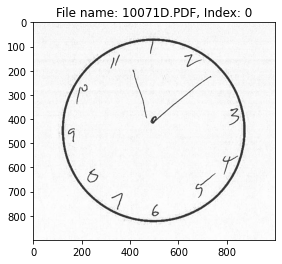

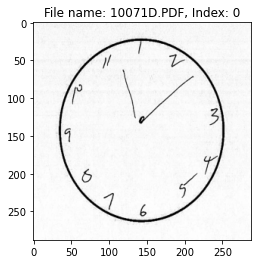

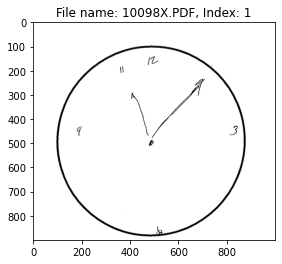

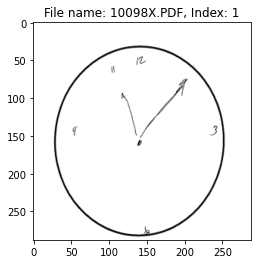

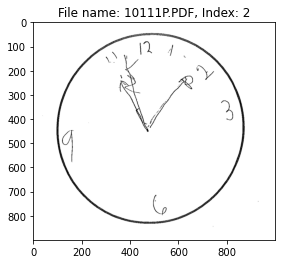

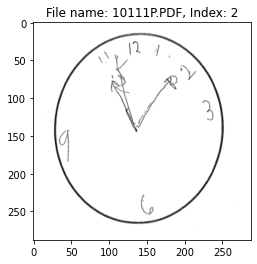

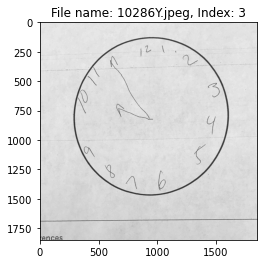

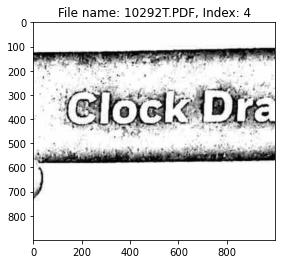

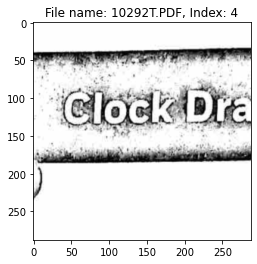

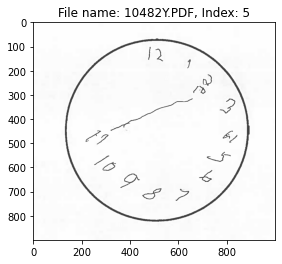

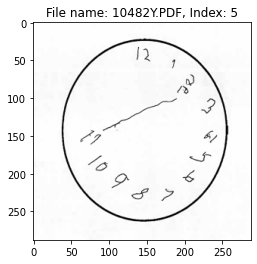

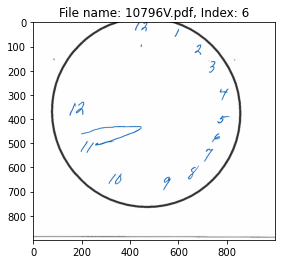

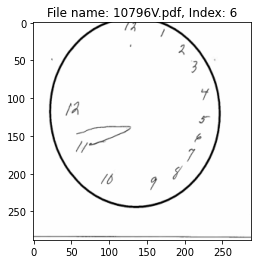

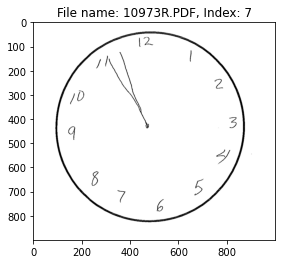

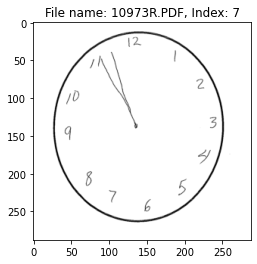

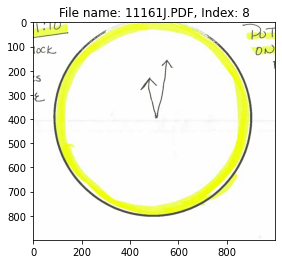

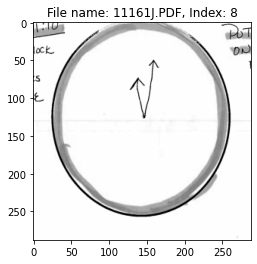

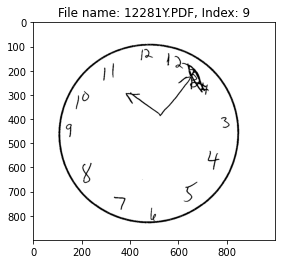

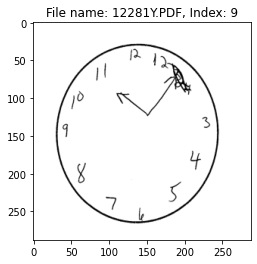

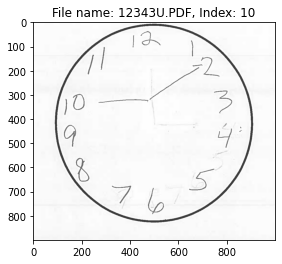

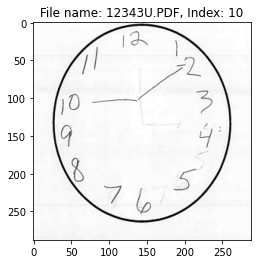

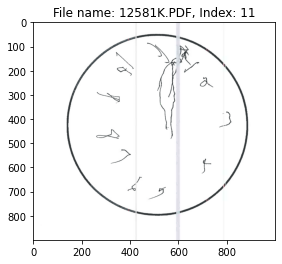

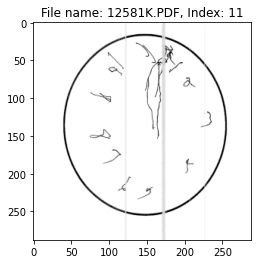

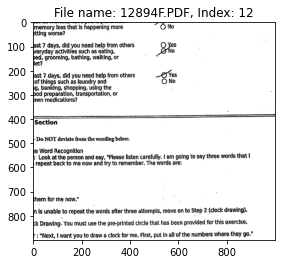

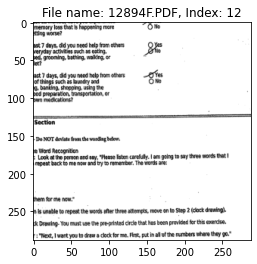

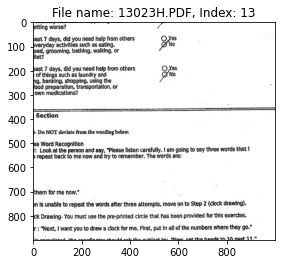

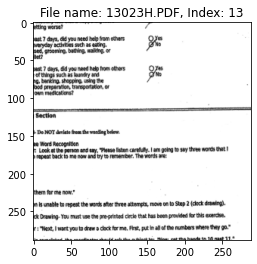

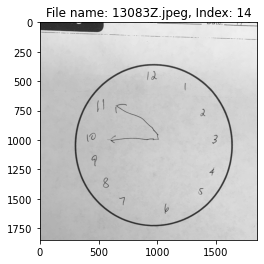

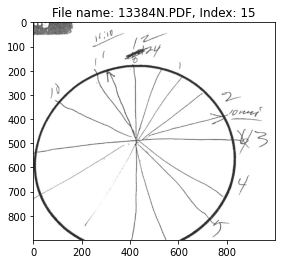

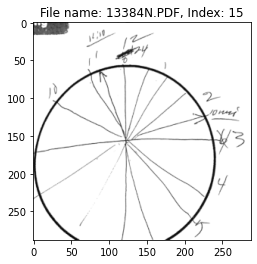

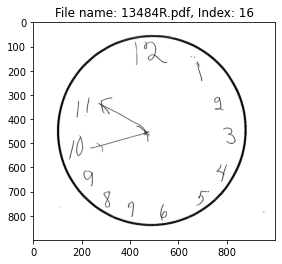

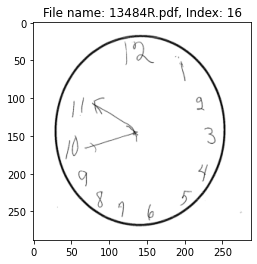

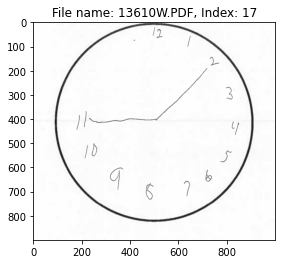

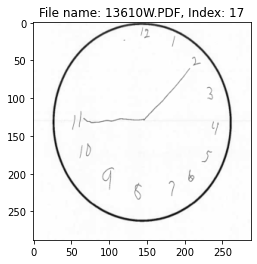

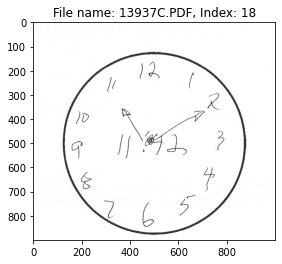

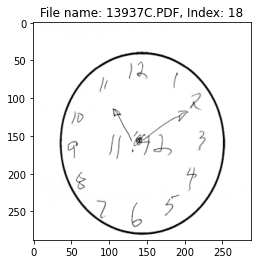

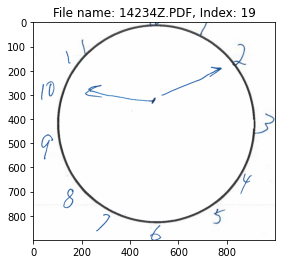

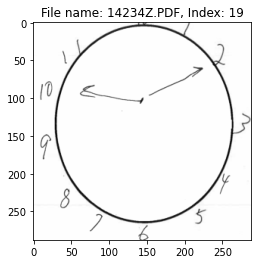

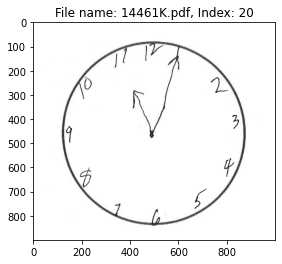

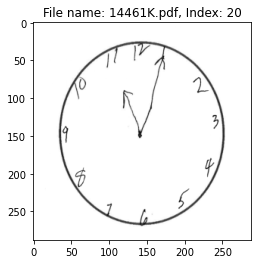

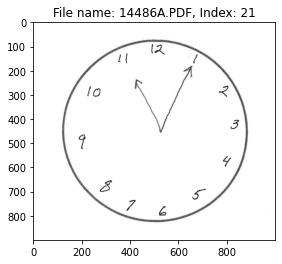

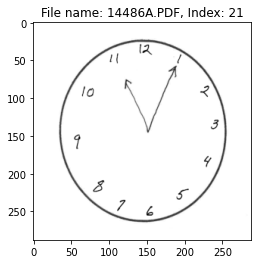

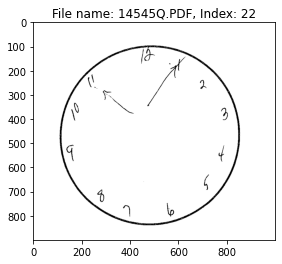

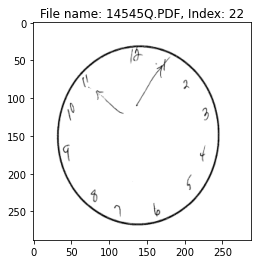

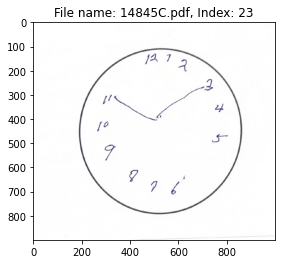

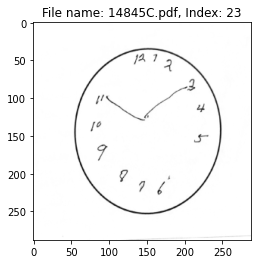

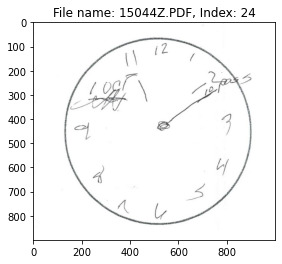

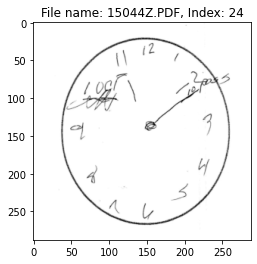

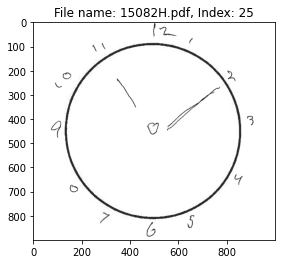

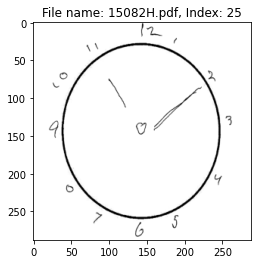

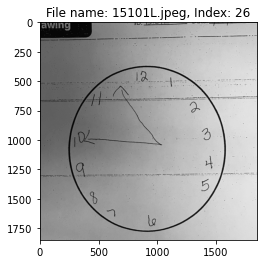

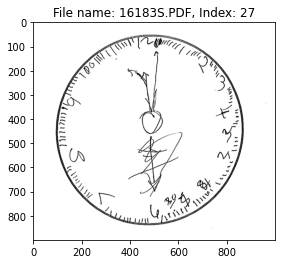

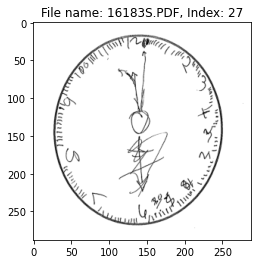

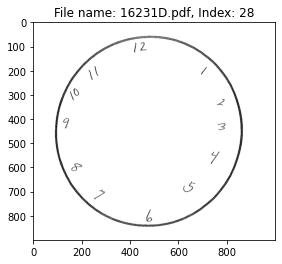

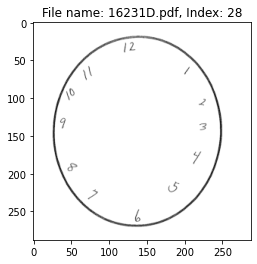

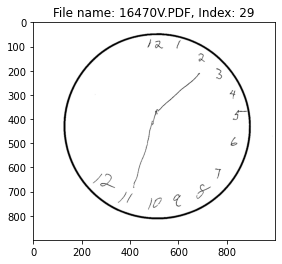

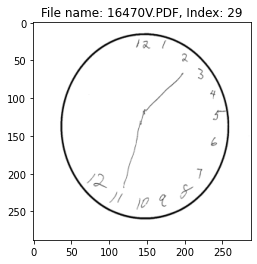

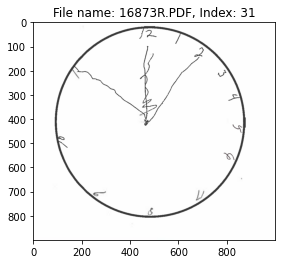

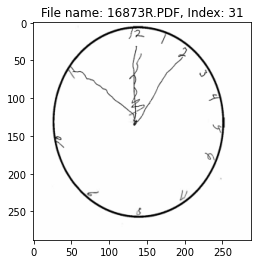

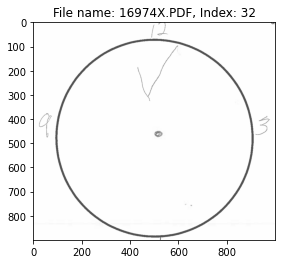

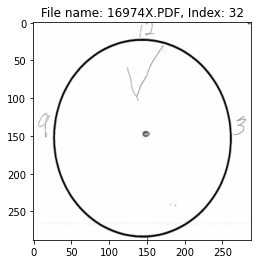

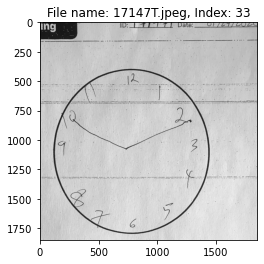

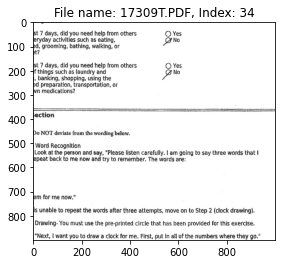

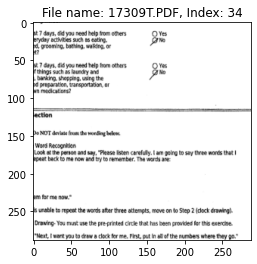

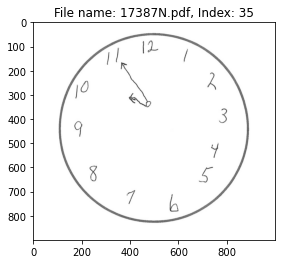

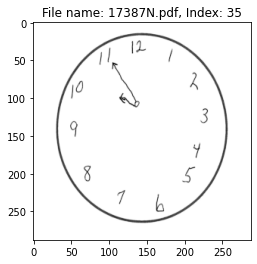

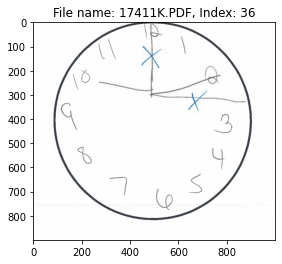

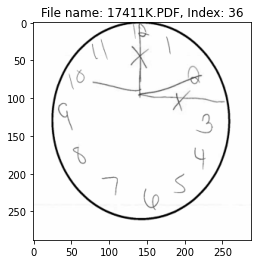

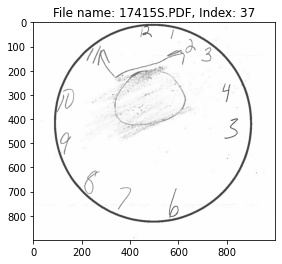

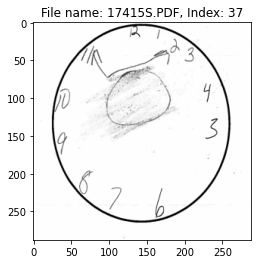

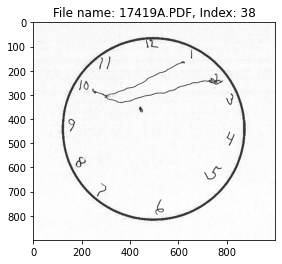

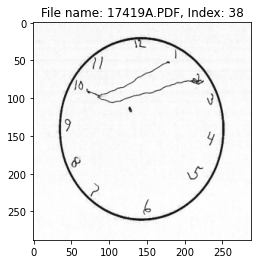

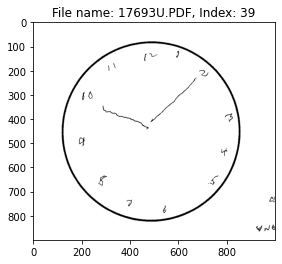

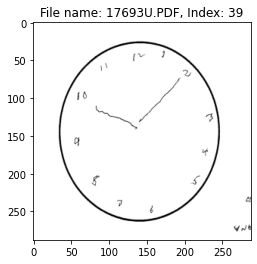

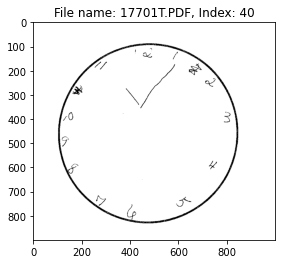

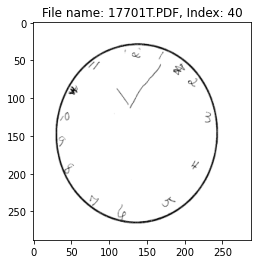

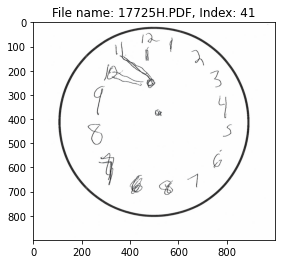

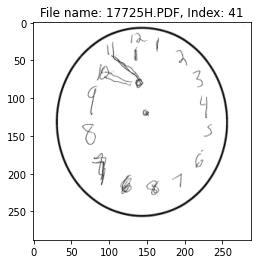

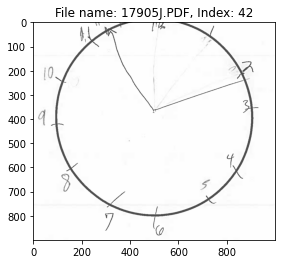

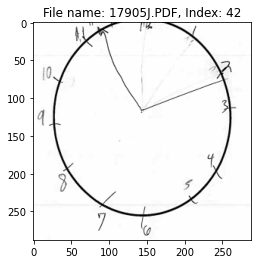

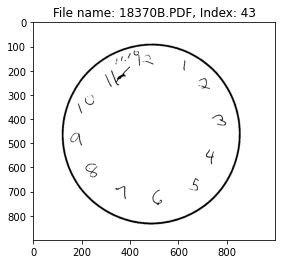

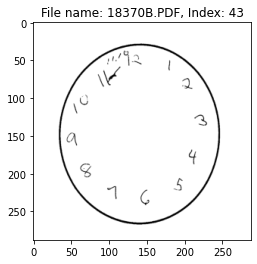

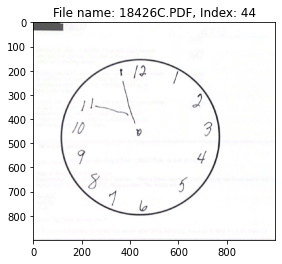

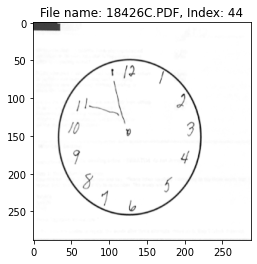

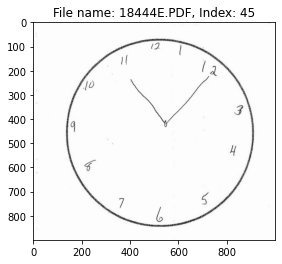

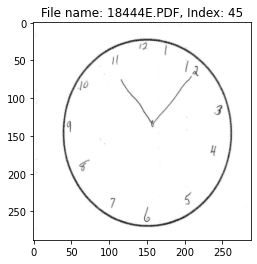

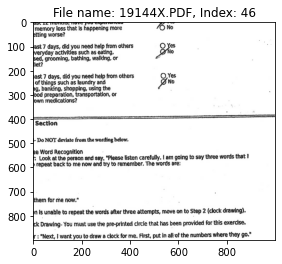

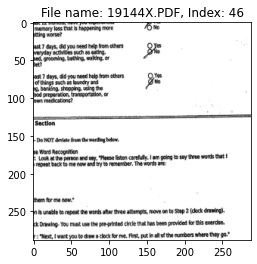

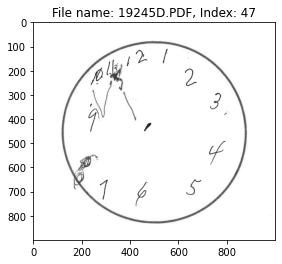

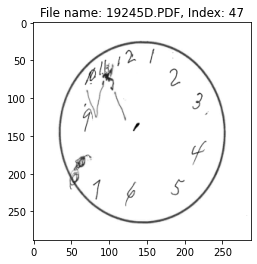

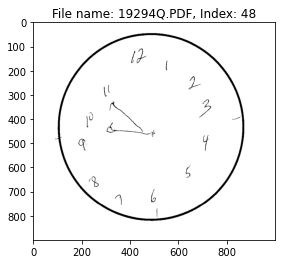

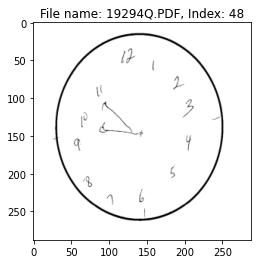

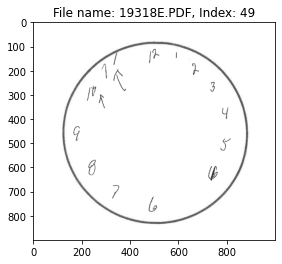

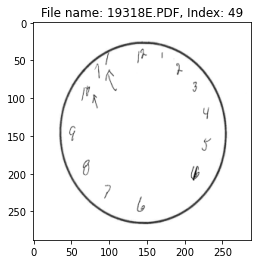

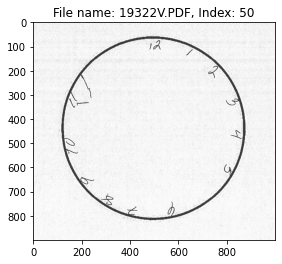

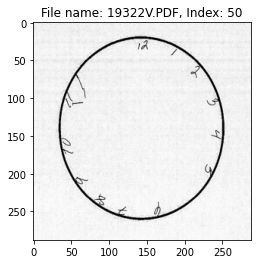

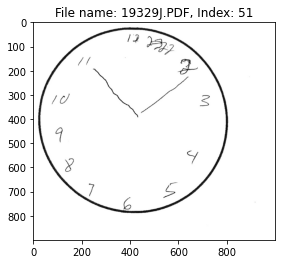

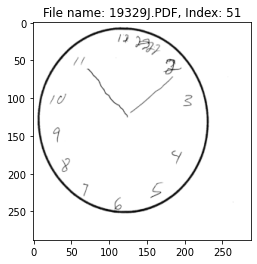

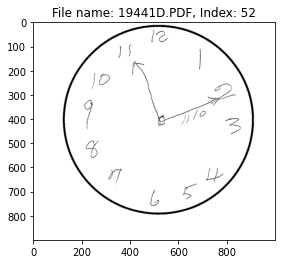

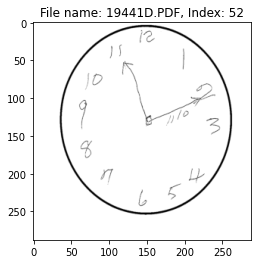

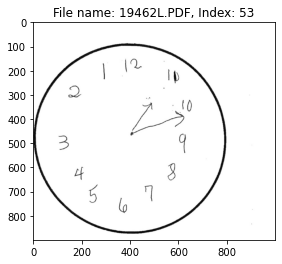

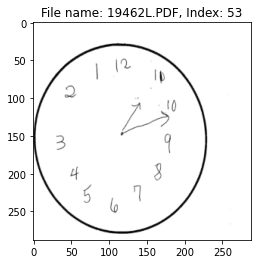

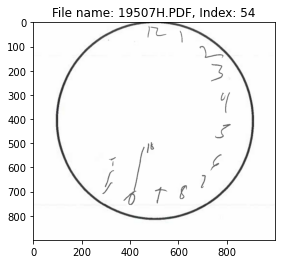

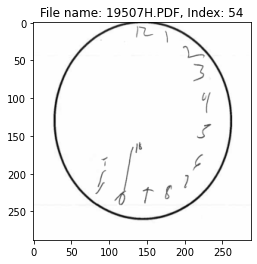

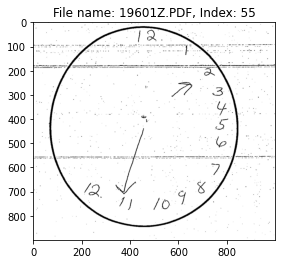

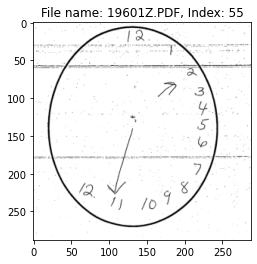

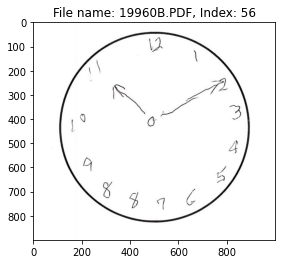

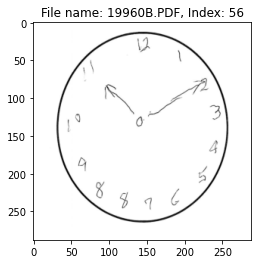

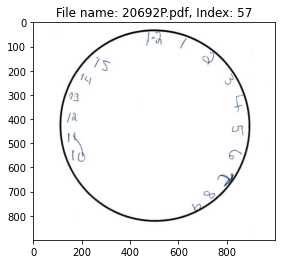

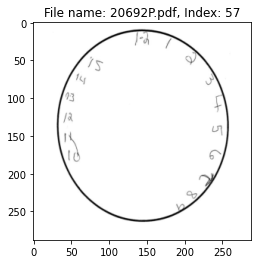

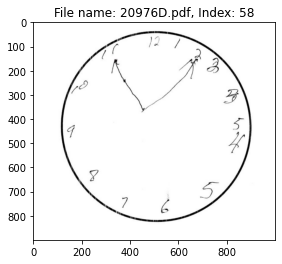

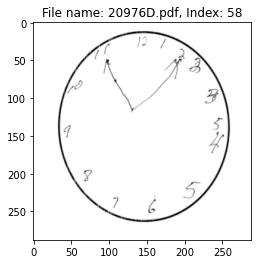

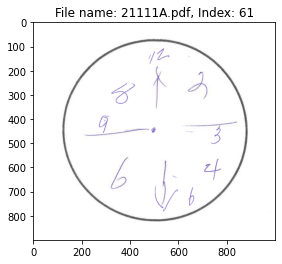

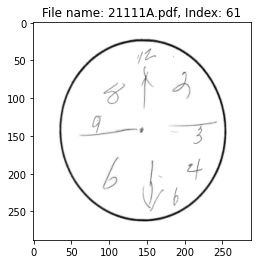

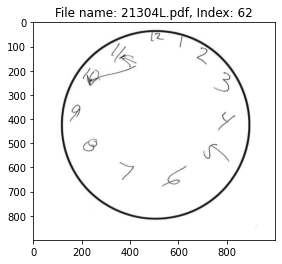

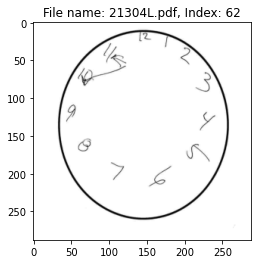

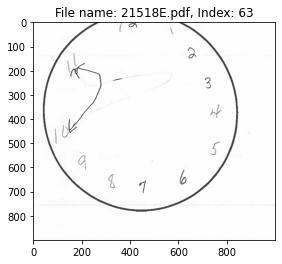

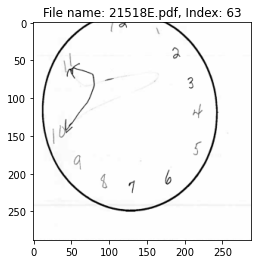

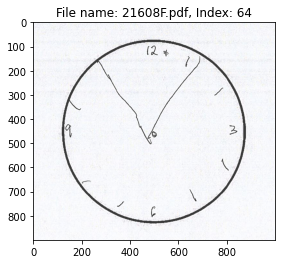

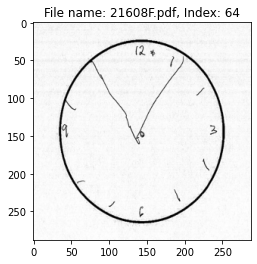

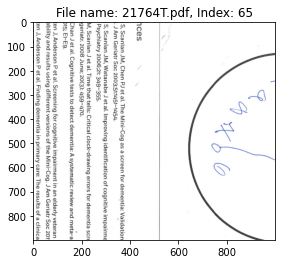

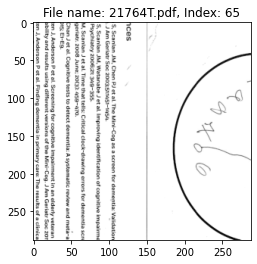

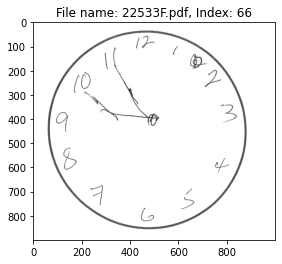

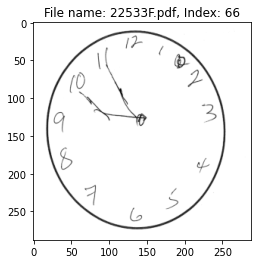

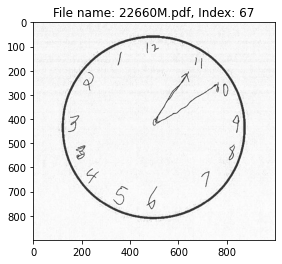

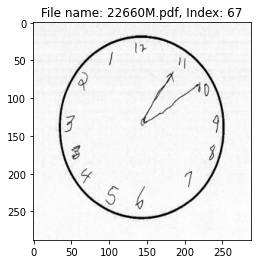

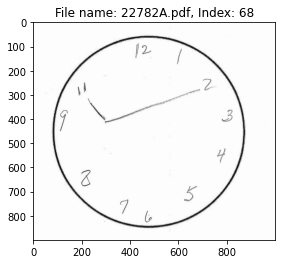

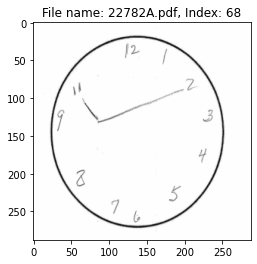

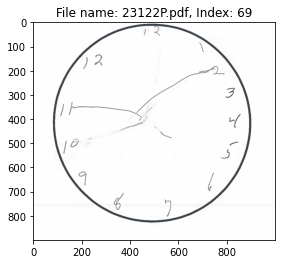

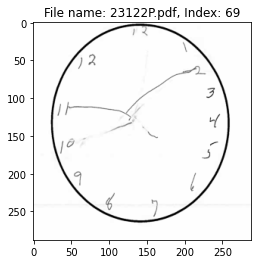

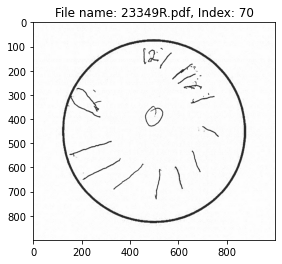

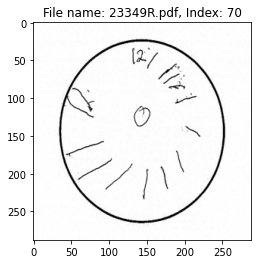

In [42]:
# pixalating PDF clock images and convering them to data matrix

# Reading in Images with an Adjusted Clock Drawing Test Score 
# of 0

#path = r'C:/Users/12563/Documents/Test Clocks 2/'
path = r'C:/Users/12563/Documents/Clocks_0/'
files = os.listdir(path)
dmat1 = np.zeros((len(files), 288, 288))

for index, file in enumerate(files):
    f_name_prim = os.path.basename(file)
    print(f_name_prim)
    print(path)
    print(path+f_name_prim)
    
    _, ext = os.path.splitext(file)
    if ext.lower() == '.pdf':
        # pdf processing
        #print(file)
        images = convert_from_path(path + f_name_prim, poppler_path = r"C:\Users\12563\Desktop\poppler-0.68.0_x86 (1)\poppler-0.68.0\bin")
        image = np.array(images[0])
        y,x,_ = image.shape
        
        # cropping the clocks from the images
        #print(image.shape)
         # saving the clocks in the target folder
        #fig, ax = plt.subplots()    
        #plt.title('File name: {}, Index: {}'.format(file, index))
        #ax.imshow(image, cmap='gray')
        #Cropping
        # I decided on the cropping bounds by looking at printed images
        image = image[350:1250,350:1350] 
        #print(image.shape)
         # saving the clocks in the target folder
        fig, ax = plt.subplots()    
        plt.title('File name: {}, Index: {}'.format(file, index))
        ax.imshow(image, cmap='gray')
        print()
        
        # Grayscaling the images
        image = np.mean(image, axis = 2)

        # resizing the cropped clocks
        image_resized = resize(image, (288, 288))

        dmat1[index] = image_resized

        # saving the clocks into the target folder
        fig, ax = plt.subplots() 
        plt.title('File name: {}, Index: {}'.format(file, index))
        ax.imshow(image_resized, cmap='gray')
        #fig.savefig(path + f_name_prim + '.jpeg') 

        # saving the datamatrix in the target folder
        #np.save(path + 'dmat2', dmat2) 

    elif ext.lower() == '.jpeg':
        # jpeg processing
        
  
        image = imread(path + f_name_prim)

        # cropping the clocks from the images
        image = image[550:2400, 550:2400] 

        # Grayscaling the images
        image = np.mean(image, axis = 2)

        # resizing the cropped clocks
        image_resized = resize(image, (288, 288))

        dmat1[index] = image_resized

        # saving the clocks in the target folder
        fig, ax = plt.subplots()    
        plt.title('File name: {}, Index: {}'.format(file, index))
        ax.imshow(image, cmap='gray')
        
        #fig.savefig(path + f_name_prim)  
    #else:
        #print(file, ext)
        
        #if file == "JPEG":
            #continue
        #print(file)
        #images = convert_from_path(path + f_name_prim, poppler_path = r"C:\Users\12563\Desktop\poppler-0.68.0_x86 (1)\poppler-0.68.0\bin")
        #image = np.array(images[0])
        #y,x,_ = image.shape

Now, we will rotate the images in need of rotation as well as delete images that need to be deleted.

In [43]:
# This code removes the noise and rotates the images

# Images that need rotation (Indexes via printing in the cell above)
#S_rot = [31, 216, 445, 554]

# Noise images that will be removed, Clock not shown on images
#S_noise = [4, 12, 14, 15, 27,33, 35, 41, 44, 47, 51, 52, 93, 103, 125, 137, 157, 160, 162, 176, 185, 188, 233, 240, 249,
           #251, 259, 270, 271, 274, 278, 281, 285, 287, 288, 293, 296, 304, 322, 325, 326, 331, 340, 360, 362, 418, 442,
          #449, 450, 451, 467, 468, 526, 559, 561]
        
S_rot = []
S_noise= [4, 12, 13, 34, 46, 65]
# function for rotating the JPG images
           
def img_rotate (df, rotate) :
    for i in rotate:
        df[i] = np.rot90(df[i],3)
    return(df)

dmat1 = img_rotate (dmat1, S_rot)


# removing noise images
dmat1_nonoise = np.delete(dmat1, S_noise , axis = 0)

In [44]:
# Loading X(clock matrix) and Y (labels) data (already suffeled and noises removed)
X = np.load('/Users/12563/Desktop/Batch 1 (2)/Xall_nonoi_shfl_use_0.npy')
y = np.load('/Users/12563/Desktop/Batch 1 (2)/Yall_nonoi_shfl_use_0.npy')

In [45]:
np.save(r'C:/Users/12563/Documents/dmat2-JPG_nonoise.npy', dmat1_nonoise )

In [46]:
# Add an extra Dimension for Channel for CNN
X = X.reshape([len(X), 288, 288, 1])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, train_size=0.8, random_state=33)

print (len(y_train[y_train == 0]) , len(y_train[y_train == 1]))
print (len(y_test[y_test == 0]) , len(y_test[y_test == 1]))

# Scaling train and test datasets
X_train = X_train/255
X_test = X_test/255

52 0
13 0


In [169]:
# Function for invidual CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool, more details in the report)
def model(activation = 'relu'):
    model = Sequential()
    # Input Image with dimensions (288x288x1) an input image 
    # 288 pixels wide by 288 pixels in height with 1 channel
    model.add(Conv2D(32, kernel_size=(3,3), activation= activation , input_shape=(288,288,1), name="conv_layer_1"))
    model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_1"))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation= activation ,name="conv_layer_2"))
#     model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_2"))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32,activation="relu", name="dense_layer_1"))
    model.add(Dense(2,activation="sigmoid"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')
    return(model)

conv_model =  model(activation = 'relu')
conv_hist = conv_model.fit(X_train,y_train ,epochs= 20,validation_data=(X_test,y_test))
conv_hist_dict = conv_hist.history

Epoch 1/20
2/2 [==============================] - 2s 596ms/step - loss: 0.5889 - accuracy: 0.4038 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 2/20
2/2 [==============================] - 1s 487ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 3/20
2/2 [==============================] - 1s 497ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 5.8555e-05 - val_accuracy: 1.0000
Epoch 4/20
2/2 [==============================] - 1s 506ms/step - loss: 2.9278e-05 - accuracy: 1.0000 - val_loss: 9.0782e-07 - val_accuracy: 1.0000
Epoch 5/20
2/2 [==============================] - 1s 508ms/step - loss: 2.5676e-07 - accuracy: 1.0000 - val_loss: 1.8340e-08 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 1s 523ms/step - loss: 4.5850e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 1s 510ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_a

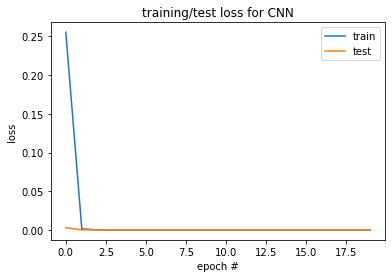

In [48]:
# Training/Testing Loss Charts
plt.plot(list(conv_hist_dict.items())[0][1]) # training loss values
plt.plot(list(conv_hist_dict.items())[2][1]) # test loss values
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.title('training/test loss for CNN')
plt.legend(['train','test'])

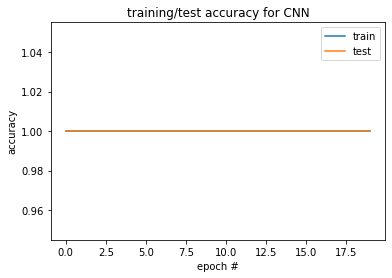

In [49]:
# Training/Testing Accuracy Charts
plt.plot(list(conv_hist_dict.items())[1][1]) # training accuracy values
plt.plot(list(conv_hist_dict.items())[3][1]) # test accuracy values
plt.xlabel('epoch #')
plt.ylabel('accuracy')
plt.title('training/test accuracy for CNN')
plt.legend(['train','test'])

In [50]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1 (Conv2D)       (None, 286, 286, 32)      320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 143, 143, 32)      0         
                                                                 
 flatten (Flatten)           (None, 654368)            0         
                                                                 
 dense_layer_1 (Dense)       (None, 32)                20939808  
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 20,940,194
Trainable params: 20,940,194
Non-trainable params: 0
_________________________________________________________________


In [170]:
import tensorflow as tf
feature_extractor = tf.keras.Model(
    inputs=conv_model.inputs,
    outputs=[
             conv_model.output,  # < last layer output 
             conv_model.layers[2].output # < your convolution layer output 
    ]
)

model_output, conv_layer_output = feature_extractor(X)
conv_layer_output

<tf.Tensor: shape=(65, 654368), dtype=float32, numpy=
array([[  0.      , 107.020935,   0.      , ...,  22.151943,   0.      ,
          0.      ],
       [  0.      ,  28.112223,   0.      , ...,  18.857615,   0.      ,
          0.      ],
       [  0.      , 106.59195 ,   0.      , ...,  22.06471 ,   0.      ,
          0.      ],
       ...,
       [  0.      , 107.4423  ,   0.      , ...,  22.239183,   0.      ,
          0.      ],
       [  0.      , 107.4423  ,   0.      , ...,  22.239183,   0.      ,
          0.      ],
       [  0.      , 104.16882 ,   0.      , ...,  22.35239 ,   0.      ,
          0.      ]], dtype=float32)>

In [52]:
# Perform K-Means on Conv-Layer Output
model = KMeans(n_clusters=2, random_state=42) 
kmeans = model.fit(conv_layer_output)

C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans 

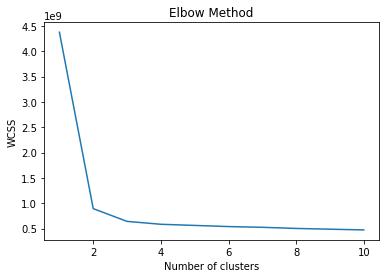

In [290]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(conv_layer_output)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [53]:
# Let us Observe the Labels
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

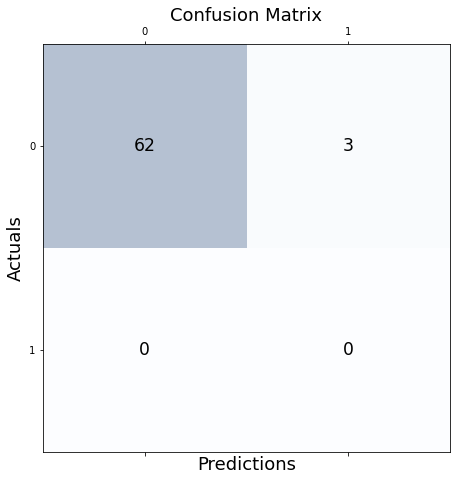

In [54]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmeans.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [55]:
from more_itertools import locate
list_to_check = kmeans.labels_
def find_indices(list_to_check, item_to_find):  
    indices = locate(list_to_check,lambda x: x == item_to_find)
    return list(indices)

indices_of_intrest = find_indices(list_to_check, 1)
indices_of_intrest

[17, 33, 61]

In [63]:
files_nonoise
files_nonoise[indices_of_intrest]

array(['14461K.pdf', '17415S.PDF', '22660M.pdf'], dtype='<U11')

In [64]:
# The Lowest SSE Value
kmeans.inertia_

1699679107.032565

In [65]:
# The number of iterations required to converge
kmeans.n_iter_

2

## K-Medoids

In [171]:
from sklearn_extra.cluster import KMedoids

# 2-Clusters

kmedoids = KMedoids(n_clusters=2, random_state=0).fit(conv_layer_output)

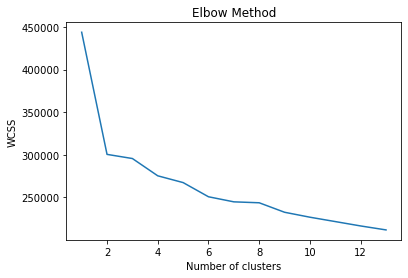

In [178]:
wcss = []
for i in range(1, 14):
    kmed = KMedoids(n_clusters=i, init='k-medoids++', max_iter=300, random_state=0)
    kmed.fit(conv_layer_output)
    wcss.append(kmed.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [107]:
kmedoids.labels_

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
      dtype=int64)

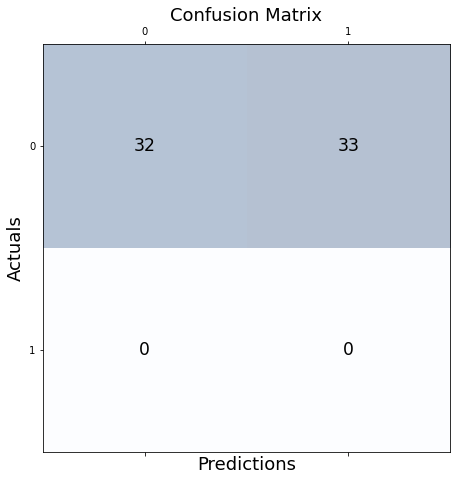

In [172]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmedoids.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [173]:
# The Lowest SSE Value
# A good model is one with low inertia AND a small number 
# of clusters

kmedoids.inertia_

317641.03

In [244]:
from sklearn_extra.cluster import KMedoids

kmedoids_3 = KMedoids(n_clusters=3, random_state=0).fit(conv_layer_output)

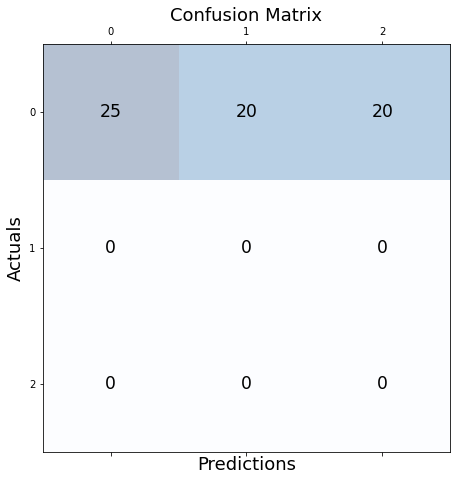

In [245]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmedoids_3.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [246]:
# The Lowest SSE Value
# A good model is one with low inertia AND a small number 
# of clusters

kmedoids_3.inertia_

430086.97

In [248]:
from sklearn_extra.cluster import KMedoids

kmedoids_4 = KMedoids(n_clusters=4, random_state=0).fit(conv_layer_output)

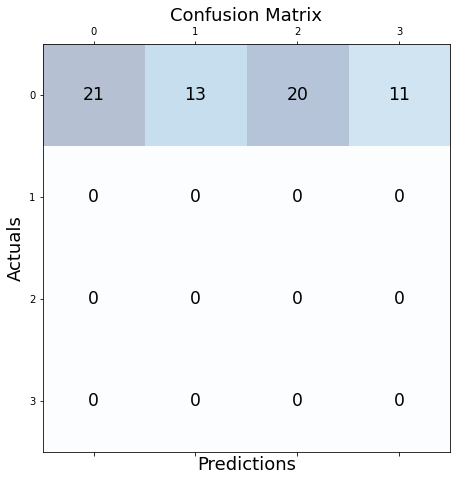

In [249]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmedoids_4.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [250]:
# The Lowest SSE Value
# A good model is one with low inertia AND a small number 
# of clusters

kmedoids_4.inertia_

424323.56

In [69]:
df_ = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/COPD.csv")
df_

sid  COPD_P3
0     10015T        1
1     10017X        1
2     10031R        0
3     10032T        1
4     10049K        1
...      ...      ...
1712  23634Q        0
1713  23696M        1
1714  23785L        1
1715  23793K        0
1716  24637B        0

[1717 rows x 2 columns]

In [174]:
from more_itertools import locate
list_to_check = kmedoids.labels_
def find_indices(list_to_check, item_to_find):  
    indices = locate(list_to_check,lambda x: x == item_to_find)
    return list(indices)

indices_of_intrest = find_indices(list_to_check, 0)
indices_of_intrest

[0,
 1,
 3,
 7,
 11,
 13,
 16,
 17,
 18,
 21,
 22,
 25,
 27,
 28,
 29,
 31,
 33,
 34,
 36,
 38,
 44,
 46,
 47,
 49,
 50,
 52,
 54,
 55,
 58,
 60,
 61,
 64]

In [175]:
files_delete

Clocks
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
..     ...
60   22533
61  22660M
62  22782A
63   23122
64  23349R

[65 rows x 1 columns]

In [176]:
#finding clock drawing images in the second cluster
indices_of_intrest_1 = find_indices(list_to_check, 1)

df_p_1 = pd.DataFrame(files_nonoise[indices_of_intrest_1], columns = ['sid'])

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
df_p_1['sid'] = files_delete['Clocks'].str.rstrip('.pdf')
#df_p_1

In [177]:
files_delete['Clocks']

0      10071
1     10098X
2      10111
3     10286Y
4     10482Y
       ...  
60     22533
61    22660M
62    22782A
63     23122
64    23349R
Name: Clocks, Length: 65, dtype: object

In [178]:
df_p_1 = pd.DataFrame(files_nonoise[indices_of_intrest_1], columns = ['sid'])

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
# Remove Leading and Treailing spaces
df_p_1['sid'] = df_p_1['sid'].str.strip('.pdf')
# Remove Leading and Treailing spaces
df_p_1['sid'] = df_p_1['sid'].str.strip('.PDF')
# Remove Leading and Treailing spaces
df_p_1['sid'] = df_p_1['sid'].str.strip('.jpeg')
df_p_1

sid
0    10111
1   10482Y
2   10796V
3   10973R
4   12281Y
5   12343U
6   12581K
7   13384N
8   13610W
9   13937C
10  14545Q
11  14845C
12  15101L
13  16183S
14  16470V
15  17147T
16  17411K
17  17693U
18  17725H
19  18370B
20  18426C
21  18444E
22   19245
23  19294Q
24  19322V
25  19462L
26  19960B
27   20976
28  21111A
29  21304L
30   21608
31  22782A
32   23122

In [179]:
df_p_1 = pd.DataFrame(files_nonoise[indices_of_intrest_1], columns = ['sid'])
df_p_1

#df_p_1['sid'] = files_nonoise['sid'].str.rstrip('.PDF')

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
df_p_1['sid'] = files_delete['Clocks'].str.rstrip('.pdf')
#df_p_1

In [180]:
len(files_nonoise[indices_of_intrest])

32

In [181]:
df_p = pd.DataFrame(files_nonoise[indices_of_intrest], columns = ['sid'])

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
# Remove Leading and Treailing spaces
df_p['sid'] = df_p['sid'].str.strip('.pdf')
# Remove Leading and Treailing spaces
df_p['sid'] = df_p['sid'].str.strip('.PDF')
# Remove Leading and Treailing spaces
df_p['sid'] = df_p['sid'].str.strip('.jpeg')
df_p
#email_string = email_string.strip()
#df_p['sid'] = files_delete['Clocks'].str.rstrip('.pdf')
#df_p

sid
0    10071
1   10098X
2   10286Y
3   11161J
4   13083Z
5   13484R
6   14234Z
7   14461K
8   14486A
9   15044Z
10  15082H
11   16231
12  16830Z
13  16873R
14  16974X
15  17387N
16  17415S
17  17419A
18  17701T
19  17905J
20  19318E
21  19329J
22   19441
23  19507H
24  19601Z
25   20692
26  20977F
27  21075W
28  21518E
29   22533
30  22660M
31  23349R

In [182]:
#Sids of Label 0 from the K-Medoid Algorithm with the associated Self-Reported COPD Score
df_f = df_.merge(df_p,on = 'sid')
df_f

sid  COPD_P3
0   10098X        0
1   10286Y        0
2   13083Z        0
3   14234Z        0
4   14461K        1
5   14486A        0
6   15044Z        0
7   15082H        1
8   16974X        0
9   17387N        0
10  17415S        1
11  17419A        0
12  17701T        1
13  17905J        0
14  19329J        0
15  21518E        0
16  22660M        0
17  23349R        1

In [183]:
# Obtaining the Clock Drawing images obtaing a label of 1
indices_of_intrest_1 = find_indices(list_to_check, 1)
indices_of_intrest_1

[2,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 14,
 15,
 19,
 20,
 23,
 24,
 26,
 30,
 32,
 35,
 37,
 39,
 40,
 41,
 42,
 43,
 45,
 48,
 51,
 53,
 56,
 57,
 59,
 62,
 63]

In [184]:
df_p_1 = pd.DataFrame(files_nonoise[indices_of_intrest_1], columns = ['sid'])

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
df_p_1['sid'] = files_delete['Clocks'].str.rstrip('.pdf')
df_p_1

sid
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
5   10796V
6   10973R
7   11161J
8   12281Y
9   12343U
10  12581K
11  13083Z
12  13384N
13  13484R
14  13610W
15  13937C
16  14234Z
17  14461K
18  14486A
19  14545Q
20  14845C
21  15044Z
22  15082H
23  15101L
24  16183S
25   16231
26  16470V
27  16830Z
28  16873R
29  16974X
30  17147T
31  17387N
32  17411K

In [185]:
# Obtaining Average Value of Factor Scores in Cluster A
df_fac_1 = fac.merge(df_p_1, on = 'sid')
df_fac_1

df_fac.mean()

C:\Users\12563\AppData\Local\Temp/ipykernel_4432/1998781800.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fac.mean()


F1compP2    0.420098
F2compP2    0.073090
F3compP2    0.369615
F4compP2    0.227320
dtype: float64

In [186]:
#Sids of Label 0 from the K-Medoid Algorithm with the associated Self-Reported COPD Score
df_f_1 = df_.merge(df_p_1,on = 'sid')
df_f_1

sid  COPD_P3
0   10098X        0
1   10286Y        0
2   10482Y        1
3   10796V        1
4   10973R        0
5   12281Y        0
6   12343U        0
7   13083Z        0
8   13384N        0
9   13610W        1
10  14234Z        0
11  14461K        1
12  14486A        0
13  14545Q        1
14  14845C        0
15  15044Z        0
16  15082H        1
17  15101L        1
18  16183S        0
19  16470V        1
20  16974X        0
21  17147T        0
22  17387N        0
23  17411K        0

In [187]:
fac = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/P2_factor_scores_20220610.csv")

In [188]:
gold = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data_Final.csv')

In [189]:
# Obtaining Average Value of Factor Scores in Cluster A
df_fac = fac.merge(df_p, on = 'sid')
df_fac

df_fac.mean()

C:\Users\12563\AppData\Local\Temp/ipykernel_4432/2776651171.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fac.mean()


F1compP2    0.382747
F2compP2    0.006460
F3compP2    0.337891
F4compP2    0.179012
dtype: float64

In [190]:
# Obtaining Average Value of Factor Scores in Cluster A
df_fac_1 = fac.merge(df_p_1, on = 'sid')
df_fac_1

df_fac_1.mean()

C:\Users\12563\AppData\Local\Temp/ipykernel_4432/167439210.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fac_1.mean()


F1compP2    0.318426
F2compP2    0.008456
F3compP2    0.310909
F4compP2    0.339852
dtype: float64

In [191]:
df_fac['F1compP2']

0     0.396002
1     0.792556
2     0.136775
3     0.834276
4    -0.864085
5    -0.126046
6     0.796079
7    -0.076167
8     2.310415
9     0.985111
10   -0.332487
11   -0.502296
12    2.290672
13    0.454480
14    0.679127
15   -0.167578
16   -1.093807
17   -0.484713
18    0.791603
19    0.171660
20    0.530949
21    0.897902
Name: F1compP2, dtype: float64

In [192]:
F1compP2 = 0.439810
F2compP2 = 0.340643

In [193]:
df_fac_1

sid  F1compP2  F2compP2  F3compP2  F4compP2
0   10098X  0.396002  0.868078  0.451179 -0.729966
1   10286Y  0.792556 -0.630638  0.904748 -0.785195
2   10796V  0.667201 -0.269795  0.928741  1.774383
3   12281Y  0.781732  0.491166  0.584655  0.759469
4   12343U  0.012340  0.082806 -0.323906 -0.060235
5   13083Z  0.136775  0.604984  0.261665  0.909699
6   13384N  0.085730  0.470285  0.325569  0.030117
7   13484R  0.834276 -0.028157  1.110327  1.026943
8   13610W  0.713851  0.482236  0.801969  1.770297
9   13937C  0.437493 -0.450963  0.362679  0.934088
10  14486A -0.864085 -1.019094 -0.753519 -0.500678
11  14545Q  1.212988  0.354166  1.016279  0.247180
12  15044Z -0.126046 -0.577395 -0.300687  0.549455
13  15082H  0.796079  1.127933  0.532250  1.256171
14  15101L -0.335524 -1.327074 -0.176607 -0.803219
15  16470V  0.140967  0.248432  0.227176  0.827360
16  16830Z -0.076167  0.355262 -0.326202 -0.308485
17  16873R  2.310415  0.550813  2.460517  1.891373
18  16974X  0.985111  0.100505  0.832637  0.715214
19  17147T -1.882266 -0.519316 -1.858001 -1.241448
20  17387N -0.332487 -0.736653 -0.532372 -1.125639

In [194]:
df_fac['F1compP2']

0     0.396002
1     0.792556
2     0.136775
3     0.834276
4    -0.864085
5    -0.126046
6     0.796079
7    -0.076167
8     2.310415
9     0.985111
10   -0.332487
11   -0.502296
12    2.290672
13    0.454480
14    0.679127
15   -0.167578
16   -1.093807
17   -0.484713
18    0.791603
19    0.171660
20    0.530949
21    0.897902
Name: F1compP2, dtype: float64

In [195]:
stats.ttest_ind(0.074058, -0.056599)

C:\Users\12563\OneDrive\New folder\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\12563\OneDrive\New folder\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)

In [196]:
# Factor 1 T Test
from scipy import stats
stats.ttest_ind(df_fac['F1compP2'], df_fac_1['F1compP2'])

Ttest_indResult(statistic=0.24825156251292152, pvalue=0.8051790032971889)

In [197]:
# Factor 2 T Test
stats.ttest_ind(df_fac['F2compP2'], df_fac_1['F2compP2'])

Ttest_indResult(statistic=-0.008125093344626083, pvalue=0.9935565917205363)

In [198]:
# Factor 3 T Test
stats.ttest_ind(df_fac['F3compP2'], df_fac_1['F3compP2'])

Ttest_indResult(statistic=0.0992872222260467, pvalue=0.9213940997350428)

In [199]:
# Factor 4 T Test
stats.ttest_ind(df_fac['F4compP2'], df_fac_1['F4compP2'])

Ttest_indResult(statistic=-0.5716194185476762, pvalue=0.5707005241501556)

In [196]:
# Obtaining Percentage of people with FINAL Golde Baseline 1-4 Cluster A
df_gold = gold.merge(df_p, on = 'sid')
df_gold

(np.sum(df_gold['goldstage_final_V2'] != 0)/36) *100

44.44444444444444

In [199]:
df_gold_1 = gold.merge(df_p_1, on = 'sid')
df_gold_1

sid  fev1pp_final  goldstage_final_V2  COPD_P3  Score
0   10098X         120.3                   2        0      0
1   10286Y          77.7                   2        0      0
2   10482Y          59.7                   2        1      0
3   10796V          78.6                   2        1      0
4   10973R          74.3                   2        0      0
5   12281Y          59.8                   2        0      0
6   12343U          86.5                   0        0      0
7   13083Z          72.1                   2        0      0
8   13384N          81.1                   0        0      0
9   13610W          25.2                   2        1      0
10  14234Z          86.8                   0        0      0
11  14461K          18.7                   2        1      0
12  14486A          82.0                   0        0      0
13  14545Q          77.3                   1        1      0
14  14845C         146.1                   0        0      0
15  15044Z          93.0                   2        0      0
16  15082H          56.7                   2        1      0
17  15101L          98.6                   0        1      0
18  16183S         106.4                   0        0      0
19  16470V          64.0                   2        1      0
20  16974X          53.8                   2        0      0
21  17147T         112.6                   0        0      0

In [200]:
(np.sum(df_gold_1['goldstage_final_V2'] != 0)/29) *100

48.275862068965516

In [202]:
# The Lowest SSE Value
# A good model is one with low inertia AND a small number 
# of clusters

kmedoids.inertia_

434711.1

Now, we are wanting to create a dataframe by merging the SIDs of the images that were pixelated with Dataset1 (FEV1, GOLD Stage, & COPD Score (Yes/No))

In [58]:
# Creating array of the files to create
files = np.array(files)

files_nonoise = np.delete(files, S_noise, axis = 0)

Now, we are going to create a data frame that consists of the Subject ID's in which we have succefully pixeled their Clock Drawing Test Image. 

In [59]:
# Generating the List of scores associated with the files_nonoise
score_list = np.zeros(files_nonoise.shape[0]) 

blank = []

# for loop to match score of df_join to Pixelated clock images
for indices in range(files_nonoise.shape[0]):
    ext, _ = os.path.splitext(files_nonoise[indices])
    #print(ext)
    if ext in Clock_list['Clocks'].tolist():
        score_update = Clock_list[Clock_list['Clocks'] == ext]['Scores'].iloc[0]
        print(score_update)
        score_list[indices] = score_update
    else:
        blank.append(indices)
        
# Cleaned Image Data        
dmat1_delete = np.delete(dmat1_nonoise, blank, axis = 0)

# Cleaned Score Data
Scores_delete = np.delete(score_list, blank, axis = 0)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [60]:
# Deleting the SIDs of the files that were delted
files_delete = np.delete(files_nonoise, blank, axis = 0)

# Convert the NumPy Array to Pandas data Frame
files_delete = pd.DataFrame(files_delete)

# Rename column in a dataframe
files_delete.columns = ['Clocks']

In [61]:
# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.pdf')
# Strip .PDF
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.PDF')
# Strip .jpeg
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.jpeg')

files_delete

Clocks
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
..     ...
60   22533
61  22660M
62  22782A
63   23122
64  23349R

[65 rows x 1 columns]

In [62]:
files_nonoise

array(['10071D.PDF', '10098X.PDF', '10111P.PDF', '10286Y.jpeg',
       '10482Y.PDF', '10796V.pdf', '10973R.PDF', '11161J.PDF',
       '12281Y.PDF', '12343U.PDF', '12581K.PDF', '13083Z.jpeg',
       '13384N.PDF', '13484R.pdf', '13610W.PDF', '13937C.PDF',
       '14234Z.PDF', '14461K.pdf', '14486A.PDF', '14545Q.PDF',
       '14845C.pdf', '15044Z.PDF', '15082H.pdf', '15101L.jpeg',
       '16183S.PDF', '16231D.pdf', '16470V.PDF', '16830Z.jpg',
       '16873R.PDF', '16974X.PDF', '17147T.jpeg', '17387N.pdf',
       '17411K.PDF', '17415S.PDF', '17419A.PDF', '17693U.PDF',
       '17701T.PDF', '17725H.PDF', '17905J.PDF', '18370B.PDF',
       '18426C.PDF', '18444E.PDF', '19245D.PDF', '19294Q.PDF',
       '19318E.PDF', '19322V.PDF', '19329J.PDF', '19441D.PDF',
       '19462L.PDF', '19507H.PDF', '19601Z.PDF', '19960B.PDF',
       '20692P.pdf', '20976D.pdf', '20977F.jpg', '21075W.jpg',
       '21111A.pdf', '21304L.pdf', '21518E.pdf', '21608F.pdf',
       '22533F.pdf', '22660M.pdf', '22782A.pdf', '2

In [379]:
d_c = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/COPD.csv")
d_c

sid  COPD_P3
0     10015T        1
1     10017X        1
2     10031R        0
3     10032T        1
4     10049K        1
...      ...      ...
1712  23634Q        0
1713  23696M        1
1714  23785L        1
1715  23793K        0
1716  24637B        0

[1717 rows x 2 columns]

In [380]:
files_delete = files_delete.rename(columns = {'Clocks':'sid'})
d = d_c.merge(files_delete,on = 'sid')
d

sid  COPD_P3
0    10098X        0
1    10286Y        0
2    10348U        0
3    10473X        0
4    10482Y        1
..      ...      ...
307  23619U        0
308  23634Q        0
309  23696M        1
310  23785L        1
311  24637B        0

[312 rows x 2 columns]

In [381]:
files_delete = files_delete.rename(columns = {'sid':'Clocks'})
dataset_5 = files_delete.merge(Dataset_1,on = 'Clocks')
dataset_5

Clocks  FEV1_Score  GOLD Stage  COPD_Score  Score
0    10098X       120.3           2           0      0
1    10286Y        77.7           2           0      0
2    10348U       114.3           0           0      2
3    10473X        40.4           2           0      2
4    10482Y        59.7           2           1      0
..      ...         ...         ...         ...    ...
307  23619U        83.6           2           0      2
308  23634Q        73.9           1           0      2
309  23696M        72.4           2           1      2
310  23785L        51.7           2           1      2
311  24637B       119.4           2           0      2

[312 rows x 5 columns]

We will now perform statistical analysis on Dataset 5 created via merging Dataset 1 & the Subject ID's of the images files that have been succesfully pixelated.

We begin the statistical Analysis by performing the Chi-Squared Test for Independence on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score

In [206]:
# Chi-Square Test

df_use_5_ = pd.DataFrame(dataset_5, columns = ['Score', 'COPD_Score']) 
df_use_5_

Score  COPD_Score
0       0           0
1       0           0
2       0           1
3       0           1
4       0           0
5       0           0
6       0           0
7       0           0
8       0           0
9       0           1
10      0           0
11      0           1
12      0           0
13      0           1
14      0           0
15      0           0
16      0           1
17      0           1
18      0           0
19      0           1
20      0           0
21      0           0
22      0           0
23      0           0
24      0           1
25      0           0
26      0           1
27      2           0
28      0           0
29      0           1
30      0           1
31      0           1
32      0           0
33      0           0
34      0           0
35      0           1
36      0           0
37      0           1
38      0           0
39      0           0
40      0           0
41      0           1

In [208]:
# create contingency table
data_crosstab_5_ = pd.crosstab(df_use_5_['Score'],
                            df_use_5_['COPD_Score'],
                           )

data_crosstab_5_

COPD_Score   0   1
Score             
0           25  16
2            1   0

In [209]:
# Chi-Squared Test

res_5_ = stat()
res_5_.chisq(df=data_crosstab_5_)
# output
print(res_5_.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1             0          1
Log-likelihood     1             0          1



We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score variable

In [210]:
print(res_5_.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

            0          1
--  ---------  ---------
 0  25.381     15.619
 1   0.619048   0.380952



Now, we will perform the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score.

In [211]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5_ = np.array([[25,16],[171,66]])
fisher_test_5_ = stats.fisher_test(m_5_)

print('p-value: {}'.format(fisher_test_5_[0][0]))

p-value: 0.19318999454553773


Furthermore, the Chi-Squared Test for Independence was execuated on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [212]:
# Chi-Square Test

df_use_5_gold = pd.DataFrame(dataset_5, columns = ['Score', 'GOLD Stage']) 
df_use_5_gold

Score  GOLD Stage
0       0           2
1       0           2
2       0           2
3       0           2
4       0           2
5       0           2
6       0           0
7       0           2
8       0           0
9       0           2
10      0           0
11      0           2
12      0           0
13      0           1
14      0           0
15      0           2
16      0           2
17      0           0
18      0           0
19      0           2
20      0           2
21      0           0
22      0           0
23      0           1
24      0           2
25      0           0
26      0           2
27      2           0
28      0           0
29      0           0
30      0           2
31      0           2
32      0           2
33      0           2
34      0           0
35      0           1
36      0           0
37      0           0
38      0           0
39      0           2
40      0           1
41      0           2

In [214]:
# create contingency table
data_crosstab_5_gold = pd.crosstab(df_use_5_gold['Score'],
                            df_use_5_gold['GOLD Stage'],
                           )

data_crosstab_5_gold

GOLD Stage   0  1   2
Score                
0           16  4  21
2            1  0   0

In [215]:
# Chi-Squared Test

res_5_gold = stat()
res_5_gold.chisq(df=data_crosstab_5_gold)
# output
print(res_5_gold.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       1.50646   0.470844
Log-likelihood     2       1.84492   0.397539



Expected Frequency Counts for the Chi-Squared Test for Independence performed on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable were observed to ensure assumptions were met.

In [216]:
print(res_5_gold.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

            0          1     2
--  ---------  ---------  ----
 0  16.5952    3.90476    20.5
 1   0.404762  0.0952381   0.5



Now, we implemented the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [217]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5_gold = np.array([[16,4,21],[113,20,104]])
fisher_test_5_gold = stats.fisher_test(m_5_gold)
print('p-value: {}'.format(fisher_test_5_gold[0][0]))

p-value: 0.5469859944350306


We will perform a one-way ANOVA on the FEV1 variable.

In [218]:
model = ols('FEV1_Score ~ COPD_Score', data=dataset_5).fit()
anova_table_5 = sm.stats.anova_lm(model, typ=2)
anova_table_5

sum_sq    df          F    PR(>F)
COPD_Score   6525.607420   1.0  11.724078  0.001438
Residual    22263.950913  40.0        NaN       NaN

Next, we will perfrom the Chi-Squared Test for Independence on the GOLD Stage Variable.

In [219]:
# Chi-Square Test

df_use_5 = pd.DataFrame(dataset_5, columns = ['COPD_Score', 'GOLD Stage']) 
df_use_5

COPD_Score  GOLD Stage
0            0           2
1            0           2
2            1           2
3            1           2
4            0           2
5            0           2
6            0           0
7            0           2
8            0           0
9            1           2
10           0           0
11           1           2
12           0           0
13           1           1
14           0           0
15           0           2
16           1           2
17           1           0
18           0           0
19           1           2
20           0           2
21           0           0
22           0           0
23           0           1
24           1           2
25           0           0
26           1           2
27           0           0
28           0           0
29           1           0
30           1           2
31           1           2
32           0           2
33           0           2
34           0           0
35           1           1
36           0           0
37           1           0
38           0           0
39           0           2
40           0           1
41           1           2

In [220]:
# create contingency table
data_crosstab_5 = pd.crosstab(df_use_5['COPD_Score'],
                            df_use_5['GOLD Stage'],
                           )

data_crosstab_5

GOLD Stage   0  1   2
COPD_Score           
0           14  2  10
1            3  2  11

In [221]:
# Chi-Squared Test

res_5 = stat()
res_5.chisq(df=data_crosstab_5)
# output
print(res_5.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       5.07183  0.0791891
Log-likelihood     2       5.36669  0.0683341



We will now look at the Expected Frequency Counts for the Chi-Squared Test for Independence on the GOLD Stage Variable from Dataset 5.

In [222]:
print(res_5.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0        1    2
--  --------  -------  ---
 0  10.5238   2.47619   13
 1   6.47619  1.52381    8



Furthermore, we will perform the Fishers-Exact Test on the GOLD Stage Variable.

In [224]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5 = np.array([[113,16,67],[16,8,58]])
fisher_test_5 = stats.fisher_test(m_5)
#print 'p-value: {}'.format(res[0][0])
print('p-value: {}'.format(fisher_test_5[0][0]))

p-value: 6.1030665345696494e-09


We will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [225]:
df_knn_5 = pd.DataFrame(dataset_5, columns = ['Score', 'FEV1_Score', 'GOLD Stage', 'COPD_Score'])

In [226]:
df_knn_5

Score  FEV1_Score  GOLD Stage  COPD_Score
0       0       120.3           2           0
1       0        77.7           2           0
2       0        59.7           2           1
3       0        78.6           2           1
4       0        74.3           2           0
5       0        59.8           2           0
6       0        86.5           0           0
7       0        72.1           2           0
8       0        81.1           0           0
9       0        25.2           2           1
10      0        86.8           0           0
11      0        18.7           2           1
12      0        82.0           0           0
13      0        77.3           1           1
14      0       146.1           0           0
15      0        93.0           2           0
16      0        56.7           2           1
17      0        98.6           0           1
18      0       106.4           0           0
19      0        64.0           2           1
20      0        53.8           2           0
21      0       112.6           0           0
22      0        91.6           0           0
23      0        62.6           1           0
24      0        65.7           2           1
25      0        96.8           0           0
26      0        38.1           2           1
27      2        99.4           0           0
28      0        91.4           0           0
29      0       108.5           0           1
30      0        68.8           2           1
31      0        88.2           2           1
32      0        83.9           2           0
33      0       108.8           2           0
34      0       118.3           0           0
35      0        60.4           1           1
36      0       136.8           0           0
37      0        96.3           0           1
38      0        81.1           0           0
39      0       109.1           2           0
40      0        71.7           1           0
41      0        63.9           2           1

In [227]:
X_5 = df_knn_5.drop("COPD_Score", axis = 1)
X_5 = X_5.values
y_5 = df_knn_5['COPD_Score']
y_5 = y_5.values

In [228]:
# Split the data into train and test sets
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size= 0.2, train_size=0.8, random_state=33)

In [229]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_5 = KNeighborsRegressor(n_neighbors=2)
knn_model_5.fit(X_train_5, y_train_5)

KNeighborsRegressor(n_neighbors=2)

In [230]:
# Calculate RMSE for Training Data 
train_preds_5 = knn_model_5.predict(X_train_5)
mse_5 = mean_squared_error(y_train_5, train_preds_5)
rmse_5 = sqrt(mse_5)
rmse_5

0.27524094128159016

In [231]:
# Calculate RMSE for Testing Data
test_preds_5_test = knn_model_5.predict(X_test_5)
mse_5_test = mean_squared_error(y_test_5, test_preds_5_test)
rmse_5_test = sqrt(mse_5_test)
rmse_5_test

0.5270462766947299

In [232]:
# Calculate Accurary
y_pred_5 = knn_model_5.predict(X_test_5)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_5.score(X_train_5, y_train_5))
print('Test accuracy score: %.3f' % knn_model_5.score(X_test_5, y_test_5))

Training accuracy score: 0.690
Test accuracy score: -0.607


Finally, the K-Nearest Neighbors Algorithm was implemented on the Adjusted Clock Drawing Test Score variable by the Self-Reported COPD, FEV1, Final GOLD Baseline variables

In [233]:
X_5_score = df_knn_5.drop("Score", axis = 1)
X_5_score = df_knn_5.values

y_5_score = df_knn_5['Score']
y_5_score = y_5_score.values

In [234]:
# Split the data into train and test sets
X_train_5_score, X_test_5_score, y_train_5_score, y_test_5_score = train_test_split(X_5_score, y_5_score, test_size= 0.2, train_size=0.8, random_state=33)

In [237]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_5_score = KNeighborsRegressor(n_neighbors=2)
knn_model_5_score.fit(X_train_5_score, y_train_5_score)

KNeighborsRegressor(n_neighbors=2)

In [238]:
# Calculate RMSE for Training Data 
train_preds_5_score = knn_model_5_score.predict(X_train_5_score)
mse_5_score = mean_squared_error(y_train_5_score, train_preds_5_score)
rmse_5_score = sqrt(mse_5_score)
rmse_5_score

0.0

In [240]:
# Calculate RMSE for Testing Data
test_preds_5_test_s = knn_model_5_score.predict(X_test_5_score)
mse_5_test_s = mean_squared_error(y_test_5_score, test_preds_5_test_s)
rmse_5_test_s = sqrt(mse_5_test_s)
rmse_5_test_s

0.6666666666666666

In [241]:
# Calculate Accurary
y_pred_5_s = knn_model_5_score.predict(X_test_5_score)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_5_score.score(X_train_5_score, y_train_5_score))
print('Test accuracy score: %.3f' % knn_model_5_score.score(X_test_5_score, y_test_5_score))

Training accuracy score: 1.000
Test accuracy score: -0.125


Merging The Factor Dataset with the SIDS of clocks images that were succesfully pixelated.

We will now import the factor data, the 4 different factors for the Clocks.

In [382]:
df_factors = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/P2_factor_scores_20220610.csv')
df_factors

sid  F1compP2  F2compP2  F3compP2  F4compP2
0     10005Q -0.077133  0.450746 -0.093454 -0.987175
1     10006S  1.141438 -0.036386  0.923396  1.003288
2     10010J  0.571765  0.436318  0.916667  2.296336
3     10015T  1.318901 -1.156776  1.181010  0.573281
4     10017X  1.863364 -1.185563  1.593971  0.698240
...      ...       ...       ...       ...       ...
4777  26166Y  0.351746  2.902210  0.661557  0.929587
4778  26169E  1.051054  1.274846  1.268429  0.360884
4779  26170P  0.914782  0.055677  1.085904  2.748544
4780  26176B  1.108683  2.396879  1.142628  1.225457
4781  26183Y -1.176414  0.136083 -1.384131 -0.255730

[4782 rows x 5 columns]

In [383]:
# Rename column in a dataframe

df_factors.rename(columns = {'sid':'Clocks' }, inplace = True)

In [384]:
# Merging with list of SIDs in which have been sucessfully 
# pixelated

df = files_delete.merge(df_factors,on = 'Clocks')
df

Clocks  F1compP2  F2compP2  F3compP2  F4compP2
0    10098X  0.396002  0.868078  0.451179 -0.729966
1    10286Y  0.792556 -0.630638  0.904748 -0.785195
2    10294X  1.988744  0.705892  1.891007  0.835416
3    10348U -0.819512 -0.414752 -0.379585 -2.070531
4    10528W  1.043932 -0.255540  0.788534  0.838686
..      ...       ...       ...       ...       ...
345  24160C -0.985130 -0.566078 -1.393219 -0.892061
346  24196X -1.222794 -1.192649 -0.664929 -0.932192
347  24205Y  0.067990 -2.257025 -0.196353 -1.515259
348  24555Z  0.356886 -0.348367  0.187666  0.204181
349  25340J -0.577903 -1.390396 -0.710814  0.085333

[350 rows x 5 columns]

We begin the statistical Analysis by performing the Chi-Squared Test for Independence on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score

In [17]:
# Chi-Square Test

df_use_4_copd = pd.DataFrame(dataset_4, columns = ['Adjusted Clock Drawing Test Score', 'COPD_Score']) 
df_use_4_copd

Adjusted Clock Drawing Test Score  COPD_Score
0                                   0           1
1                                   0           0
2                                   0           1
3                                   0           0
4                                   0           1
..                                ...         ...
365                                 2           0
366                                 2           0
367                                 2           1
368                                 2           1
369                                 2           0

[370 rows x 2 columns]

In [18]:
# create contingency table
data_crosstab_4_copd = pd.crosstab(df_use_4_copd['Adjusted Clock Drawing Test Score'],
                            df_use_4_copd['COPD_Score'],
                           )

data_crosstab_4_copd

COPD_Score                           0   1
Adjusted Clock Drawing Test Score         
0                                   32  26
2                                  217  95

In [19]:
# Chi-Squared Test

res_4_gold = stat()
res_4_gold.chisq(df=data_crosstab_4_copd)
# output
print(res_4_gold.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1       3.96449  0.0464695
Log-likelihood     1       3.81702  0.0507344



We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score variable.

In [20]:
print(res_4_gold.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0         1
--  --------  --------
 0   39.0324   18.9676
 1  209.968   102.032



Now, we will perform the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score.

In [21]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_4_copd = np.array([[32,26],[217,95]])
fisher_test_4_copd = stats.fisher_test(m_4_copd)

print('p-value: {}'.format(fisher_test_4_copd[0][0]))

p-value: 0.046645608301164404


Furthermore, the Chi-Squared Test for Independence was execuated on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [22]:
# Chi-Square Test

df_use_4_gold = pd.DataFrame(dataset_4, columns = ['Adjusted Clock Drawing Test Score', 'GOLD Stage']) 
df_use_4_gold

Adjusted Clock Drawing Test Score  GOLD Stage
0                                   0           2
1                                   0           2
2                                   0           2
3                                   0           2
4                                   0           2
..                                ...         ...
365                                 2           2
366                                 2           1
367                                 2           2
368                                 2           2
369                                 2           2

[370 rows x 2 columns]

In [23]:
# create contingency table
data_crosstab_4_gold = pd.crosstab(df_use_4_gold['Adjusted Clock Drawing Test Score'],
                            df_use_4_gold['GOLD Stage'],
                           )

data_crosstab_4_gold

GOLD Stage                           0   1    2
Adjusted Clock Drawing Test Score              
0                                   21   6   31
2                                  140  37  135

In [24]:
# Chi-Squared Test

res_4_gold = stat()
res_4_gold.chisq(df=data_crosstab_4_gold)
# output
print(res_4_gold.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       2.06987   0.355249
Log-likelihood     2       2.06174   0.356696



Expected Frequency Counts for the Chi-Squared Test for Independence performed on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable were observed to ensure assumptions were met.

In [25]:
print(res_4_gold.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0         1         2
--  --------  --------  --------
 0   25.2378   6.74054   26.0216
 1  135.762   36.2595   139.978



Now, we implemented the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [26]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_4_gold = np.array([[21,6,31],[140,37,135]])
fisher_test_4_gold = stats.fisher_test(m_4_gold)
print('p-value: {}'.format(fisher_test_4_gold[0][0]))

p-value: 0.3638669194187825


First, we will perform a one-way ANOVA on the FEV1 variable.

In [27]:
model = ols(' FEV1_Score ~ COPD_Score', data=dataset_4).fit()
anova_table_2 = sm.stats.anova_lm(model, typ=2)
anova_table_2

sum_sq     df          F        PR(>F)
COPD_Score   43029.680743    1.0  81.332681  1.067086e-17
Residual    194693.231176  368.0        NaN           NaN

Next, we will perfrom the Chi-Squared Test for Independence on the GOLD Stage Variable.

In [28]:
# Chi-Square Test

df_use_2 = pd.DataFrame(dataset_4, columns = ['COPD_Score', 'GOLD Stage']) 
df_use_2

COPD_Score  GOLD Stage
0             1           2
1             0           2
2             1           2
3             0           2
4             1           2
..          ...         ...
365           0           2
366           0           1
367           1           2
368           1           2
369           0           2

[370 rows x 2 columns]

In [29]:
# create contingency table
data_crosstab_2 = pd.crosstab(df_use_2['COPD_Score'],
                            df_use_2['GOLD Stage'],
                           )

data_crosstab_2

GOLD Stage    0   1   2
COPD_Score             
0           138  28  83
1            23  15  83

In [30]:
df = data_crosstab_2
df

GOLD Stage    0   1   2
COPD_Score             
0           138  28  83
1            23  15  83

In [31]:
res_2 = stat()
res_2.chisq(df=df)
# output
print(res_2.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            2       47.4736  4.91183e-11
Log-likelihood     2       49.9188  1.44634e-11



We will now look at the Expected Frequency Counts for the Chi-Squared Test for Independence on the GOLD Stage Variable.

In [32]:
print(res_2.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0        1         2
--  --------  -------  --------
 0  108.349   28.9378  111.714
 1   52.6514  14.0622   54.2865



Furthermore, we will perform the Fishers-Exact Test on the GOLD Stage Variable.

In [33]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_2 = np.array([[138,28,83],[23,15,83]])
fisher_test = stats.fisher_test(m_2)
#print 'p-value: {}'.format(res[0][0])

In [34]:
print('p-value: {}'.format(fisher_test[0][0]))

p-value: 1.2402775745520475e-11


Finally, we will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [35]:
df_knn_2 = pd.DataFrame(dataset_4, columns = ['Subject IDs', 'FEV1_Score', 'GOLD Stage', 'COPD_Score'])

In [36]:
X = df_knn_2.values

y = df_knn_2["COPD_Score"]
y = y.values
df_knn_2

Subject IDs  FEV1_Score  GOLD Stage  COPD_Score
0        10071D        42.7           2           1
1        10098X       120.3           2           0
2        10111P        19.6           2           1
3        10286Y        77.7           2           0
4        10292T        35.6           2           1
..          ...         ...         ...         ...
365      23619U        83.6           2           0
366      23634Q        73.9           1           0
367      23696M        72.4           2           1
368      23785L        51.7           2           1
369      24637B       119.4           2           0

[370 rows x 4 columns]

Finally, the K-Nearest Neighbors Algorithm was implemented on the Adjusted Clock Drawing Test Score variable by the Self-Reported COPD, FEV1, Final GOLD Baseline variables

In [37]:
X_4_score = df_knn_2.values

y_4_score = df_knn_2['Scores']
y_4_score = y_4_score.values

KeyError: 'Scores'

In [48]:
d = files_nonoise.merge(df_new,on = 'Clocks')

AttributeError: 'numpy.ndarray' object has no attribute 'merge'

In [46]:
files_nonoise 

array(['10071D.PDF', '10098X.PDF', '10111P.PDF', '10286Y.jpeg',
       '10482Y.PDF', '10796V.pdf', '10973R.PDF', '11161J.PDF',
       '12281Y.PDF', '12343U.PDF', '12581K.PDF', '13083Z.jpeg',
       '13384N.PDF', '13484R.pdf', '13610W.PDF', '13937C.PDF',
       '14234Z.PDF', '14461K.pdf', '14486A.PDF', '14545Q.PDF',
       '14845C.pdf', '15044Z.PDF', '15082H.pdf', '15101L.jpeg',
       '16183S.PDF', '16231D.pdf', '16470V.PDF', '16830Z.jpg',
       '16873R.PDF', '16974X.PDF', '17147T.jpeg', '17387N.pdf',
       '17411K.PDF', '17415S.PDF', '17419A.PDF', '17693U.PDF',
       '17701T.PDF', '17725H.PDF', '17905J.PDF', '18370B.PDF',
       '18426C.PDF', '18444E.PDF', '19245D.PDF', '19294Q.PDF',
       '19318E.PDF', '19322V.PDF', '19329J.PDF', '19441D.PDF',
       '19462L.PDF', '19507H.PDF', '19601Z.PDF', '19960B.PDF',
       '20692P.pdf', '20976D.pdf', '20977F.jpg', '21075W.jpg',
       '21111A.pdf', '21304L.pdf', '21518E.pdf', '21608F.pdf',
       '22533F.pdf', '22660M.pdf', '22782A.pdf', '2

In [78]:
# Generating the List of scores associated with the files_nonoise
score_list = np.zeros(files_nonoise.shape[0]) 

blank = []

# for loop to match score of df_join to Pixelated clock images
for indices in range(files_nonoise.shape[0]):
    ext, _ = os.path.splitext(files_nonoise[indices])
    #print(ext)
    if ext in Clock_list['Clocks'].tolist():
        score_update = Clock_list[Clock_list['Clocks'] == ext]['Scores'].iloc[0]
        print(score_update)
        score_list[indices] = score_update
    else:
        blank.append(indices)
        
# Cleaned Image Data        
dmat1_delete = np.delete(dmat1_nonoise, blank, axis = 0)

# Cleaned Score Data
Scores_delete = np.delete(score_list, blank, axis = 0)

        
        

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [79]:
# Deleting the SIDs of the files that were delted
files_delete = np.delete(files_nonoise, blank, axis = 0)
#print(shape(files_delete))
#print(shape(dmat1_delete))
#print(files_delete)

# Convert the NumPy Array to Pandas data Frame
files_delete = pd.DataFrame(files_delete)
# Rename column in a dataframe
#files_delete.rename(columns = {'0':'Clocks'}, inplace = True)
files_delete.columns = ['Clocks']

In [80]:
d = files_delete.merge(Clock_list,on = 'Clocks')
d

Empty DataFrame
Columns: [Clocks, Scores]
Index: []

In [81]:
# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.pdf')
# Strip .PDF
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.PDF')
# Strip .jpeg
files_delete['Clocks'] = files_delete['Clocks'].str.rstrip('.jpeg')

#files_delete

In [82]:
files_delete

Clocks
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
..     ...
60   22533
61  22660M
62  22782A
63   23122
64  23349R

[65 rows x 1 columns]

In [83]:
d_c = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/COPD.csv")
d_c

sid  COPD_P3
0     10015T        1
1     10017X        1
2     10031R        0
3     10032T        1
4     10049K        1
...      ...      ...
1712  23634Q        0
1713  23696M        1
1714  23785L        1
1715  23793K        0
1716  24637B        0

[1717 rows x 2 columns]

In [84]:
type(files_delete)

pandas.core.frame.DataFrame

In [85]:
type(d_c)

pandas.core.frame.DataFrame

In [86]:
files_delete = files_delete.rename(columns = {'Clocks':'sid'})

In [87]:
d = d_c.merge(files_delete,on = 'sid')
d

sid  COPD_P3
0   10098X        0
1   10286Y        0
2   10482Y        1
3   10796V        1
4   10973R        0
5   12281Y        0
6   12343U        0
7   13083Z        0
8   13384N        0
9   13610W        1
10  14234Z        0
11  14461K        1
12  14486A        0
13  14545Q        1
14  14845C        0
15  15044Z        0
16  15082H        1
17  15101L        1
18  16183S        0
19  16470V        1
20  16974X        0
21  17147T        0
22  17387N        0
23  17411K        0
24  17415S        1
25  17419A        0
26  17701T        1
27  17725H        0
28  17905J        0
29  18370B        1
30  18444E        1
31  19294Q        1
32  19322V        0
33  19329J        0
34  19462L        0
35  19960B        1
36  21111A        0
37  21304L        1
38  21518E        0
39  22660M        0
40  22782A        0
41  23349R        1

In [88]:
# We want to merge the SIDs of the image files that were 
# pixelated with Dataset 1 (our original dataset wityh the FEV1)
# GOLD Stage, COPD (Yes/No), COPD Scores

#df_join = Clock_list.join(df_new, on = 'Clocks')
dataset_5 = files_delete.merge(df_new,on = 'Clocks')
dataset_5.columns = ['Subject ID', 'FEV1_Score', 'GOLD Stage', 'COPD_Score', 'Adjusted Clock Drawing Test Score']

dataset_5

KeyError: 'Clocks'

In [89]:
# Double Checking Length of newly created array
counter = 0
for clock in files_delete['Clocks']:
    if clock in list(df_new['Clocks']):
        counter += 1
print(counter)

KeyError: 'Clocks'

We will now perform statistical analysis on Dataset 5 created via merging Dataset 1 & the Subject ID's of the images files that have been succesfully pixelated.

We begin the statistical Analysis by performing the Chi-Squared Test for Independence on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score

In [77]:
# Chi-Square Test

df_use_5_ = pd.DataFrame(dataset_5, columns = ['Adjusted Clock Drawing Test Score', 'COPD_Score']) 
df_use_5_

NameError: name 'dataset_5' is not defined

In [55]:
# create contingency table
data_crosstab_5_ = pd.crosstab(df_use_5_['Adjusted Clock Drawing Test Score'],
                            df_use_5_['COPD_Score'],
                           )

data_crosstab_5_

COPD_Score                          0   1
Adjusted Clock Drawing Test Score        
0                                  25  16
2                                   1   0

In [56]:
# Chi-Squared Test

res_5_ = stat()
res_5_.chisq(df=data_crosstab_5_)
# output
print(res_5_.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1             0          1
Log-likelihood     1             0          1



We will now observe the Expected Frequency Counts for the Chi-Squared Test for Independence executed on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score variable

In [57]:
print(res_5_.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

            0          1
--  ---------  ---------
 0  25.381     15.619
 1   0.619048   0.380952



Now, we will perform the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Self-Reported COPD Score.

In [58]:
data_crosstab_5_

COPD_Score                          0   1
Adjusted Clock Drawing Test Score        
0                                  25  16
2                                   1   0

In [59]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5_ = np.array([[25,16],[171,66]])
fisher_test_5_ = stats.fisher_test(m_5_)

print('p-value: {}'.format(fisher_test_5_[0][0]))

p-value: 0.19318999454553773


Furthermore, the Chi-Squared Test for Independence was execuated on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [60]:
# Chi-Square Test

df_use_5_gold = pd.DataFrame(dataset_5, columns = ['Adjusted Clock Drawing Test Score', 'GOLD Stage']) 
df_use_5_gold

Adjusted Clock Drawing Test Score  GOLD Stage
0                                   0           2
1                                   0           2
2                                   0           2
3                                   0           2
4                                   0           2
5                                   0           2
6                                   0           0
7                                   0           2
8                                   0           0
9                                   0           2
10                                  0           0
11                                  0           2
12                                  0           0
13                                  0           1
14                                  0           0
15                                  0           2
16                                  0           2
17                                  0           0
18                                  0           0
19                                  0           2
20                                  0           2
21                                  0           0
22                                  0           0
23                                  0           1
24                                  0           2
25                                  0           0
26                                  0           2
27                                  2           0
28                                  0           0
29                                  0           0
30                                  0           2
31                                  0           2
32                                  0           2
33                                  0           2
34                                  0           0
35                                  0           1
36                                  0           0
37                                  0           0
38                                  0           0
39                                  0           2
40                                  0           1
41                                  0           2

In [61]:
# create contingency table
data_crosstab_5_gold = pd.crosstab(df_use_5_gold['Adjusted Clock Drawing Test Score'],
                            df_use_5_gold['GOLD Stage'],
                           )

data_crosstab_5_gold

GOLD Stage                          0  1   2
Adjusted Clock Drawing Test Score           
0                                  16  4  21
2                                   1  0   0

In [62]:
# Chi-Squared Test

res_5_gold = stat()
res_5_gold.chisq(df=data_crosstab_5_gold)
# output
print(res_5_gold.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       1.50646   0.470844
Log-likelihood     2       1.84492   0.397539



Expected Frequency Counts for the Chi-Squared Test for Independence performed on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable were observed to ensure assumptions were met.

In [63]:
print(res_5_gold.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

            0          1     2
--  ---------  ---------  ----
 0  16.5952    3.90476    20.5
 1   0.404762  0.0952381   0.5



Now, we implemented the Fishers-Exact Test on the Adjusted Clock Drawing Test Score by the Final GOLD Baseline variable.

In [64]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5_gold = np.array([[16,4,21],[113,20,104]])
fisher_test_5_gold = stats.fisher_test(m_5_gold)
print('p-value: {}'.format(fisher_test_5_gold[0][0]))

p-value: 0.5469859944350306


We will perform a one-way ANOVA on the FEV1 variable.

In [65]:
model = ols('FEV1_Score ~ COPD_Score', data=dataset_5).fit()
anova_table_5 = sm.stats.anova_lm(model, typ=2)
anova_table_5

sum_sq    df          F    PR(>F)
COPD_Score   6525.607420   1.0  11.724078  0.001438
Residual    22263.950913  40.0        NaN       NaN

Next, we will perfrom the Chi-Squared Test for Independence on the GOLD Stage Variable.

In [66]:
# Chi-Square Test

df_use_5 = pd.DataFrame(dataset_5, columns = ['COPD_Score', 'GOLD Stage']) 
df_use_5

COPD_Score  GOLD Stage
0            0           2
1            0           2
2            1           2
3            1           2
4            0           2
5            0           2
6            0           0
7            0           2
8            0           0
9            1           2
10           0           0
11           1           2
12           0           0
13           1           1
14           0           0
15           0           2
16           1           2
17           1           0
18           0           0
19           1           2
20           0           2
21           0           0
22           0           0
23           0           1
24           1           2
25           0           0
26           1           2
27           0           0
28           0           0
29           1           0
30           1           2
31           1           2
32           0           2
33           0           2
34           0           0
35           1           1
36           0           0
37           1           0
38           0           0
39           0           2
40           0           1
41           1           2

In [67]:
# create contingency table
data_crosstab_5 = pd.crosstab(df_use_5['COPD_Score'],
                            df_use_5['GOLD Stage'],
                           )

data_crosstab_5

GOLD Stage   0  1   2
COPD_Score           
0           14  2  10
1            3  2  11

In [68]:
# Chi-Squared Test

res_5 = stat()
res_5.chisq(df=data_crosstab_5)
# output
print(res_5.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       5.07183  0.0791891
Log-likelihood     2       5.36669  0.0683341



We will now look at the Expected Frequency Counts for the Chi-Squared Test for Independence on the GOLD Stage Variable from Dataset 5.

In [69]:
print(res_5.expected_df)

# Need at least 5, preferably 15
# Assumptions met.


Expected frequency counts

           0        1    2
--  --------  -------  ---
 0  10.5238   2.47619   13
 1   6.47619  1.52381    8



Furthermore, we will perform the Fishers-Exact Test on the GOLD Stage Variable.

In [70]:
data_crosstab_5

GOLD Stage   0  1   2
COPD_Score           
0           14  2  10
1            3  2  11

In [71]:
stats = importr('stats')
# These Numbers were obtained from the contingency table
m_5 = np.array([[113,16,67],[16,8,58]])
fisher_test_5 = stats.fisher_test(m_5)
#print 'p-value: {}'.format(res[0][0])

In [72]:
print('p-value: {}'.format(fisher_test_5[0][0]))

p-value: 6.1030665345696494e-09


We will perform the K-Nearest Neighbors Algorithm to solve the classification problem of weather or not a particular person (Subject ID) has COPD or not.

In [73]:
df_knn_5 = pd.DataFrame(dataset_5, columns = ['Adjusted Clock Drawing Test Score', 'FEV1_Score', 'GOLD Stage', 'COPD_Score'])

In [74]:
df_knn_5

Adjusted Clock Drawing Test Score  FEV1_Score  GOLD Stage  COPD_Score
0                                   0       120.3           2           0
1                                   0        77.7           2           0
2                                   0        59.7           2           1
3                                   0        78.6           2           1
4                                   0        74.3           2           0
5                                   0        59.8           2           0
6                                   0        86.5           0           0
7                                   0        72.1           2           0
8                                   0        81.1           0           0
9                                   0        25.2           2           1
10                                  0        86.8           0           0
11                                  0        18.7           2           1
12                                  0        82.0           0           0
13                                  0        77.3           1           1
14                                  0       146.1           0           0
15                                  0        93.0           2           0
16                                  0        56.7           2           1
17                                  0        98.6           0           1
18                                  0       106.4           0           0
19                                  0        64.0           2           1
20                                  0        53.8           2           0
21                                  0       112.6           0           0
22                                  0        91.6           0           0
23                                  0        62.6           1           0
24                                  0        65.7           2           1
25                                  0        96.8           0           0
26                                  0        38.1           2           1
27                                  2        99.4           0           0
28                                  0        91.4           0           0
29                                  0       108.5           0           1
30                                  0        68.8           2           1
31                                  0        88.2           2           1
32                                  0        83.9           2           0
33                                  0       108.8           2           0
34                                  0       118.3           0           0
35                                  0        60.4           1           1
36                                  0       136.8           0           0
37                                  0        96.3           0           1
38                                  0        81.1           0           0
39                                  0       109.1           2           0
40                                  0        71.7           1           0
41                                  0        63.9           2           1

In [75]:
X_5 = df_knn_5.values

y_5 = df_knn_5['COPD_Score']
y_5 = y_5.values


In [76]:
X_5

array([[  0. , 120.3,   2. ,   0. ],
       [  0. ,  77.7,   2. ,   0. ],
       [  0. ,  59.7,   2. ,   1. ],
       [  0. ,  78.6,   2. ,   1. ],
       [  0. ,  74.3,   2. ,   0. ],
       [  0. ,  59.8,   2. ,   0. ],
       [  0. ,  86.5,   0. ,   0. ],
       [  0. ,  72.1,   2. ,   0. ],
       [  0. ,  81.1,   0. ,   0. ],
       [  0. ,  25.2,   2. ,   1. ],
       [  0. ,  86.8,   0. ,   0. ],
       [  0. ,  18.7,   2. ,   1. ],
       [  0. ,  82. ,   0. ,   0. ],
       [  0. ,  77.3,   1. ,   1. ],
       [  0. , 146.1,   0. ,   0. ],
       [  0. ,  93. ,   2. ,   0. ],
       [  0. ,  56.7,   2. ,   1. ],
       [  0. ,  98.6,   0. ,   1. ],
       [  0. , 106.4,   0. ,   0. ],
       [  0. ,  64. ,   2. ,   1. ],
       [  0. ,  53.8,   2. ,   0. ],
       [  0. , 112.6,   0. ,   0. ],
       [  0. ,  91.6,   0. ,   0. ],
       [  0. ,  62.6,   1. ,   0. ],
       [  0. ,  65.7,   2. ,   1. ],
       [  0. ,  96.8,   0. ,   0. ],
       [  0. ,  38.1,   2. ,   1. ],
 

In [77]:
# Split the data into train and test sets
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size= 0.2, train_size=0.8, random_state=33)

In [78]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_5 = KNeighborsRegressor(n_neighbors=2)
knn_model_5.fit(X_train_5, y_train_5)

KNeighborsRegressor(n_neighbors=2)

In [79]:
# Calculate RMSE for Training Data 
train_preds_5 = knn_model_5.predict(X_train_5)
mse_5 = mean_squared_error(y_train_5, train_preds_5)
rmse_5 = sqrt(mse_5)
rmse_5

0.24618298195866548

In [80]:
# Calculate RMSE for Testing Data
test_preds_5_test = knn_model_5.predict(X_test_5)
mse_5_test = mean_squared_error(y_test_5, test_preds_5_test)
rmse_5_test = sqrt(mse_5_test)
rmse_5_test

0.5270462766947299

In [81]:
# Calculate Accurary
y_pred_5 = knn_model_5.predict(X_test_5)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_5.score(X_train_5, y_train_5))
print('Test accuracy score: %.3f' % knn_model_5.score(X_test_5, y_test_5))

Training accuracy score: 0.752
Test accuracy score: -0.607


Finally, the K-Nearest Neighbors Algorithm was implemented on the Adjusted Clock Drawing Test Score variable by the Self-Reported COPD, FEV1, Final GOLD Baseline variables

In [82]:
X_5_score = df_knn_5.values

y_5_score = df_knn_5['Adjusted Clock Drawing Test Score']
y_5_score = y_5_score.values

In [83]:
# Split the data into train and test sets
X_train_5_score, X_test_5_score, y_train_5_score, y_test_5_score = train_test_split(X_5_score, y_5_score, test_size= 0.2, train_size=0.8, random_state=33)

In [84]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_5_score = KNeighborsRegressor(n_neighbors=2)
knn_model_5_score.fit(X_train_5, y_train_5)

KNeighborsRegressor(n_neighbors=2)

In [85]:
# Calculate RMSE for Training Data 
train_preds_5_score = knn_model_5_score.predict(X_train_5_score)
mse_5_score = mean_squared_error(y_train_5_score, train_preds_5_score)
rmse_5_score = sqrt(mse_5_score)
rmse_5_score

0.6030226891555273

In [86]:
# Calculate RMSE for Testing Data
test_preds_5_test_s = knn_model_5_score.predict(X_test_5_score)
mse_5_test_s = mean_squared_error(y_test_5_score, test_preds_5_test_s)
rmse_5_test_s = sqrt(mse_5_test_s)
rmse_5_test_s

0.6236095644623235

In [87]:
# Calculate Accurary
y_pred_5_s = knn_model_5_score.predict(X_test_5_score)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_5_score.score(X_train_5_score, y_train_5_score))
print('Test accuracy score: %.3f' % knn_model_5_score.score(X_test_5_score, y_test_5_score))

Training accuracy score: 0.000
Test accuracy score: 0.016


Merging The Factor Dataset with the SIDS of clocks images that were succesfully pixelated.

In [88]:
np.size(files_delete)

65

We will now import the factor data, the 4 different factors for the Clocks.

In [89]:
df_factors = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/P2_factor_scores_20220610.csv')
df_factors

sid  F1compP2  F2compP2  F3compP2  F4compP2
0     10005Q -0.077133  0.450746 -0.093454 -0.987175
1     10006S  1.141438 -0.036386  0.923396  1.003288
2     10010J  0.571765  0.436318  0.916667  2.296336
3     10015T  1.318901 -1.156776  1.181010  0.573281
4     10017X  1.863364 -1.185563  1.593971  0.698240
...      ...       ...       ...       ...       ...
4777  26166Y  0.351746  2.902210  0.661557  0.929587
4778  26169E  1.051054  1.274846  1.268429  0.360884
4779  26170P  0.914782  0.055677  1.085904  2.748544
4780  26176B  1.108683  2.396879  1.142628  1.225457
4781  26183Y -1.176414  0.136083 -1.384131 -0.255730

[4782 rows x 5 columns]

In [90]:
# Rename column in a dataframe

df_factors.rename(columns = {'sid':'Clocks' }, inplace = True)

In [91]:
df_factors

Clocks  F1compP2  F2compP2  F3compP2  F4compP2
0     10005Q -0.077133  0.450746 -0.093454 -0.987175
1     10006S  1.141438 -0.036386  0.923396  1.003288
2     10010J  0.571765  0.436318  0.916667  2.296336
3     10015T  1.318901 -1.156776  1.181010  0.573281
4     10017X  1.863364 -1.185563  1.593971  0.698240
...      ...       ...       ...       ...       ...
4777  26166Y  0.351746  2.902210  0.661557  0.929587
4778  26169E  1.051054  1.274846  1.268429  0.360884
4779  26170P  0.914782  0.055677  1.085904  2.748544
4780  26176B  1.108683  2.396879  1.142628  1.225457
4781  26183Y -1.176414  0.136083 -1.384131 -0.255730

[4782 rows x 5 columns]

In [92]:
df_use = df_factors.merge(Clock_list, on = 'Clocks')
df_use

Clocks  F1compP2  F2compP2  F3compP2  F4compP2 Scores
0    10098X  0.396002  0.868078  0.451179 -0.729966      0
1    10111P  2.036545 -1.196079  1.982230  2.155267      0
2    10286Y  0.792556 -0.630638  0.904748 -0.785195      0
3    10292T  1.022197 -0.421180  1.066516  1.411906      0
4    10294X  1.988744  0.705892  1.891007  0.835416      2
..      ...       ...       ...       ...       ...    ...
402  24160C -0.985130 -0.566078 -1.393219 -0.892061      2
403  24196X -1.222794 -1.192649 -0.664929 -0.932192      2
404  24205Y  0.067990 -2.257025 -0.196353 -1.515259      2
405  24555Z  0.356886 -0.348367  0.187666  0.204181      2
406  25340J -0.577903 -1.390396 -0.710814  0.085333      2

[407 rows x 6 columns]

In [479]:
files_delete

Clocks
0     10071
1    10098X
2     10111
3    10286Y
4    10294X
..      ...
526  30352X
527  30357H
528  30361Y
529  30363C
530  30368M

[531 rows x 1 columns]

In [93]:
df_use.to_csv(r'C:/Users/12563/Documents/df_use.csv')

In [385]:
df = files_delete.merge(df_factors,on = 'Clocks')
df

Clocks  F1compP2  F2compP2  F3compP2  F4compP2
0    10098X  0.396002  0.868078  0.451179 -0.729966
1    10286Y  0.792556 -0.630638  0.904748 -0.785195
2    10294X  1.988744  0.705892  1.891007  0.835416
3    10348U -0.819512 -0.414752 -0.379585 -2.070531
4    10528W  1.043932 -0.255540  0.788534  0.838686
..      ...       ...       ...       ...       ...
345  24160C -0.985130 -0.566078 -1.393219 -0.892061
346  24196X -1.222794 -1.192649 -0.664929 -0.932192
347  24205Y  0.067990 -2.257025 -0.196353 -1.515259
348  24555Z  0.356886 -0.348367  0.187666  0.204181
349  25340J -0.577903 -1.390396 -0.710814  0.085333

[350 rows x 5 columns]

In [95]:
df_1 = df.merge(Clock_list, on = 'Clocks')
df_1

Clocks  F1compP2  F2compP2  F3compP2  F4compP2 Scores
0   10098X  0.396002  0.868078  0.451179 -0.729966      0
1   10286Y  0.792556 -0.630638  0.904748 -0.785195      0
2   10796V  0.667201 -0.269795  0.928741  1.774383      0
3   12281Y  0.781732  0.491166  0.584655  0.759469      0
4   12343U  0.012340  0.082806 -0.323906 -0.060235      0
5   13083Z  0.136775  0.604984  0.261665  0.909699      0
6   13384N  0.085730  0.470285  0.325569  0.030117      0
7   13484R  0.834276 -0.028157  1.110327  1.026943      0
8   13610W  0.713851  0.482236  0.801969  1.770297      0
9   13937C  0.437493 -0.450963  0.362679  0.934088      0
10  14486A -0.864085 -1.019094 -0.753519 -0.500678      0
11  14545Q  1.212988  0.354166  1.016279  0.247180      0
12  15044Z -0.126046 -0.577395 -0.300687  0.549455      0
13  15082H  0.796079  1.127933  0.532250  1.256171      0
14  15101L -0.335524 -1.327074 -0.176607 -0.803219      0
15  16470V  0.140967  0.248432  0.227176  0.827360      0
16  16830Z -0.076167  0.355262 -0.326202 -0.308485      0
17  16873R  2.310415  0.550813  2.460517  1.891373      0
18  16974X  0.985111  0.100505  0.832637  0.715214      0
19  17147T -1.882266 -0.519316 -1.858001 -1.241448      0
20  17387N -0.332487 -0.736653 -0.532372 -1.125639      0
21  17419A -0.502296 -0.684453 -0.805136 -0.117094      0
22  17693U  1.650146 -0.794908  1.418896  0.983121      0
23  17701T  2.290672  0.489100  2.079949  1.009885      0
24  17725H  0.811392  1.181442  1.034669 -0.810863      0
25  18370B  0.252313  1.028942 -0.040538 -0.763199      0
26  18444E  1.046858 -0.869457  0.801484  0.148569      0
27  19294Q  0.948086  1.129808  0.635186 -0.252888      0
28  19318E  0.454480 -0.022247  0.326741  0.320592      0
29  19322V  0.200389 -1.014774 -0.095076 -0.775389      0
30  19329J  0.679127 -0.970407  0.556299 -0.793678      0
31  19462L  0.271468  0.843637  0.301413 -0.966840      0
32  19507H -0.167578  2.257949  0.215758 -0.237496      0
33  19601Z -1.093807 -1.064788 -1.369073  0.945972      0
34  19960B -0.988867  0.868850 -0.373416  1.104066      0
35  20977F -0.484713 -1.231732 -0.502537 -0.632326      0
36  21075W  0.791603 -1.205711  0.884088 -0.534921      0
37  21111A -0.892767  1.128636 -1.073224 -2.255089      0
38  21304L -0.441328 -0.834072 -0.655279 -1.190622      0
39  21518E  0.171660  0.942151  0.131924  0.559219      0
40  22660M  0.530949 -0.142160  0.228263 -0.803644      0
41  23349R  0.897902  1.158782  1.046781  1.322871      0

In [386]:
df_box = df.drop('Clocks', axis = 1)
df_box

F1compP2  F2compP2  F3compP2  F4compP2
0    0.396002  0.868078  0.451179 -0.729966
1    0.792556 -0.630638  0.904748 -0.785195
2    1.988744  0.705892  1.891007  0.835416
3   -0.819512 -0.414752 -0.379585 -2.070531
4    1.043932 -0.255540  0.788534  0.838686
..        ...       ...       ...       ...
345 -0.985130 -0.566078 -1.393219 -0.892061
346 -1.222794 -1.192649 -0.664929 -0.932192
347  0.067990 -2.257025 -0.196353 -1.515259
348  0.356886 -0.348367  0.187666  0.204181
349 -0.577903 -1.390396 -0.710814  0.085333

[350 rows x 4 columns]

In [387]:
df.dropna().describe()

F1compP2    F2compP2    F3compP2    F4compP2
count  350.000000  350.000000  350.000000  350.000000
mean    -0.088697   -0.096717   -0.132255   -0.182068
std      0.931370    0.977445    0.944029    0.990809
min     -2.782084   -2.605346   -2.838256   -3.103809
25%     -0.724080   -0.874205   -0.751912   -0.845896
50%     -0.109204   -0.078324   -0.212907   -0.287938
75%      0.557281    0.552777    0.540857    0.510014
max      2.589598    2.663237    2.460517    2.630597

([<matplotlib.axis.XTick at 0x1e524f8bca0>,
 [Text(1, 0, 'F1compP2'),
  Text(2, 0, 'F2compP2'),
  Text(3, 0, 'F3compP2'),
  Text(4, 0, 'F4compP2')])

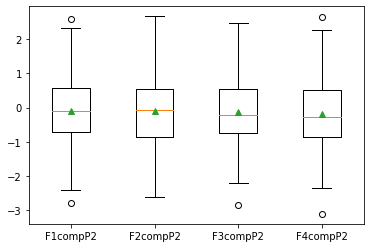

In [388]:
# Creating plot
plt.boxplot(df_box, showmeans = True)
plt.xticks([1, 2, 3, 4], ['F1compP2', 'F2compP2', 'F3compP2', 'F4compP2'])

In [99]:

# Perform the one-way ANOVA 
# Tests the null hypothesis that two or more
# groups have the same population mean


f_oneway(dataset_factors['F1compP2'], dataset_factors['F2compP2'], dataset_factors['F3compP2'], dataset_factors['F4compP2'])

NameError: name 'dataset_factors' is not defined

In [100]:
# The ANOVA Test has important assumptions that must be satistified
# in order for the associated P-Value to be valid

# We will use the Levene Test to determine if 
# the assumptions of the ANOVA table are met
# https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.f_oneway.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html


p = levene(dataset_factors['F1compP2'], dataset_factors['F2compP2'], dataset_factors['F3compP2'], dataset_factors['F4compP2'])    
p


NameError: name 'dataset_factors' is not defined

In [393]:
dataset_factors_use = df.merge(Clock_list,on = 'Clocks')
dataset_factors_use

Clocks  F1compP2  F2compP2  F3compP2  F4compP2 Scores
0    10098X  0.396002  0.868078  0.451179 -0.729966      0
1    10286Y  0.792556 -0.630638  0.904748 -0.785195      0
2    10294X  1.988744  0.705892  1.891007  0.835416      2
3    10348U -0.819512 -0.414752 -0.379585 -2.070531      2
4    10528W  1.043932 -0.255540  0.788534  0.838686      2
..      ...       ...       ...       ...       ...    ...
348  24160C -0.985130 -0.566078 -1.393219 -0.892061      2
349  24196X -1.222794 -1.192649 -0.664929 -0.932192      2
350  24205Y  0.067990 -2.257025 -0.196353 -1.515259      2
351  24555Z  0.356886 -0.348367  0.187666  0.204181      2
352  25340J -0.577903 -1.390396 -0.710814  0.085333      2

[353 rows x 6 columns]

In [102]:
df_f = dataset_factors_use.rename(columns = {'Scores':'Adjusted Clock Drawing Test Scores'})
df_f
df_f = dataset_factors_use.rename(columns = {'Adjusted Clock Drawing Test Scores':'Scores'})

In [103]:
# T-test Factor 1
sc.stats.ttest_ind(dataset_factors_use['Scores'], dataset_factors_use['F1compP2'])

Ttest_indResult(statistic=-2.404440350651133, pvalue=0.01845048951327176)

In [104]:
# ANOVA F1
F1_anova_model_s = ols('F1compP2 ~ C(Scores)', data=df_f).fit()
anova_table_F1_s = sm.stats.anova_lm(F1_anova_model_s, typ=1)
anova_table_F1_s

df     sum_sq   mean_sq   F  PR(>F)
C(Scores)   0.0   0.000000       NaN NaN     NaN
Residual   41.0  29.032608  0.708112 NaN     NaN

In [105]:
sp.posthoc_ttest(df_f, val_col = 'F1compP2', group_col = 'Scores', p_adjust='holm')

ZeroDivisionError: float division by zero

In [106]:
# T-test Factor 2
sc.stats.ttest_ind(dataset_factors_use['Scores'], dataset_factors_use['F2compP2'])

Ttest_indResult(statistic=-0.42166767065331595, pvalue=0.6743709810258112)

In [107]:
# ANOVA F2
F2_anova_model_s = ols('F2compP2 ~ C(Scores)', data=df_f).fit()
anova_table_F2_s = sm.stats.anova_lm(F2_anova_model_s, typ=1)
anova_table_F2_s

df     sum_sq   mean_sq   F  PR(>F)
C(Scores)   0.0   0.000000       NaN NaN     NaN
Residual   41.0  30.894797  0.753532 NaN     NaN

In [108]:
# T-test Factor 3
sc.stats.ttest_ind(dataset_factors_use['Scores'], dataset_factors_use['F3compP2'])

Ttest_indResult(statistic=-2.047960668474121, pvalue=0.04376401858754533)

In [109]:
# ANOVA F3
F3_anova_model_s = ols('F3compP2 ~ C(Scores)', data=df_f).fit()
anova_table_F3_s = sm.stats.anova_lm(F3_anova_model_s, typ=1)
anova_table_F3_s

df     sum_sq   mean_sq   F  PR(>F)
C(Scores)   0.0   0.000000       NaN NaN     NaN
Residual   41.0  29.595269  0.721836 NaN     NaN

In [110]:
# T-test Factor 4
sc.stats.ttest_ind(dataset_factors_use['Scores'], dataset_factors_use['F4compP2'])

Ttest_indResult(statistic=-0.5397559315640864, pvalue=0.5908281485962177)

In [111]:
# ANOVA F4
F4_anova_model_s = ols('F4compP2 ~ C(Scores)', data=df_f).fit()
anova_table_F4_s = sm.stats.anova_lm(F4_anova_model_s, typ=1)
anova_table_F4_s

df     sum_sq  mean_sq   F  PR(>F)
C(Scores)   0.0   0.000000      NaN NaN     NaN
Residual   41.0  38.669156  0.94315 NaN     NaN

Now, we will make adjustments for the Factor variables by incorporationg the Age, Gender, Race, Education, Income, and Kidney Disease variables

In [389]:
df_fac_adj = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Minicog_selected_variables.csv')
df_fac_adj



sid  age_final  gender_final  race_final  education_finalV1  \
0     10015T       69.9             1           1                  3   
1     10017X       77.6             1           1                  3   
2     10031R       71.7             1           1                  3   
3     10032T       71.1             2           1                  3   
4     10049K       60.0             1           2                  1   
...      ...        ...           ...         ...                ...   
1712  23634Q       66.1             2           1                  1   
1713  23696M       68.7             2           1                  3   
1714  23785L       66.9             1           1                  3   
1715  23793K       55.8             2           1                  3   
1716  24637B       68.1             1           1                  3   

      income_final  kidney_disease_final  goldstage_final_V2  
0                5                     0                   2  
1                4                     0                   2  
2                2                     0                   2  
3                2                     0                   2  
4                1                     0                   2  
...            ...                   ...                 ...  
1712             3                     0                   1  
1713             2                     0                   2  
1714             1                     0                   2  
1715             5                     0                   0  
1716             2                     0                   2  

[1717 rows x 8 columns]

In [430]:
B1 = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Book1.csv')
B1

sid  COPD_P3
0     10015T        1
1     10017X        1
2     10022Q        1
3     10025W        1
4     10031R        0
...      ...      ...
1989  23696M        1
1990  23785L        1
1991  23793K        0
1992  24637B        0
1993  25416Q        1

[1994 rows x 2 columns]

In [390]:
df_fac_adj

sid  age_final  gender_final  race_final  education_finalV1  \
0     10015T       69.9             1           1                  3   
1     10017X       77.6             1           1                  3   
2     10031R       71.7             1           1                  3   
3     10032T       71.1             2           1                  3   
4     10049K       60.0             1           2                  1   
...      ...        ...           ...         ...                ...   
1712  23634Q       66.1             2           1                  1   
1713  23696M       68.7             2           1                  3   
1714  23785L       66.9             1           1                  3   
1715  23793K       55.8             2           1                  3   
1716  24637B       68.1             1           1                  3   

      income_final  kidney_disease_final  goldstage_final_V2  
0                5                     0                   2  
1                4                     0                   2  
2                2                     0                   2  
3                2                     0                   2  
4                1                     0                   2  
...            ...                   ...                 ...  
1712             3                     0                   1  
1713             2                     0                   2  
1714             1                     0                   2  
1715             5                     0                   0  
1716             2                     0                   2  

[1717 rows x 8 columns]

In [114]:
dataset_factors_use

Clocks  F1compP2  F2compP2  F3compP2  F4compP2 Scores
0   10098X  0.396002  0.868078  0.451179 -0.729966      0
1   10286Y  0.792556 -0.630638  0.904748 -0.785195      0
2   10796V  0.667201 -0.269795  0.928741  1.774383      0
3   12281Y  0.781732  0.491166  0.584655  0.759469      0
4   12343U  0.012340  0.082806 -0.323906 -0.060235      0
5   13083Z  0.136775  0.604984  0.261665  0.909699      0
6   13384N  0.085730  0.470285  0.325569  0.030117      0
7   13484R  0.834276 -0.028157  1.110327  1.026943      0
8   13610W  0.713851  0.482236  0.801969  1.770297      0
9   13937C  0.437493 -0.450963  0.362679  0.934088      0
10  14486A -0.864085 -1.019094 -0.753519 -0.500678      0
11  14545Q  1.212988  0.354166  1.016279  0.247180      0
12  15044Z -0.126046 -0.577395 -0.300687  0.549455      0
13  15082H  0.796079  1.127933  0.532250  1.256171      0
14  15101L -0.335524 -1.327074 -0.176607 -0.803219      0
15  16470V  0.140967  0.248432  0.227176  0.827360      0
16  16830Z -0.076167  0.355262 -0.326202 -0.308485      0
17  16873R  2.310415  0.550813  2.460517  1.891373      0
18  16974X  0.985111  0.100505  0.832637  0.715214      0
19  17147T -1.882266 -0.519316 -1.858001 -1.241448      0
20  17387N -0.332487 -0.736653 -0.532372 -1.125639      0
21  17419A -0.502296 -0.684453 -0.805136 -0.117094      0
22  17693U  1.650146 -0.794908  1.418896  0.983121      0
23  17701T  2.290672  0.489100  2.079949  1.009885      0
24  17725H  0.811392  1.181442  1.034669 -0.810863      0
25  18370B  0.252313  1.028942 -0.040538 -0.763199      0
26  18444E  1.046858 -0.869457  0.801484  0.148569      0
27  19294Q  0.948086  1.129808  0.635186 -0.252888      0
28  19318E  0.454480 -0.022247  0.326741  0.320592      0
29  19322V  0.200389 -1.014774 -0.095076 -0.775389      0
30  19329J  0.679127 -0.970407  0.556299 -0.793678      0
31  19462L  0.271468  0.843637  0.301413 -0.966840      0
32  19507H -0.167578  2.257949  0.215758 -0.237496      0
33  19601Z -1.093807 -1.064788 -1.369073  0.945972      0
34  19960B -0.988867  0.868850 -0.373416  1.104066      0
35  20977F -0.484713 -1.231732 -0.502537 -0.632326      0
36  21075W  0.791603 -1.205711  0.884088 -0.534921      0
37  21111A -0.892767  1.128636 -1.073224 -2.255089      0
38  21304L -0.441328 -0.834072 -0.655279 -1.190622      0
39  21518E  0.171660  0.942151  0.131924  0.559219      0
40  22660M  0.530949 -0.142160  0.228263 -0.803644      0
41  23349R  0.897902  1.158782  1.046781  1.322871      0

In [394]:
df_fac_adj = df_fac_adj.rename(columns = {'sid' : 'Subject IDs'})

In [395]:
dataset_factors_use = dataset_factors_use.rename(columns = {'Clocks' : 'Subject IDs', 'Scores': 'Adjusted Clock Drawing Test Score'})

In [117]:
np.save(r'C:/Users/12563/Documents/dataset_factors_use.npy', dataset_factors_use )

In [396]:
df_fac_adj_ana = dataset_factors_use.merge(df_fac_adj,on = 'Subject IDs')


In [431]:
df_fac_adj_ana = df_fac_adj_ana.rename(columns = {'kidney_disease_final':'Kidney Disease', 'Final GOLD':'goldstage_final_V2', 'Subject IDs':'sid'})

In [417]:
df_fac_adj_ana

Subject IDs  F1compP2  F2compP2  F3compP2  F4compP2  \
0        10098X  0.396002  0.868078  0.451179 -0.729966   
1        10286Y  0.792556 -0.630638  0.904748 -0.785195   
2        10348U -0.819512 -0.414752 -0.379585 -2.070531   
3        10528W  1.043932 -0.255540  0.788534  0.838686   
4        10647E  1.361600  0.373160  1.250930  0.534924   
..          ...       ...       ...       ...       ...   
239      23478C -0.905084  1.815225 -0.993261 -0.841087   
240      23619U  0.723385  0.281395  0.804737 -0.071033   
241      23634Q -0.533470 -0.131728 -0.553965  0.532302   
242      23696M  0.588938  0.027792  0.611599 -0.032716   
243      23785L  0.771995  1.026923  1.211564  1.812055   

    Adjusted Clock Drawing Test Score  age_final  gender_final  race_final  \
0                                   0       88.3             2           1   
1                                   0       59.6             2           2   
2                                   2       84.1             1           1   
3                                   2       85.7             1           1   
4                                   2       77.8             2           1   
..                                ...        ...           ...         ...   
239                                 2       59.8             2           1   
240                                 2       62.5             2           1   
241                                 2       66.1             2           1   
242                                 2       68.7             2           1   
243                                 2       66.9             1           1   

     education_finalV1  income_final  Kidney Disease  goldstage_final_V2  
0                    3             3               0                   2  
1                    3             4               0                   2  
2                    3             5               0                   0  
3                    3             5               1                   2  
4                    3             2               0                   2  
..                 ...           ...             ...                 ...  
239                  3             5               0                   0  
240                  3             3               0                   2  
241                  1             3               0                   1  
242                  3             2               0                   2  
243                  3             1               0                   2  

[244 rows x 13 columns]

In [480]:
B1


sid  COPD_P3
0     10015T        1
1     10017X        1
2     10022Q        1
3     10025W        1
4     10031R        0
...      ...      ...
1989  23696M        1
1990  23785L        1
1991  23793K        0
1992  24637B        0
1993  25416Q        1

[1994 rows x 2 columns]

In [438]:
df_b = B1.merge(df_fac_adj_ana,on = 'sid')
df_b

sid  COPD_P3  F1compP2  F2compP2  F3compP2  F4compP2  \
0    10098X        0  0.396002  0.868078  0.451179 -0.729966   
1    10286Y        0  0.792556 -0.630638  0.904748 -0.785195   
2    10348U        0 -0.819512 -0.414752 -0.379585 -2.070531   
3    10528W        1  1.043932 -0.255540  0.788534  0.838686   
4    10647E        1  1.361600  0.373160  1.250930  0.534924   
..      ...      ...       ...       ...       ...       ...   
239  23478C        0 -0.905084  1.815225 -0.993261 -0.841087   
240  23619U        0  0.723385  0.281395  0.804737 -0.071033   
241  23634Q        0 -0.533470 -0.131728 -0.553965  0.532302   
242  23696M        1  0.588938  0.027792  0.611599 -0.032716   
243  23785L        1  0.771995  1.026923  1.211564  1.812055   

    Adjusted Clock Drawing Test Score  age_final  gender_final  race_final  \
0                                   0       88.3             2           1   
1                                   0       59.6             2           2   
2                                   2       84.1             1           1   
3                                   2       85.7             1           1   
4                                   2       77.8             2           1   
..                                ...        ...           ...         ...   
239                                 2       59.8             2           1   
240                                 2       62.5             2           1   
241                                 2       66.1             2           1   
242                                 2       68.7             2           1   
243                                 2       66.9             1           1   

     education_finalV1  income_final  Kidney Disease  goldstage_final_V2  
0                    3             3               0                   2  
1                    3             4               0                   2  
2                    3             5               0                   0  
3                    3             5               1                   2  
4                    3             2               0                   2  
..                 ...           ...             ...                 ...  
239                  3             5               0                   0  
240                  3             3               0                   2  
241                  1             3               0                   1  
242                  3             2               0                   2  
243                  3             1               0                   2  

[244 rows x 14 columns]

In [444]:
(np.sum(df_b['goldstage_final_V2'] == 0))

114

In [399]:
df_fac_adj_ana.describe()

F1compP2    F2compP2    F3compP2    F4compP2   age_final  \
count  244.000000  244.000000  244.000000  244.000000  244.000000   
mean    -0.151605   -0.096032   -0.204135   -0.295349   67.838115   
std      0.921595    0.920138    0.930358    0.981578    8.313353   
min     -2.782084   -2.605346   -2.838256   -3.103809   54.300000   
25%     -0.822034   -0.857724   -0.801722   -0.963218   60.800000   
50%     -0.184747   -0.078491   -0.324423   -0.420237   67.450000   
75%      0.515312    0.516179    0.445987    0.354535   73.225000   
max      2.589598    2.663237    2.419479    2.248553   90.900000   

       gender_final  race_final  education_finalV1  income_final  \
count    244.000000  244.000000         244.000000    244.000000   
mean       1.504098    1.274590           2.581967      3.409836   
std        0.501011    0.447225           0.670853      1.693629   
min        1.000000    1.000000           1.000000      1.000000   
25%        1.000000    1.000000           2.000000      2.000000   
50%        2.000000    1.000000           3.000000      3.000000   
75%        2.000000    2.000000           3.000000      5.000000   
max        2.000000    2.000000           3.000000      6.000000   

       Kidney Disease  Final GOLD  
count      244.000000  244.000000  
mean         0.057377    0.967213  
std          0.233040    0.950931  
min          0.000000    0.000000  
25%          0.000000    0.000000  
50%          0.000000    1.000000  
75%          0.000000    2.000000  
max          1.000000    2.000000

In [418]:
# We must create Dummy variables for the Categorical Variables

df_numeric = pd.get_dummies(df_fac_adj_ana, columns = ['gender_final', 'race_final', 'education_finalV1', 'income_final',  'goldstage_final_V2'])

In [421]:
df_numeric.describe()

F1compP2    F2compP2    F3compP2    F4compP2   age_final  \
count  244.000000  244.000000  244.000000  244.000000  244.000000   
mean    -0.151605   -0.096032   -0.204135   -0.295349   67.838115   
std      0.921595    0.920138    0.930358    0.981578    8.313353   
min     -2.782084   -2.605346   -2.838256   -3.103809   54.300000   
25%     -0.822034   -0.857724   -0.801722   -0.963218   60.800000   
50%     -0.184747   -0.078491   -0.324423   -0.420237   67.450000   
75%      0.515312    0.516179    0.445987    0.354535   73.225000   
max      2.589598    2.663237    2.419479    2.248553   90.900000   

       Kidney Disease  gender_final_1  gender_final_2  race_final_1  \
count      244.000000      244.000000      244.000000    244.000000   
mean         0.057377        0.495902        0.504098      0.725410   
std          0.233040        0.501011        0.501011      0.447225   
min          0.000000        0.000000        0.000000      0.000000   
25%          0.000000        0.000000        0.000000      0.000000   
50%          0.000000        0.000000        1.000000      1.000000   
75%          0.000000        1.000000        1.000000      1.000000   
max          1.000000        1.000000        1.000000      1.000000   

       race_final_2  ...  education_finalV1_3  income_final_1  income_final_2  \
count    244.000000  ...           244.000000      244.000000      244.000000   
mean       0.274590  ...             0.684426        0.168033        0.180328   
std        0.447225  ...             0.465699        0.374664        0.385251   
min        0.000000  ...             0.000000        0.000000        0.000000   
25%        0.000000  ...             0.000000        0.000000        0.000000   
50%        0.000000  ...             1.000000        0.000000        0.000000   
75%        1.000000  ...             1.000000        0.000000        0.000000   
max        1.000000  ...             1.000000        1.000000        1.000000   

       income_final_3  income_final_4  income_final_5  income_final_6  \
count      244.000000      244.000000      244.000000      244.000000   
mean         0.188525        0.159836        0.143443        0.159836   
std          0.391934        0.367207        0.351244        0.367207   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000        1.000000   

       goldstage_final_V2_0  goldstage_final_V2_1  goldstage_final_V2_2  
count            244.000000            244.000000            244.000000  
mean               0.467213              0.098361              0.434426  
std                0.499949              0.298414              0.496700  
min                0.000000              0.000000              0.000000  
25%                0.000000              0.000000              0.000000  
50%                0.000000              0.000000              0.000000  
75%                1.000000              0.000000              1.000000  
max                1.000000              1.000000              1.000000  

[8 rows x 22 columns]

In [420]:
df_numeric

Subject IDs  F1compP2  F2compP2  F3compP2  F4compP2  \
0        10098X  0.396002  0.868078  0.451179 -0.729966   
1        10286Y  0.792556 -0.630638  0.904748 -0.785195   
2        10348U -0.819512 -0.414752 -0.379585 -2.070531   
3        10528W  1.043932 -0.255540  0.788534  0.838686   
4        10647E  1.361600  0.373160  1.250930  0.534924   
..          ...       ...       ...       ...       ...   
239      23478C -0.905084  1.815225 -0.993261 -0.841087   
240      23619U  0.723385  0.281395  0.804737 -0.071033   
241      23634Q -0.533470 -0.131728 -0.553965  0.532302   
242      23696M  0.588938  0.027792  0.611599 -0.032716   
243      23785L  0.771995  1.026923  1.211564  1.812055   

    Adjusted Clock Drawing Test Score  age_final  Kidney Disease  \
0                                   0       88.3               0   
1                                   0       59.6               0   
2                                   2       84.1               0   
3                                   2       85.7               1   
4                                   2       77.8               0   
..                                ...        ...             ...   
239                                 2       59.8               0   
240                                 2       62.5               0   
241                                 2       66.1               0   
242                                 2       68.7               0   
243                                 2       66.9               0   

     gender_final_1  gender_final_2  ...  education_finalV1_3  income_final_1  \
0                 0               1  ...                    1               0   
1                 0               1  ...                    1               0   
2                 1               0  ...                    1               0   
3                 1               0  ...                    1               0   
4                 0               1  ...                    1               0   
..              ...             ...  ...                  ...             ...   
239               0               1  ...                    1               0   
240               0               1  ...                    1               0   
241               0               1  ...                    0               0   
242               0               1  ...                    1               0   
243               1               0  ...                    1               1   

     income_final_2  income_final_3  income_final_4  income_final_5  \
0                 0               1               0               0   
1                 0               0               1               0   
2                 0               0               0               1   
3                 0               0               0               1   
4                 1               0               0               0   
..              ...             ...             ...             ...   
239               0               0               0               1   
240               0               1               0               0   
241               0               1               0               0   
242               1               0               0               0   
243               0               0               0               0   

     income_final_6  goldstage_final_V2_0  goldstage_final_V2_1  \
0                 0                     0                     0   
1                 0                     0                     0   
2                 0                     1                     0   
3                 0                     0                     0   
4                 0                     0                     0   
..              ...                   ...                   ...   
239               0                     1                     0   
240               0                     0                     0   
241               0                     0        

In [122]:
df_fac_adj_ana = df_fac_adj_ana.rename(columns = {'Adjusted Clock Drawing Test Score':'Score', 'Kidney Disease' : 'kidney_disease_final', 'Final GOLD':'goldstage_final_V2'})

In [123]:
# F1 ANOVA
# w/o GOLD
F1_anova_model = ols('F1compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final)', data=df_fac_adj_ana).fit()
anova_table_F1 = sm.stats.anova_lm(F1_anova_model, typ=1)
anova_table_F1

df     sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0   0.000000       NaN       NaN       NaN
C(gender_final)           1.0   1.274757  1.274757  1.808841  0.193702
C(race_final)             1.0   0.166584  0.166584  0.236377  0.632120
C(education_finalV1)      2.0   0.597787  0.298893  0.424121  0.660094
C(income_final)           5.0   1.147872  0.229574  0.325759  0.891491
C(kidney_disease_final)   1.0   1.469454  1.469454  2.085110  0.164225
age_final                 1.0   0.893655  0.893655  1.268070  0.273461
Residual                 20.0  14.094737  0.704737       NaN       NaN

In [124]:
# F1 ANOVA
# w/ GOLD
F1_anova_model_g = ols('F1compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final) + C(goldstage_final_V2)', data=df_fac_adj_ana).fit()
anova_table_F1_g = sm.stats.anova_lm(F1_anova_model_g, typ=1)
anova_table_F1_g

df    sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0  0.000000       NaN       NaN       NaN
C(gender_final)           1.0  1.274757  1.274757  2.865376  0.107741
C(race_final)             1.0  0.166584  0.166584  0.374444  0.548244
C(education_finalV1)      2.0  0.597787  0.298893  0.671847  0.523116
C(income_final)           5.0  1.147872  0.229574  0.516033  0.760776
C(kidney_disease_final)   1.0  1.469454  1.469454  3.303013  0.085839
C(goldstage_final_V2)     2.0  6.913737  3.456868  7.770289  0.003692
age_final                 1.0  0.066765  0.066765  0.150073  0.703008
Residual                 18.0  8.007891  0.444883       NaN       NaN

In [125]:
# F2 ANOVA
F2_anova_model = ols('F2compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final)', data=df_fac_adj_ana).fit()
anova_table_F2 = sm.stats.anova_lm(F2_anova_model, typ=1)
anova_table_F2

df     sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0   0.000000       NaN       NaN       NaN
C(gender_final)           1.0   0.002337  0.002337  0.003626  0.952580
C(race_final)             1.0   1.939509  1.939509  3.009282  0.098175
C(education_finalV1)      2.0   2.086074  1.043037  1.618343  0.223130
C(income_final)           5.0   2.030142  0.406028  0.629981  0.679040
C(kidney_disease_final)   1.0   0.114407  0.114407  0.177510  0.678016
age_final                 1.0   0.995313  0.995313  1.544296  0.228353
Residual                 20.0  12.890180  0.644509       NaN       NaN

In [126]:
# F2 ANOVA
# w/ GOLD
F2_anova_model_g = ols('F2compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final) + C(goldstage_final_V2)', data=df_fac_adj_ana).fit()
anova_table_F2_g = sm.stats.anova_lm(F2_anova_model_g, typ=1)
anova_table_F2_g

df     sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0   0.000000       NaN       NaN       NaN
C(gender_final)           1.0   0.002337  0.002337  0.003302  0.954810
C(race_final)             1.0   1.939509  1.939509  2.740160  0.115185
C(education_finalV1)      2.0   2.086074  1.043037  1.473614  0.255454
C(income_final)           5.0   2.030142  0.406028  0.573641  0.719435
C(kidney_disease_final)   1.0   0.114407  0.114407  0.161635  0.692390
C(goldstage_final_V2)     2.0   0.062049  0.031025  0.043832  0.957217
age_final                 1.0   1.082885  1.082885  1.529912  0.232021
Residual                 18.0  12.740558  0.707809       NaN       NaN

In [127]:
# F3 ANOVA
# Gas-Trapping
F3_anova_model = ols('F3compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final)', data=df_fac_adj_ana).fit()
anova_table_F3 = sm.stats.anova_lm(F3_anova_model, typ=1)
anova_table_F3

df     sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0   0.000000       NaN       NaN       NaN
C(gender_final)           1.0   0.626106  0.626106  0.999544  0.329364
C(race_final)             1.0   0.114157  0.114157  0.182245  0.674012
C(education_finalV1)      2.0   1.565438  0.782719  1.249568  0.308064
C(income_final)           5.0   1.137725  0.227545  0.363263  0.867569
C(kidney_disease_final)   1.0   1.483315  1.483315  2.368030  0.139515
age_final                 1.0   1.167420  1.167420  1.863722  0.187357
Residual                 20.0  12.527833  0.626392       NaN       NaN

In [128]:
# F3 ANOVA
# w/ GOLD
F3_anova_model_g = ols('F3compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final) + C(goldstage_final_V2)', data=df_fac_adj_ana).fit()
anova_table_F3_g = sm.stats.anova_lm(F3_anova_model_g, typ=1)
anova_table_F3_g

df    sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0  0.000000       NaN       NaN       NaN
C(gender_final)           1.0  0.626106  0.626106  1.421208  0.248685
C(race_final)             1.0  0.114157  0.114157  0.259126  0.616905
C(education_finalV1)      2.0  1.565438  0.782719  1.776706  0.197610
C(income_final)           5.0  1.137725  0.227545  0.516508  0.760435
C(kidney_disease_final)   1.0  1.483315  1.483315  3.366999  0.083096
C(goldstage_final_V2)     2.0  5.763795  2.881897  6.541664  0.007323
age_final                 1.0  0.001649  0.001649  0.003743  0.951889
Residual                 18.0  7.929810  0.440545       NaN       NaN

In [129]:
# F4 ANOVA
# TLC FRC
F4_anova_model = ols('F4compP2 ~ C(Score) + age_final + C(gender_final) + C(race_final) + C(education_finalV1) + C(income_final) + C(kidney_disease_final)', data=df_fac_adj_ana).fit()
anova_table_F4 = sm.stats.anova_lm(F4_anova_model, typ=1)
anova_table_F4

df     sum_sq   mean_sq         F    PR(>F)
C(Score)                  0.0   0.000000       NaN       NaN       NaN
C(gender_final)           1.0   0.028950  0.028950  0.031940  0.859958
C(race_final)             1.0   0.085188  0.085188  0.093988  0.762336
C(education_finalV1)      2.0   5.020543  2.510271  2.769578  0.086743
C(income_final)           5.0   2.556488  0.511298  0.564114  0.726337
C(kidney_disease_final)   1.0   1.472984  1.472984  1.625141  0.216988
age_final                 1.0   3.315446  3.315446  3.657926  0.070232
Residual                 20.0  18.127463  0.906373       NaN       NaN

In [130]:
dataset_factors_use

Subject IDs  F1compP2  F2compP2  F3compP2  F4compP2  \
0       10098X  0.396002  0.868078  0.451179 -0.729966   
1       10286Y  0.792556 -0.630638  0.904748 -0.785195   
2       10796V  0.667201 -0.269795  0.928741  1.774383   
3       12281Y  0.781732  0.491166  0.584655  0.759469   
4       12343U  0.012340  0.082806 -0.323906 -0.060235   
5       13083Z  0.136775  0.604984  0.261665  0.909699   
6       13384N  0.085730  0.470285  0.325569  0.030117   
7       13484R  0.834276 -0.028157  1.110327  1.026943   
8       13610W  0.713851  0.482236  0.801969  1.770297   
9       13937C  0.437493 -0.450963  0.362679  0.934088   
10      14486A -0.864085 -1.019094 -0.753519 -0.500678   
11      14545Q  1.212988  0.354166  1.016279  0.247180   
12      15044Z -0.126046 -0.577395 -0.300687  0.549455   
13      15082H  0.796079  1.127933  0.532250  1.256171   
14      15101L -0.335524 -1.327074 -0.176607 -0.803219   
15      16470V  0.140967  0.248432  0.227176  0.827360   
16      16830Z -0.076167  0.355262 -0.326202 -0.308485   
17      16873R  2.310415  0.550813  2.460517  1.891373   
18      16974X  0.985111  0.100505  0.832637  0.715214   
19      17147T -1.882266 -0.519316 -1.858001 -1.241448   
20      17387N -0.332487 -0.736653 -0.532372 -1.125639   
21      17419A -0.502296 -0.684453 -0.805136 -0.117094   
22      17693U  1.650146 -0.794908  1.418896  0.983121   
23      17701T  2.290672  0.489100  2.079949  1.009885   
24      17725H  0.811392  1.181442  1.034669 -0.810863   
25      18370B  0.252313  1.028942 -0.040538 -0.763199   
26      18444E  1.046858 -0.869457  0.801484  0.148569   
27      19294Q  0.948086  1.129808  0.635186 -0.252888   
28      19318E  0.454480 -0.022247  0.326741  0.320592   
29      19322V  0.200389 -1.014774 -0.095076 -0.775389   
30      19329J  0.679127 -0.970407  0.556299 -0.793678   
31      19462L  0.271468  0.843637  0.301413 -0.966840   
32      19507H -0.167578  2.257949  0.215758 -0.237496   
33      19601Z -1.093807 -1.064788 -1.369073  0.945972   
34      19960B -0.988867  0.868850 -0.373416  1.104066   
35      20977F -0.484713 -1.231732 -0.502537 -0.632326   
36      21075W  0.791603 -1.205711  0.884088 -0.534921   
37      21111A -0.892767  1.128636 -1.073224 -2.255089   
38      21304L -0.441328 -0.834072 -0.655279 -1.190622   
39      21518E  0.171660  0.942151  0.131924  0.559219   
40      22660M  0.530949 -0.142160  0.228263 -0.803644   
41      23349R  0.897902  1.158782  1.046781  1.322871   

   Adjusted Clock Drawing Test Score  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  
5                                  0  
6                                  0  
7                                  0  
8                                  0  
9                                  0  
10                                 0  
11                                 0  
12                                 0  
13                                 0  
14                                 0  
15                                 0  
16                                 0  
17                                 0  
18                                 0  
19                                 0  
20                                 0  
21                                 0  
22                                 0  
23                                 0  
24                                 0  
25                                 0  
26                                 0  
27                                 0  
28                                 0  
29                                 0  
30                                 0  
31                                 0  
32                                 0  
33                                 0  
34                                 0  
35                                 0  
36                                 0  
37                        

In [131]:

dataset_factors_use.to_csv('C:/Users/12563/Documents/raw_data.csv', index=False)

In [132]:
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn import linear_model
from sklearn import datasets, linear_model
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

# Create the Feature Matrix X
X_reg = dataset_factors_use.iloc[:, 1:5].values
#X_reg = dataset_factors_use.drop(columns = ['Clocks', 'Scores'])
#X_reg = X_reg.astype(np.float)
#X_reg = np.array([[value,float(1)] for value in X_reg ]) 
#X_reg = X_reg.astype(np.float64)
# Create Target Vector
y_reg = dataset_factors_use['Scores']
y_reg = np.array(y_reg)

KeyError: 'Scores'

In [133]:
model = LinearRegression().fit(X_reg, y_reg)

NameError: name 'y_reg' is not defined

In [134]:
r_sq = model.score(X_reg, y_reg)
r_sq

AttributeError: 'OLSResults' object has no attribute 'score'

In [135]:
# X_reg = np.array(X_reg, dtype = np.float)
# X_reg = X_reg.flatten()
X_reg = np.array(X_reg).reshape((-1,1))

In [136]:
X_reg

array([[ 0.3960016 ],
       [ 0.86807832],
       [ 0.45117914],
       [-0.72996642],
       [ 0.79255593],
       [-0.63063755],
       [ 0.90474801],
       [-0.78519507],
       [ 0.66720122],
       [-0.26979509],
       [ 0.92874139],
       [ 1.77438329],
       [ 0.78173249],
       [ 0.49116564],
       [ 0.58465496],
       [ 0.75946894],
       [ 0.01234024],
       [ 0.08280624],
       [-0.32390598],
       [-0.06023518],
       [ 0.1367747 ],
       [ 0.60498385],
       [ 0.2616655 ],
       [ 0.90969897],
       [ 0.0857302 ],
       [ 0.47028496],
       [ 0.32556948],
       [ 0.03011713],
       [ 0.83427612],
       [-0.02815742],
       [ 1.11032687],
       [ 1.02694311],
       [ 0.71385106],
       [ 0.48223561],
       [ 0.80196915],
       [ 1.7702971 ],
       [ 0.43749281],
       [-0.45096319],
       [ 0.36267949],
       [ 0.93408766],
       [-0.8640854 ],
       [-1.01909404],
       [-0.75351945],
       [-0.5006775 ],
       [ 1.21298764],
       [ 0

In [137]:
type(X_reg)

numpy.ndarray

In [138]:
X2

NameError: name 'X2' is not defined

In [139]:
# X2 = sm.add_constant(X_reg)
# X2 = np.array(X2, dtype = float)
est = sm.OLS(y_reg, X_reg)
est2 = est.fit()
print(est2.summary())

NameError: name 'y_reg' is not defined

In [140]:
X_reg_2 = sma.add_constant(X_reg)
model = sma.OLS(y_reg, X_reg_2)
fii = model.fit()

print(fii.summary())

NameError: name 'y_reg' is not defined

In [141]:
type(X_reg)

numpy.ndarray

In [142]:
# Split the data into train and test sets (80/20) split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size= 0.2, train_size=0.8, random_state=33)

NameError: name 'y_reg' is not defined

In [143]:
# Create Linear Regression Object
regr = LinearRegression()

#pipe = Pipeline(steps=[('regr', LinearRegression(fit_intercept=False))])

In [144]:
# Train the model using the training set
lin_reg = regr.fit(X_train_r, y_train_r)
lin_reg

NameError: name 'X_train_r' is not defined

In [145]:
# Data Frame containing the estimated coefficients
# obtained from the Regression Model

coeff_df = pd.DataFrame(regr.coef_, index = ['F1compP2', 'F2compP2', 'F3compP2', 'F4compP2'], columns = ['Estimated Coefficients'])
coeff_df

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [146]:
print(lin_reg.summary())

NameError: name 'lin_reg' is not defined

In [147]:
# Using the Test Data, Holdout Data to evaluate the trained 
# model for predicting a patients score on the Clock
# Drawing Test

In [148]:
# Make predictions using the testing set
y_pred_r = regr.predict(X_test_r)


NameError: name 'X_test_r' is not defined

In [149]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_r, y_pred_r))

NameError: name 'y_test_r' is not defined

The smaller the MSE, the smaller the error. Thus, the better our estimator is.

In [150]:
print(r2_score(y_test_r, y_pred_r))

NameError: name 'r2_score' is not defined

In [151]:
r2_score = regr.score(X_test_r,y_test_r)
print(r2_score*100,'%')

NameError: name 'X_test_r' is not defined

In [152]:
plt.scatter(y_test_r,y_pred_r);
plt.xlabel('Actual');
plt.ylabel('Predicted');

NameError: name 'y_test_r' is not defined

In [153]:
## plotting residual errors in training data
plt.scatter(pipe.predict(X_train_r), pipe.predict(X_train_r) - y_train_r,
            color = "green", s = 10, label = 'Train data')

## plotting residual errors in test data
plt.scatter(pipe.predict(X_test_r), pipe.predict(X_test_r) - y_test_r,
            color = "blue", s = 10, label = 'Test data')

## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 2, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()

NameError: name 'pipe' is not defined

In [154]:
plt.scatter(X_test_r, y_test_r, color="black")

NameError: name 'X_test_r' is not defined

In [155]:
dataset_factors_use

Subject IDs  F1compP2  F2compP2  F3compP2  F4compP2  \
0       10098X  0.396002  0.868078  0.451179 -0.729966   
1       10286Y  0.792556 -0.630638  0.904748 -0.785195   
2       10796V  0.667201 -0.269795  0.928741  1.774383   
3       12281Y  0.781732  0.491166  0.584655  0.759469   
4       12343U  0.012340  0.082806 -0.323906 -0.060235   
5       13083Z  0.136775  0.604984  0.261665  0.909699   
6       13384N  0.085730  0.470285  0.325569  0.030117   
7       13484R  0.834276 -0.028157  1.110327  1.026943   
8       13610W  0.713851  0.482236  0.801969  1.770297   
9       13937C  0.437493 -0.450963  0.362679  0.934088   
10      14486A -0.864085 -1.019094 -0.753519 -0.500678   
11      14545Q  1.212988  0.354166  1.016279  0.247180   
12      15044Z -0.126046 -0.577395 -0.300687  0.549455   
13      15082H  0.796079  1.127933  0.532250  1.256171   
14      15101L -0.335524 -1.327074 -0.176607 -0.803219   
15      16470V  0.140967  0.248432  0.227176  0.827360   
16      16830Z -0.076167  0.355262 -0.326202 -0.308485   
17      16873R  2.310415  0.550813  2.460517  1.891373   
18      16974X  0.985111  0.100505  0.832637  0.715214   
19      17147T -1.882266 -0.519316 -1.858001 -1.241448   
20      17387N -0.332487 -0.736653 -0.532372 -1.125639   
21      17419A -0.502296 -0.684453 -0.805136 -0.117094   
22      17693U  1.650146 -0.794908  1.418896  0.983121   
23      17701T  2.290672  0.489100  2.079949  1.009885   
24      17725H  0.811392  1.181442  1.034669 -0.810863   
25      18370B  0.252313  1.028942 -0.040538 -0.763199   
26      18444E  1.046858 -0.869457  0.801484  0.148569   
27      19294Q  0.948086  1.129808  0.635186 -0.252888   
28      19318E  0.454480 -0.022247  0.326741  0.320592   
29      19322V  0.200389 -1.014774 -0.095076 -0.775389   
30      19329J  0.679127 -0.970407  0.556299 -0.793678   
31      19462L  0.271468  0.843637  0.301413 -0.966840   
32      19507H -0.167578  2.257949  0.215758 -0.237496   
33      19601Z -1.093807 -1.064788 -1.369073  0.945972   
34      19960B -0.988867  0.868850 -0.373416  1.104066   
35      20977F -0.484713 -1.231732 -0.502537 -0.632326   
36      21075W  0.791603 -1.205711  0.884088 -0.534921   
37      21111A -0.892767  1.128636 -1.073224 -2.255089   
38      21304L -0.441328 -0.834072 -0.655279 -1.190622   
39      21518E  0.171660  0.942151  0.131924  0.559219   
40      22660M  0.530949 -0.142160  0.228263 -0.803644   
41      23349R  0.897902  1.158782  1.046781  1.322871   

   Adjusted Clock Drawing Test Score  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  
5                                  0  
6                                  0  
7                                  0  
8                                  0  
9                                  0  
10                                 0  
11                                 0  
12                                 0  
13                                 0  
14                                 0  
15                                 0  
16                                 0  
17                                 0  
18                                 0  
19                                 0  
20                                 0  
21                                 0  
22                                 0  
23                                 0  
24                                 0  
25                                 0  
26                                 0  
27                                 0  
28                                 0  
29                                 0  
30                                 0  
31                                 0  
32                                 0  
33                                 0  
34                                 0  
35                                 0  
36                                 0  
37                        

In [156]:
# Now we will perform a KNN 
# Using the Factors to label the Adjusted Clock Drawing Test Score

df_knn_factors = pd.DataFrame(dataset_factors_use, columns = ['F1compP2', 'F2compP2', 'F3compP2', 'F4compP2', 'Scores'])
df_knn_factors

F1compP2  F2compP2  F3compP2  F4compP2  Scores
0   0.396002  0.868078  0.451179 -0.729966     NaN
1   0.792556 -0.630638  0.904748 -0.785195     NaN
2   0.667201 -0.269795  0.928741  1.774383     NaN
3   0.781732  0.491166  0.584655  0.759469     NaN
4   0.012340  0.082806 -0.323906 -0.060235     NaN
5   0.136775  0.604984  0.261665  0.909699     NaN
6   0.085730  0.470285  0.325569  0.030117     NaN
7   0.834276 -0.028157  1.110327  1.026943     NaN
8   0.713851  0.482236  0.801969  1.770297     NaN
9   0.437493 -0.450963  0.362679  0.934088     NaN
10 -0.864085 -1.019094 -0.753519 -0.500678     NaN
11  1.212988  0.354166  1.016279  0.247180     NaN
12 -0.126046 -0.577395 -0.300687  0.549455     NaN
13  0.796079  1.127933  0.532250  1.256171     NaN
14 -0.335524 -1.327074 -0.176607 -0.803219     NaN
15  0.140967  0.248432  0.227176  0.827360     NaN
16 -0.076167  0.355262 -0.326202 -0.308485     NaN
17  2.310415  0.550813  2.460517  1.891373     NaN
18  0.985111  0.100505  0.832637  0.715214     NaN
19 -1.882266 -0.519316 -1.858001 -1.241448     NaN
20 -0.332487 -0.736653 -0.532372 -1.125639     NaN
21 -0.502296 -0.684453 -0.805136 -0.117094     NaN
22  1.650146 -0.794908  1.418896  0.983121     NaN
23  2.290672  0.489100  2.079949  1.009885     NaN
24  0.811392  1.181442  1.034669 -0.810863     NaN
25  0.252313  1.028942 -0.040538 -0.763199     NaN
26  1.046858 -0.869457  0.801484  0.148569     NaN
27  0.948086  1.129808  0.635186 -0.252888     NaN
28  0.454480 -0.022247  0.326741  0.320592     NaN
29  0.200389 -1.014774 -0.095076 -0.775389     NaN
30  0.679127 -0.970407  0.556299 -0.793678     NaN
31  0.271468  0.843637  0.301413 -0.966840     NaN
32 -0.167578  2.257949  0.215758 -0.237496     NaN
33 -1.093807 -1.064788 -1.369073  0.945972     NaN
34 -0.988867  0.868850 -0.373416  1.104066     NaN
35 -0.484713 -1.231732 -0.502537 -0.632326     NaN
36  0.791603 -1.205711  0.884088 -0.534921     NaN
37 -0.892767  1.128636 -1.073224 -2.255089     NaN
38 -0.441328 -0.834072 -0.655279 -1.190622     NaN
39  0.171660  0.942151  0.131924  0.559219     NaN
40  0.530949 -0.142160  0.228263 -0.803644     NaN
41  0.897902  1.158782  1.046781  1.322871     NaN

In [157]:
X_fac = df_knn_factors.drop("Scores", axis = 1)
X_fac = X_fac.values

y_fac = df_knn_factors['Scores']
y_fac = y_fac.values

In [158]:
# Split the data into train and test sets
X_train_fac, X_test_fac, y_train_fac, y_test_fac = train_test_split(X_fac, y_fac, test_size= 0.2, train_size=0.8, random_state=33)

In [159]:
# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_fac = KNeighborsRegressor(n_neighbors=2)
knn_model_fac.fit(X_train_fac, y_train_fac)

ValueError: Input y contains NaN.

In [160]:
# Calculate RMSE for Training Data 
train_preds_fac = knn_model_fac.predict(X_train_fac)
mse_fac = mean_squared_error(y_train_fac, train_preds_fac)
rmse_fac = sqrt(mse_fac)
rmse_fac

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [161]:
# Calculate RMSE for Testing Data
test_preds_fac_test = knn_model_fac.predict(X_test_fac)
mse_fac_test = mean_squared_error(y_test_fac, test_preds_fac_test)
rmse_fac_test = sqrt(mse_fac_test)
rmse_fac_test

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [162]:
# Calculate Accurary
y_pred_fac = knn_model_fac.predict(X_test_fac)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_fac.score(X_train_fac, y_train_fac))
print('Test accuracy score: %.3f' % knn_model_fac.score(X_test_fac, y_test_fac))

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [163]:
test_preds = knn_model_fac.predict(X_test_fac)

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [164]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_fac[:, 0], X_test_fac[:, 1], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

NameError: name 'sns' is not defined

In [165]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_fac[:, 0], X_test_fac[:, 1], c=y_test_fac, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

NameError: name 'sns' is not defined

In [166]:
# dmat2 = np.zeros((len(files), 288, 288))
# dmat1 = img_rotate (dmat2, S2_rot)

In [167]:
X.shape

(370, 4)

In [90]:
X = dmat1_delete
y = Scores_delete

#y[y == 2] = 1
# Shuffling data to make random
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
y = y[s]

# Saving the suffeled data
np.save('/Users/12563/Desktop/Batch 1 (2)/Xall_nonoi_shfl_use_0.npy', X)
np.save('/Users/12563/Desktop/Batch 1 (2)/Yall_nonoi_shfl_use_0.npy', y)

In [169]:
X.shape
X = np.expand_dims(X, -1) 

In [170]:
y.shape

(65,)

In [91]:
X.shape

(65, 288, 288)

In [143]:
X.tofile('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/X_use_test.dat')

In [144]:
y.tofile('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/y_use_test.dat')

In [145]:
c = np.fromfile('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/X_use_test.dat')

In [148]:
c
b = np.reshape(c, (9, 288, 288,1))
b.shape
b

array([[[[252.        ],
         [252.        ],
         [252.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.        ]],

        [[252.        ],
         [252.        ],
         [252.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.        ]],

        [[252.        ],
         [252.        ],
         [252.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.        ]],

        ...,

        [[254.        ],
         [254.        ],
         [254.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.        ]],

        [[254.        ],
         [254.        ],
         [254.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.        ]],

        [[254.        ],
         [254.        ],
         [254.        ],
         ...,
         [254.        ],
         [254.        ],
         [254.   

In [150]:
e = np.fromfile('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/y_use_test.dat')

In [151]:
e

array([2., 0., 0., 0., 0., 2., 0., 2., 2.])

In [42]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, train_size=0.8, random_state=33)

In [29]:
# KNN on Pixelated Clocks

# KNN is a supervised machine learning method
# Trying to predict weather or not someone will have COPD based
# on their CDT Score (the predictor)
knn_model_pixel = KNeighborsRegressor(n_neighbors=2)
knn_model_pixel.fit(X_train, y_train)

ValueError: Found array with dim 4. KNeighborsRegressor expected <= 2.

In [ ]:
# Calculate RMSE for Training Data 
train_preds_5_score = knn_model_5_score.predict(X_train_5_score)
mse_5_score = mean_squared_error(y_train_5_score, train_preds_5_score)
rmse_5_score = sqrt(mse_5_score)
rmse_5_score

In [ ]:
# Calculate RMSE for Testing Data
test_preds_5_test_s = knn_model_5_score.predict(X_test_5_score)
mse_5_test_s = mean_squared_error(y_test_5_score, test_preds_5_test_s)
rmse_5_test_s = sqrt(mse_5_test_s)
rmse_5_test_s

In [ ]:
# Calculate Accurary
y_pred_5_s = knn_model_5_score.predict(X_test_5_score)

# Evaluate the training & testing Accuracy
#
print('Training accuracy score: %.3f' % knn_model_5_score.score(X_train_5_score, y_train_5_score))
print('Test accuracy score: %.3f' % knn_model_5_score.score(X_test_5_score, y_test_5_score))

In [24]:
y_train

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1.

In [50]:
y[y == 2] = 1

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [147]:
# Loading X(clock matrix) and Y (labels) data (already suffeled and noises removed)
X = np.load('/Users/12563/Desktop/Batch 1 (2)/Xall_nonoi_shfl_use_0.npy')
y = np.load('/Users/12563/Desktop/Batch 1 (2)/Yall_nonoi_shfl_use_0.npy')

In [265]:


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(files_nonoise,np.ones(len(files_nonoise)), test_size= 0.2, train_size=0.8, random_state=33)

In [266]:
X_test_f

array(['22660M.pdf', '16974X.PDF', '19462L.PDF', '10796V.pdf',
       '10973R.PDF', '16470V.PDF', '17419A.PDF', '19960B.PDF',
       '19507H.PDF', '12281Y.PDF', '18426C.PDF', '16830Z.jpg',
       '13937C.PDF'], dtype='<U11')

In [92]:
# Add an extra Dimension for Channel for CNN
X = X.reshape([len(X), 288, 288, 1])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, train_size=0.8, random_state=33)

print (len(y_train[y_train == 0]) , len(y_train[y_train == 1]))
print (len(y_test[y_test == 0]) , len(y_test[y_test == 1]))

# Scaling train and test datasets
X_train = X_train/255
X_test = X_test/255

52 0
13 0


In [93]:
shape(X)

(65, 288, 288, 1)

In [573]:
conv_model.predict(X_test)

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.8479323e-22],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [575]:
conv_model.layer[0].predict(X_test)

AttributeError: 'Sequential' object has no attribute 'layer'

In [94]:
# Function for invidual CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool, more details in the report)
def model(activation = 'relu'):
    model = Sequential()
    # Input Image with dimensions (288x288x1) an input image 
    # 288 pixels wide by 288 pixels in height with 1 channel
    model.add(Conv2D(32, kernel_size=(3,3), activation= activation , input_shape=(288,288,1), name="conv_layer_1"))
    model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_1"))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation= activation ,name="conv_layer_2"))
#     model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_2"))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32,activation="relu", name="dense_layer_1"))
    model.add(Dense(2,activation="sigmoid"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')
    return(model)

conv_model =  model(activation = 'relu')
conv_hist = conv_model.fit(X_train,y_train ,epochs= 20,validation_data=(X_test,y_test))
conv_hist_dict = conv_hist.history

Epoch 1/20
2/2 [==============================] - 2s 644ms/step - loss: 0.3716 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 2/20
2/2 [==============================] - 1s 546ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.6865e-04 - val_accuracy: 1.0000
Epoch 3/20
2/2 [==============================] - 1s 582ms/step - loss: 8.4326e-05 - accuracy: 1.0000 - val_loss: 1.5130e-06 - val_accuracy: 1.0000
Epoch 4/20
2/2 [==============================] - 1s 527ms/step - loss: 7.7944e-08 - accuracy: 1.0000 - val_loss: 1.8340e-08 - val_accuracy: 1.0000
Epoch 5/20
2/2 [==============================] - 1s 564ms/step - loss: 4.5850e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 1s 637ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 1s 639ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00

In [95]:
import tensorflow as tf
feature_extractor = tf.keras.Model(
    inputs=conv_model.inputs,
    outputs=[
             conv_model.output,  # < last layer output 
             conv_model.layers[2].output # < your convolution layer output 
    ]
)

model_output, conv_layer_output = feature_extractor(X)
conv_layer_output

<tf.Tensor: shape=(65, 654368), dtype=float32, numpy=
array([[ 0.       ,  0.       , 39.705982 , ..., 75.40495  , 20.952538 ,
         0.       ],
       [ 0.       ,  0.       , 15.8812685, ..., 63.979076 , 17.852104 ,
         0.       ],
       [ 0.       ,  0.       , 39.56569  , ..., 75.108116 , 20.870024 ,
         0.       ],
       ...,
       [ 0.       ,  0.       , 39.862274 , ..., 75.70178  , 21.035053 ,
         0.       ],
       [ 0.       ,  0.       , 39.862274 , ..., 75.70178  , 21.035053 ,
         0.       ],
       [ 0.       ,  0.       , 38.7743   , ..., 74.060104 , 20.955204 ,
         0.       ]], dtype=float32)>

In [96]:
# Perform K-Means on Conv-Layer Output
model = KMeans(n_clusters=2, random_state=42) 
kmeans = model.fit(conv_layer_output)

C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [97]:
# Let us Observe the Labels
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [184]:
dataset_5

Subject ID  FEV1_Score  GOLD Stage  COPD_Score  \
0      10098X       120.3           2           0   
1      10286Y        77.7           2           0   
2      10482Y        59.7           2           1   
3      10796V        78.6           2           1   
4      10973R        74.3           2           0   
5      12281Y        59.8           2           0   
6      12343U        86.5           0           0   
7      13083Z        72.1           2           0   
8      13384N        81.1           0           0   
9      13610W        25.2           2           1   
10     14234Z        86.8           0           0   
11     14461K        18.7           2           1   
12     14486A        82.0           0           0   
13     14545Q        77.3           1           1   
14     14845C       146.1           0           0   
15     15044Z        93.0           2           0   
16     15082H        56.7           2           1   
17     15101L        98.6           0           1   
18     16183S       106.4           0           0   
19     16470V        64.0           2           1   
20     16974X        53.8           2           0   
21     17147T       112.6           0           0   
22     17387N        91.6           0           0   
23     17411K        62.6           1           0   
24     17415S        65.7           2           1   
25     17419A        96.8           0           0   
26     17701T        38.1           2           1   
27     17725H        99.4           0           0   
28     17905J        91.4           0           0   
29     18370B       108.5           0           1   
30     18444E        68.8           2           1   
31     19294Q        88.2           2           1   
32     19322V        83.9           2           0   
33     19329J       108.8           2           0   
34     19462L       118.3           0           0   
35     19960B        60.4           1           1   
36     21111A       136.8           0           0   
37     21304L        96.3           0           1   
38     21518E        81.1           0           0   
39     22660M       109.1           2           0   
40     22782A        71.7           1           0   
41     23349R        63.9           2           1   

    Adjusted Clock Drawing Test Score  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0  
5                                   0  
6                                   0  
7                                   0  
8                                   0  
9                                   0  
10                                  0  
11                                  0  
12                                  0  
13                                  0  
14                                  0  
15                                  0  
16                                  0  
17                                  0  
18                                  0  
19                                  0  
20                                  0  
21                                  0  
22                                  0  
23                                  0  
24                                  0  
25                                  0  
26                                  0  
27                                  2  
28                                  0  
29                                  0  
30                                  0  
31                                  0  
32                                  0  
33                                  0  
34                                  0  
35                                  0  
36                                  0  
37                                  0  
38                                  0  
39                                  0  
40                                  0  
41                                  0

In [57]:
files_nonoise

NameError: name 'files_nonoise' is not defined

In [181]:
files_nonoise
files_nonoise[indices_of_intrest]

array(['13610W.PDF', '19294Q.PDF', '19322V.PDF'], dtype='<U11')

In [99]:
from more_itertools import locate
list_to_check = kmeans.labels_
def find_indices(list_to_check, item_to_find):  
    indices = locate(list_to_check,lambda x: x == item_to_find)
    return list(indices)

indices_of_intrest = find_indices(list_to_check, 1)
indices_of_intrest

[17, 33, 61]

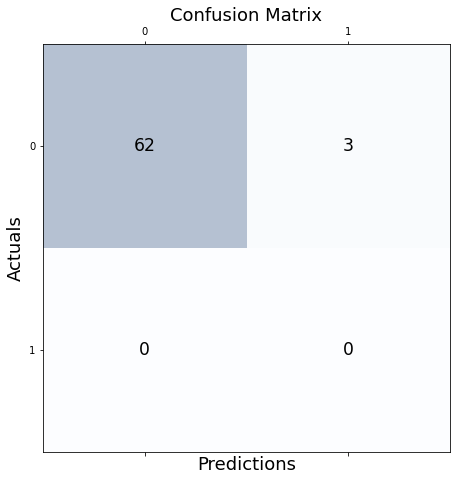

In [98]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmeans.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [186]:
kmeans.cluster_centers_

array([[1.06025810e-02, 2.13135082e-01, 5.42101086e-20, ...,
        1.71007017e+02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.05611240e-03, 8.86073243e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [200]:
y_kmeans = kmeans.predict(conv_layer_output)

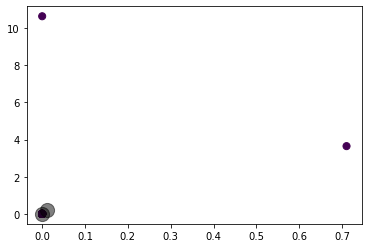

In [201]:
plt.scatter(conv_layer_output[:, 0], conv_layer_output[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [252]:
# The Lowest SSE Value
kmeans.inertia_

769336887.6656138

In [206]:
# The number of iterations required to converge
kmeans.n_iter_

2

C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans 

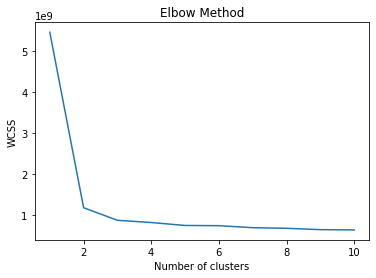

In [210]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(conv_layer_output)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [253]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(conv_layer_output)
    conv_layer_output["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [571]:
X[0].shape

(288, 288, 1)

We will now perform the K-Medoid Algorithm on the Pixelated Clock Images

In [105]:
# Install packages for K-Medoid
conda install -c conda-forge scikit-learn-extra


SyntaxError: invalid syntax (Temp/ipykernel_14296/3443467182.py, line 2)

In [106]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=2, random_state=0).fit(conv_layer_output)

In [107]:
kmedoids.labels_

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
      dtype=int64)

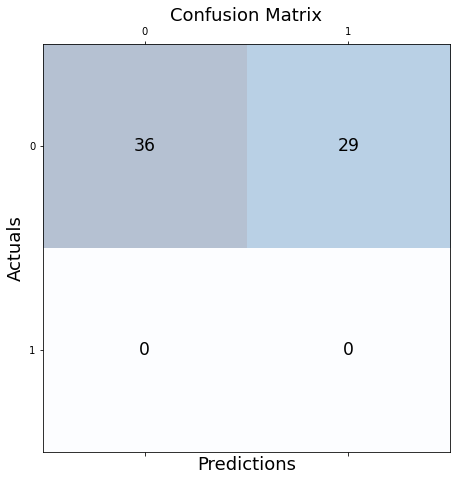

In [108]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmedoids.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [184]:
# The Lowest SSE Value
# A good model is one with low inertia AND a small number 
# of clusters

kmedoids.inertia_

320033.72

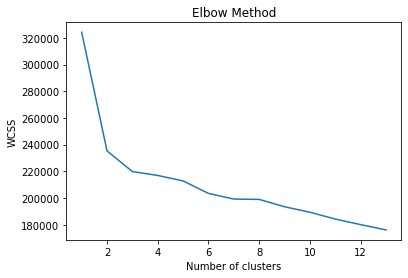

In [185]:
wcss = []
for i in range(1, 14):
    kmed = KMedoids(n_clusters=i, init='k-medoids++', max_iter=300, random_state=0)
    kmed.fit(conv_layer_output)
    wcss.append(kmed.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [176]:
from yellowbrick.cluster.elbow import kelbow_visualizer
# Use the quick method and immediately show the figure
kelbow_visualizer(kmedoids(random_state=4), conv_layer_output, k=(2,10))

ModuleNotFoundError: No module named 'yellowbrick'

In [122]:
df_ = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/COPD.csv")
df_

sid  COPD_P3
0     10015T        1
1     10017X        1
2     10031R        0
3     10032T        1
4     10049K        1
...      ...      ...
1712  23634Q        0
1713  23696M        1
1714  23785L        1
1715  23793K        0
1716  24637B        0

[1717 rows x 2 columns]

In [129]:
type(files_delete)

pandas.core.frame.DataFrame

In [113]:
from more_itertools import locate
list_to_check = kmedoids.labels_
def find_indices(list_to_check, item_to_find):  
    indices = locate(list_to_check,lambda x: x == item_to_find)
    return list(indices)

indices_of_intrest = find_indices(list_to_check, 0)
indices_of_intrest

[0,
 1,
 3,
 7,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 25,
 27,
 28,
 29,
 31,
 33,
 36,
 38,
 42,
 43,
 44,
 46,
 47,
 49,
 50,
 51,
 52,
 54,
 55,
 58,
 60,
 61,
 64]

In [114]:
files_nonoise[indices_of_intrest]

array(['10071D.PDF', '10098X.PDF', '10286Y.jpeg', '11161J.PDF',
       '13083Z.jpeg', '13484R.pdf', '13610W.PDF', '13937C.PDF',
       '14234Z.PDF', '14461K.pdf', '14486A.PDF', '15044Z.PDF',
       '15082H.pdf', '16231D.pdf', '16830Z.jpg', '16873R.PDF',
       '16974X.PDF', '17387N.pdf', '17415S.PDF', '17701T.PDF',
       '17905J.PDF', '19245D.PDF', '19294Q.PDF', '19318E.PDF',
       '19329J.PDF', '19441D.PDF', '19507H.PDF', '19601Z.PDF',
       '19960B.PDF', '20692P.pdf', '20977F.jpg', '21075W.jpg',
       '21518E.pdf', '22533F.pdf', '22660M.pdf', '23349R.pdf'],
      dtype='<U11')

In [131]:
type(d_f)

numpy.ndarray

In [146]:
df_p = pd.DataFrame(files_nonoise[indices_of_intrest], columns = ['sid'])
df_p

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
df_p['sid'] = files_delete['sid'].str.rstrip('.pdf')
df_p

sid
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
5   10796V
6   10973R
7   11161J
8   12281Y
9   12343U
10  12581K
11  13083Z
12  13384N
13  13484R
14  13610W
15  13937C
16  14234Z
17  14461K
18  14486A
19  14545Q
20  14845C
21  15044Z
22  15082H
23  15101L
24  16183S
25   16231
26  16470V
27  16830Z
28  16873R
29  16974X
30  17147T
31  17387N
32  17411K
33  17415S
34  17419A
35  17693U

In [137]:
#Sids of Label 0 from the K-Medoid Algorithm with the associated Self-Reported COPD Score
df_f = df_.merge(df_p,on = 'sid')
df_f

sid  COPD_P3
0   10098X        0
1   10286Y        0
2   10482Y        1
3   10796V        1
4   10973R        0
5   12281Y        0
6   12343U        0
7   13083Z        0
8   13384N        0
9   13610W        1
10  14234Z        0
11  14461K        1
12  14486A        0
13  14545Q        1
14  14845C        0
15  15044Z        0
16  15082H        1
17  15101L        1
18  16183S        0
19  16470V        1
20  16974X        0
21  17147T        0
22  17387N        0
23  17411K        0
24  17415S        1
25  17419A        0

In [138]:
# Obtaining the Clock Drawing images obtaing a label of 1
indices_of_intrest_1 = find_indices(list_to_check, 1)
indices_of_intrest_1

[2,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 19,
 20,
 23,
 24,
 26,
 30,
 32,
 34,
 35,
 37,
 39,
 40,
 41,
 45,
 48,
 53,
 56,
 57,
 59,
 62,
 63]

In [149]:
df_p_1 = pd.DataFrame(files_nonoise[indices_of_intrest_1], columns = ['sid'])

# We need to get rid of the .PDF, .pdf, & .jpeg
# Strip .pdf
df_p_1['sid'] = files_delete['sid'].str.rstrip('.pdf')
df_p_1

sid
0    10071
1   10098X
2    10111
3   10286Y
4   10482Y
5   10796V
6   10973R
7   11161J
8   12281Y
9   12343U
10  12581K
11  13083Z
12  13384N
13  13484R
14  13610W
15  13937C
16  14234Z
17  14461K
18  14486A
19  14545Q
20  14845C
21  15044Z
22  15082H
23  15101L
24  16183S
25   16231
26  16470V
27  16830Z
28  16873R

In [151]:
#Sids of Label 0 from the K-Medoid Algorithm with the associated Self-Reported COPD Score
df_f_1 = df_.merge(df_p_1,on = 'sid')
df_f_1

sid  COPD_P3
0   10098X        0
1   10286Y        0
2   10482Y        1
3   10796V        1
4   10973R        0
5   12281Y        0
6   12343U        0
7   13083Z        0
8   13384N        0
9   13610W        1
10  14234Z        0
11  14461K        1
12  14486A        0
13  14545Q        1
14  14845C        0
15  15044Z        0
16  15082H        1
17  15101L        1
18  16183S        0
19  16470V        1

In [ ]:
# Function for invidual CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool, more details in the report)
def model(activation = 'relu'):
    model = Sequential()
    # Input Image with dimensions (288x288x1) an input image 
    # 288 pixels wide by 288 pixels in height with 1 channel
    model.add(Conv2D(32, kernel_size=(3,3), activation= activation , input_shape=(288,288,1), name="conv_layer_1"))
    model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_1"))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation= activation ,name="conv_layer_2"))
#     model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_2"))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32,activation="relu", name="dense_layer_1"))
    model.add(Dense(2,activation="sigmoid"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')
    return(model)

conv_model =  model(activation = 'relu')
conv_hist = conv_model.fit(X_train,y_train ,epochs= 20,validation_data=(X_test,y_test))
conv_hist_dict = conv_hist.history

In [161]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1 (Conv2D)       (None, 286, 286, 32)      320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 143, 143, 32)      0         
                                                                 
 flatten (Flatten)           (None, 654368)            0         
                                                                 
 dense_layer_1 (Dense)       (None, 32)                20939808  
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 20,940,194
Trainable params: 20,940,194
Non-trainable params: 0
_________________________________________________________________


In [164]:
conv_model.layers[0](X[0])

ValueError: Input 0 of layer "conv_layer_1" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (288, 288, 1)

In [567]:
X.shape

(70, 288, 288, 1)

In [160]:
conv_model.layers[1].output

<KerasTensor: shape=(None, 143, 143, 32) dtype=float32 (created by layer 'maxpool_1')>

In [556]:
from tensorflow import keras
from tensorflow.keras import layers

model = Sequential([
    layers.Conv2D(32, kernel_size=(3,3), input_shape=(288,288,1)),
    #layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2),name="maxpool_1"),
    layers.Flatten(),
    layers.Dense(32,activation="relu", name="dense_layer_1"),
    layers.Dense(2,activation="sigmoid"),
    layers.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam'),
])

AttributeError: module 'tensorflow.keras.layers' has no attribute 'compile'

In [557]:
extractor = keras.Model(inputs=model.inputs,
                        outputs=[model.get_layer(MaxPooling2D).output])

AttributeError: 'function' object has no attribute 'inputs'

In [409]:
print(conv_hist)

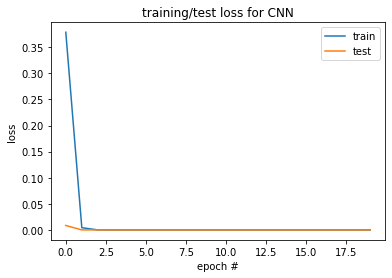

In [410]:
# Training/Testing Loss Charts
plt.plot(list(conv_hist_dict.items())[0][1]) # training loss values
plt.plot(list(conv_hist_dict.items())[2][1]) # test loss values
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.title('training/test loss for CNN')
plt.legend(['train','test'])

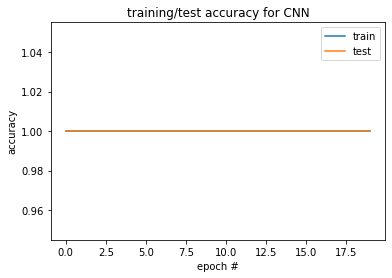

In [411]:
# Training/Testing Accuracy Charts
plt.plot(list(conv_hist_dict.items())[1][1]) # training accuracy values
plt.plot(list(conv_hist_dict.items())[3][1]) # test accuracy values
plt.xlabel('epoch #')
plt.ylabel('accuracy')
plt.title('training/test accuracy for CNN')
plt.legend(['train','test'])

In [412]:
# obtaining the classification report
y_pred = conv_model.predict(X_test, verbose=0)

In [152]:
fac = pd.read_csv("C:/Users/12563/Documents/Res. Methods in Math & Stats/Data/P2_factor_scores_20220610.csv")

In [155]:
gold = pd.read_csv('C:/Users/12563/Documents/Res. Methods in Math & Stats/Data_Final.csv')

In [ ]:
# Obtaining Percentage of people with FINAL Golde Baseline 1-4 Cluster A
df_gold = gold.merge(df_p, on = 'sid')
df_gold

(np.sum(df_gold['goldstage_final_V2'] != 0)/36) *100

In [264]:
# Obtaining Average Value of Factor Scores in Cluster A
df_fac_1 = fac.merge(df_p, on = 'sid')
df_fac_1

df_fac_1.mean()

C:\Users\12563\AppData\Local\Temp/ipykernel_20804/3435024025.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fac_1.mean()


F1compP2    0.318426
F2compP2    0.008456
F3compP2    0.310909
F4compP2    0.339852
dtype: float64

In [158]:
df_fac_1 = fac.merge(df_p_1, on = 'sid')
df_fac_1

sid  F1compP2  F2compP2  F3compP2  F4compP2
0   10098X  0.396002  0.868078  0.451179 -0.729966
1   10286Y  0.792556 -0.630638  0.904748 -0.785195
2   10796V  0.667201 -0.269795  0.928741  1.774383
3   12281Y  0.781732  0.491166  0.584655  0.759469
4   12343U  0.012340  0.082806 -0.323906 -0.060235
5   13083Z  0.136775  0.604984  0.261665  0.909699
6   13384N  0.085730  0.470285  0.325569  0.030117
7   13484R  0.834276 -0.028157  1.110327  1.026943
8   13610W  0.713851  0.482236  0.801969  1.770297
9   13937C  0.437493 -0.450963  0.362679  0.934088
10  14486A -0.864085 -1.019094 -0.753519 -0.500678
11  14545Q  1.212988  0.354166  1.016279  0.247180
12  15044Z -0.126046 -0.577395 -0.300687  0.549455
13  15082H  0.796079  1.127933  0.532250  1.256171
14  15101L -0.335524 -1.327074 -0.176607 -0.803219
15  16470V  0.140967  0.248432  0.227176  0.827360
16  16830Z -0.076167  0.355262 -0.326202 -0.308485
17  16873R  2.310415  0.550813  2.460517  1.891373

In [159]:
df_fac_1.mean()

C:\Users\12563\AppData\Local\Temp/ipykernel_14296/1236240155.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fac_1.mean()


F1compP2    0.439810
F2compP2    0.074058
F3compP2    0.449269
F4compP2    0.488264
dtype: float64

In [156]:
df_gold_1 = gold.merge(df_p_1, on = 'sid')
df_gold_1

sid  fev1pp_final  goldstage_final_V2  COPD_P3  Score
0   10098X         120.3                   2        0      0
1   10286Y          77.7                   2        0      0
2   10482Y          59.7                   2        1      0
3   10796V          78.6                   2        1      0
4   10973R          74.3                   2        0      0
5   12281Y          59.8                   2        0      0
6   12343U          86.5                   0        0      0
7   13083Z          72.1                   2        0      0
8   13384N          81.1                   0        0      0
9   13610W          25.2                   2        1      0
10  14234Z          86.8                   0        0      0
11  14461K          18.7                   2        1      0
12  14486A          82.0                   0        0      0
13  14545Q          77.3                   1        1      0
14  14845C         146.1                   0        0      0
15  15044Z          93.0                   2        0      0
16  15082H          56.7                   2        1      0
17  15101L          98.6                   0        1      0
18  16183S         106.4                   0        0      0
19  16470V          64.0                   2        1      0

In [170]:
(np.sum(df_gold_1['goldstage_final_V2'] != 0)/29) *100

44.827586206896555

In [ ]:
self.X.iloc[:, np.where(clustering.labels_ == label)[0]]

In [276]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [277]:
import kerastuner

In [182]:
from kerastuner.tuners import RandomSearch

C:\Users\12563\AppData\Local\Temp/ipykernel_11324/2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [183]:
# Loading X(clock matrix) and Y (labels) data (already suffeled and noises removed)
X = np.load('/Users/12563/Desktop/Batch 1 (2)/Xall_nonoi_shfl_use_0.npy')
y = np.load('/Users/12563/Desktop/Batch 1 (2)/Yall_nonoi_shfl_use_0.npy')


X = X.reshape([len(X), 288, 288, 1])


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, train_size=0.8, random_state=33)

print (len(y_train[y_train == 0]) , len(y_train[y_train == 1]))
print (len(y_test[y_test == 0]) , len(y_test[y_test == 1]))

# Scaling train and test datasets
X_train = X_train/255
X_test = X_test/255



# Function for randomized search on CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool)
def build_model(hp):
    model = keras.models.Sequential()
    model.add(Conv2D(filters = hp.Int("conv_layer_1", min_value = 32, max_value = 96, step = 32), 
                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), activation= 'relu', input_shape=(288,288,1)))
    model.add(MaxPooling2D(hp.Choice('maxpool_1', values = [2,3])))
#    model.add(Dropout(0.25))

#    model.add(Conv2D(filters = hp.Int("conv_layer_2", min_value = 32, max_value = 96, step = 32), 
#                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), activation= 'relu', input_shape=(288,288,1)))
#    model.add(MaxPooling2D(hp.Choice('maxpool_2', values = [2,3])))
#    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units = hp.Int('dense_layer_1', min_value=16, max_value=48, step=16) , activation="relu"))
    model.add(Dense(2,activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')

    return(model)

tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=10, project_name="Kerastuner_clock")


tuner_search.search(X_train, y_train, epochs= 20, validation_data= (X_test, y_test))



56 0
14 0
INFO:tensorflow:Reloading Oracle from existing project .\Kerastuner_clock\oracle.json
INFO:tensorflow:Reloading Tuner from .\Kerastuner_clock\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [184]:
tuner_search.results_summary()


Results summary
Results in .\Kerastuner_clock
Showing 10 best trials
Trial summary
Hyperparameters:
conv_layer_1: 32
conv_2_kernel: 5
maxpool_1: 3
dense_layer_1: 16
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 64
conv_2_kernel: 5
maxpool_1: 3
dense_layer_1: 48
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 32
conv_2_kernel: 5
maxpool_1: 3
dense_layer_1: 48
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 64
conv_2_kernel: 5
maxpool_1: 2
dense_layer_1: 32
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 32
conv_2_kernel: 5
maxpool_1: 3
dense_layer_1: 32
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 32
conv_2_kernel: 3
maxpool_1: 2
dense_layer_1: 32
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 64
conv_2_kernel: 3
maxpool_1: 3
dense_layer_1: 48
Score: 0.8865979313850403
Trial summary
Hyperparameters:
conv_layer_1: 64
conv_2_kernel: 3
maxpool_1: 2

In [424]:
shape(X)

(70, 82944)

In [211]:
# fining the best model
best_model = tuner_search.get_best_models(num_models=1)[0]
best_model.summary()
loss, acc = best_model.evaluate(X_test, y_test)
print (loss, acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 284, 284, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 94, 94, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 282752)            0         
                                                                 
 dense (Dense)               (None, 16)                4524048   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 4,524,914
Trainable params: 4,524,914
Non-trainable params: 0
______________________________________________

In [212]:
feature_extractor = tf.keras.Model(
    inputs=conv_model.inputs,
    outputs=[
             best_model.output,  # < last layer output 
             best_model.layers[2].output # < your convolution layer output 
    ]
)

model_output, conv_layer_output = feature_extractor(X)
conv_layer_output

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'") at layer "conv2d". The following previous layers were accessed without issue: []

In [417]:
shape(X)

(70, 288, 288, 1)

In [171]:
shape(X_train)

(4, 288, 288, 1)

In [423]:
X = X.reshape([len(X), 82944])

array([[255.        , 255.        , 255.        , ..., 255.        ,
        255.        , 255.        ],
       [255.        , 255.        , 255.        , ..., 255.        ,
        255.        , 255.        ],
       [242.17821125, 248.82873335, 248.69116031, ..., 251.85272881,
        248.84615798, 250.90588106],
       ...,
       [253.20401474, 253.79625889, 254.96001176, ..., 255.        ,
        255.        , 255.        ],
       [255.        , 255.        , 255.        , ..., 255.        ,
        255.        , 255.        ],
       [254.        , 254.        , 254.        , ..., 254.        ,
        254.        , 254.        ]])

In [396]:
np.reshape(X, (333, 82944))

ValueError: cannot reshape array of size 1332 into shape (333,82944)

In [185]:
shape(X)

(485, 288, 288, 1)

## CNN-Optimization

In [178]:
# Function for invidual CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool, more details in the report)
def model(activation = 'relu'):
    model = Sequential()
    model.add(Conv2D(3, kernel_size=(3,3), activation= activation , input_shape=(288,288,1), name="conv_layer_1"))
    model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_1"))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation= activation ,name="conv_layer_2"))
#     model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_2"))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(41879584,activation="relu", name="dense_layer_1"))
    model.add(Dense(32,activation="sigmoid"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')
    return(model)

conv_model =  model(activation = 'relu')
conv_hist = conv_model.fit(X_train,y_train ,epochs= 20,validation_data=(X_test,y_test))
conv_hist_dict = conv_hist.history

Epoch 1/20
1/1 [==============================] - 1s 676ms/step - loss: 3.4701 - accuracy: 0.0000e+00 - val_loss: 3.2740 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 72ms/step - loss: 2.8023 - accuracy: 1.0000 - val_loss: 3.0493 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 72ms/step - loss: 2.1155 - accuracy: 1.0000 - val_loss: 2.8062 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 1.4421 - accuracy: 1.0000 - val_loss: 2.5452 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 72ms/step - loss: 0.8568 - accuracy: 1.0000 - val_loss: 2.2696 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 72ms/step - loss: 0.4392 - accuracy: 1.0000 - val_loss: 1.9778 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 72ms/step - loss: 0.2010 - accuracy: 1.0000 - val_loss: 1.5727 - val_accuracy: 1.0000
Epoch 8/20
1/1 [==

## 10-CNN Modeling

In [ ]:
# Function for invidual CNN models (2 stuctures: Conv_Pool and Conv_Pool_Conv_Pool, more details in the report)
def model(activation = 'relu'):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation= activation , input_shape=(288,288,1), name="conv_layer_1"))
    model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_1"))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation= activation ,name="conv_layer_2"))
#     model.add(MaxPooling2D(pool_size=(2,2),name="maxpool_2"))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32,activation="relu", name="dense_layer_1"))
    model.add(Dense(2,activation="sigmoid"))
    model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'],optimizer='adam')
    return(model)



conv_model =  model(activation = 'relu')
conv_hist = conv_model.fit(X_train,y_train ,epochs= 20,validation_data=(X_test,y_test))
conv_hist_dict = conv_hist.history

# Training/Testing Loss Charts
plt.plot(list(conv_hist_dict.items())[0][1]) # training loss values
plt.plot(list(conv_hist_dict.items())[2][1]) # test loss values
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.title('training/test loss for CNN')
plt.legend(['train','test'])
plt.savefig('Clock/train_test_loss.png', transparent = True)
plt.close()

# Training/Testing Accuracy Charts
plt.plot(list(conv_hist_dict.items())[1][1]) # training accuracy values
plt.plot(list(conv_hist_dict.items())[3][1]) # test accuracy values
plt.xlabel('epoch #')
plt.ylabel('accuracy')
plt.title('training/test accuracy for CNN')
plt.legend(['train','test'])
plt.savefig('Clock/train_test_acc.png', transparent = True)
plt.close()

# saving the model
conv_model.save('Clock/conv_model.h5') 


# obtaining the classification report
y_pred = conv_model.predict_classes(X_test, verbose=0)
report = classification_report(y_pred, y_test)

print (report)
print (confusion_matrix (y_test, y_pred))

# saving the results
file = open('Clock/report.txt', "w")
file.write('classification_report, test-data')
file.writelines("\r")
file.write(report)
file.writelines("\r")
file.write('confusion_matrix for test-data')
file.writelines("\r")
file.write(str(confusion_matrix (y_test, y_pred)))
file.close()

In [183]:
# Create a CNN Model

#Default model paramters

def create_cnn_model(pool_type='max', conv_activation='sigmoid', activ_function='relu',
                     dropout_rate=0.1, filters=16, kern_size=2, neurons=256,
                     mid_layers=1, optimizer='adam', learning_rate=1e-3):
    # Create model
    model = keras.Sequential()
    
    # First layer: convolution
    model.add(keras.layers.Conv2D(filters, kernel_size=(kern_size, kern_size), activation=conv_activation,
                                  input_shape=(288,288,1))) 
        
    # First layer
    if mid_layers==1:
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
    
    # Second layer  
    if mid_layers==2:  
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2))) 
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
            
            
    # Third layer
    if mid_layers==3:   
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(4*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        
    # Fourth layer   
    if mid_layers==4:   
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(4*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
            
     # Penultimate layer with Flatten, Dense, and Dropout from the MLP grid search
    model.add(keras.layers.Flatten())         
    # First Fully Connected Layer
    model.add(keras.layers.Dense(neurons, activation=activ_function))
    #Dropout is a form a regularization
    model.add(keras.layers.Dropout(dropout_rate))
    # Second Fully Connected layer
    model.add(keras.layers.Dense(neurons, activation=activ_function))
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Final layer with the sigmoid for classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Running through the optimizers
   
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
        )    
    return model

In [44]:
# Creating and compiling the model with a summary

cnn = create_cnn_model()
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 287, 287, 16)      80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 143, 143, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 327184)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               83759360  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                      

In [43]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [45]:
# CNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [46]:
# Optimize the model with grid search


# Grid search parameters
n_epochs_cv = 2 # Number of epochs for our grid search
n_cv = 2 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(model=create_cnn_model, verbose=1)

# Define parameters and values for grid search to check in our model
param_grid = {
    # The features to range over in our model
    'model__pool_type': ['max', 'average'],
    'model__conv_activation': ['relu', 'sigmoid', 'tanh'],
    'model__activ_function':['tanh'],
    'model__filters': [16, 32, 64, 128],
    'model__neurons':[512],
    'model__dropout_rate':[0.6],
    'model__optimizer':['adam'],
    'model__kern_size':[2, 3],
    'model__mid_layers':[1, 2],
     # The features to range over for our optimizer
    'model__learning_rate':[1e-5],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

C:\Users\12563\OneDrive\New folder\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


============================= test session starts =============================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1
rootdir: C:\Users\12563\Documents\Res. Methods in Math & Stats
plugins: anyio-2.2.0
collected 46111 items / 11134 deselected / 34977 selected

_build_utils\tests\test_scipy_version.py .                               [  0%]
_lib\tests\test__gcutils.py ......                                       [  0%]
_lib\tests\test__pep440.py .........                                     [  0%]
_lib\tests\test__testutils.py ..                                         [  0%]
_lib\tests\test__threadsafety.py ..                                      [  0%]
_lib\tests\test__util.py ......................                          [  0%]
_lib\tests\test_bunch.py ............................                    [  0%]
_lib\tests\test_ccallback.py ....                                        [  0%]
_lib\tests\test_deprecation.py .                                  

........................................................................ [ 26%]
........................................................................ [ 26%]
........................................................................ [ 27%]
........................................................................ [ 27%]
........................................................................ [ 27%]
........................................................................ [ 27%]
........................................................................ [ 27%]
........................................................................ [ 28%]
........................................................................ [ 28%]
........................................................................ [ 28%]
........................................................................ [ 28%]
........................................................................ [ 28%]
........................................

signal\tests\test_windows.py ........................................... [ 54%]
..                                                                       [ 54%]
sparse\csgraph\tests\test_connected_components.py ......                 [ 54%]
sparse\csgraph\tests\test_conversions.py ...                             [ 54%]
sparse\csgraph\tests\test_flow.py ...............                        [ 54%]
sparse\csgraph\tests\test_graph_laplacian.py ....                        [ 54%]
sparse\csgraph\tests\test_matching.py ....................s              [ 54%]
sparse\csgraph\tests\test_reordering.py ...                              [ 54%]
sparse\csgraph\tests\test_shortest_path.py ............................. [ 54%]
.                                                                        [ 54%]
sparse\csgraph\tests\test_spanning_tree.py .                             [ 54%]
sparse\csgraph\tests\test_traversal.py ....                              [ 54%]
sparse\linalg\dsolve\tests\test_linsolve

special\tests\test_pcf.py ..                                             [ 81%]
special\tests\test_pdtr.py ..........                                    [ 81%]
special\tests\test_precompute_expn_asy.py .                              [ 81%]
special\tests\test_precompute_gammainc.py .s.s                           [ 81%]
special\tests\test_round.py ss                                           [ 82%]
special\tests\test_sf_error.py .......                                   [ 82%]
special\tests\test_sici.py ..                                            [ 82%]
special\tests\test_spence.py ..                                          [ 82%]
special\tests\test_spfun_stats.py ....                                   [ 82%]
special\tests\test_sph_harm.py .                                         [ 82%]
special\tests\test_spherical_bessel.py ................................. [ 82%]
....                                                                     [ 82%]
special\tests\test_trig.py ....         

False

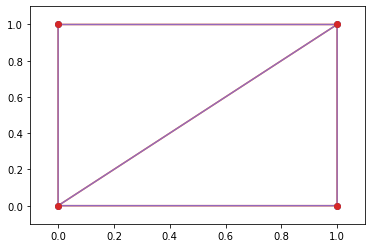

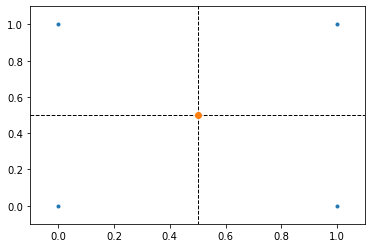

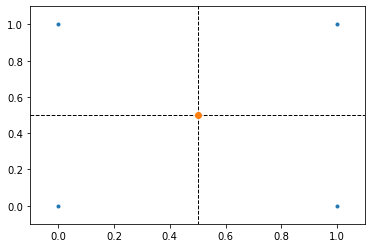

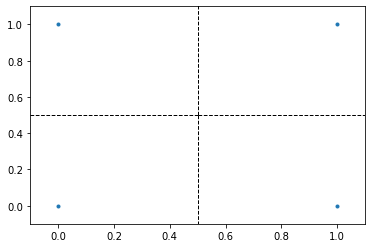

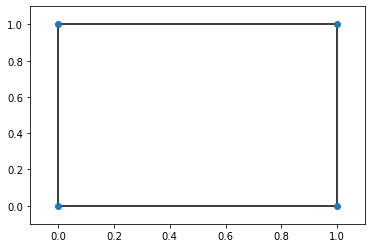

In [182]:
import scipy
scipy.test()

In [ ]:
print(grid.fit(X_train, y_train))

In [1]:
print(grid_result.best_params_)

NameError: name 'grid_result' is not defined